<h3>Cutlist Optimizer</h3>

<h4>Import Libraries</h4>

In [1]:
import csv
from typing import List, Dict
from collections import Counter

<h4>Define File Locations</h4>

In [2]:
# Define file paths
glass_data_file = 'data/glass_data.csv'  # Update with the actual path to your glass data file
stock_sizes_file = 'data/glass_sheet_size.csv'  # Update with the actual path to your stock sizes file

# Gap between parts in mm
gap = 0

<h4>Load Data Functions</h4>

In [3]:
def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

In [4]:
def load_stock_sizes(filepath: str) -> List[Dict]:
    """Expand glass parts based on quantity."""
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

<h4>Expand Glass Parts</h4>

In [5]:
def expand_parts(glass_parts: List[Dict]) -> List[Dict]:
    """Expand glass parts based on quantity."""
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([{'location': part['location'], 'length': part['length'], 'height': part['height']} for _ in range(part['qty'])])
    return expanded_parts

<h4>Calculate Layout</h4>

In [6]:
def calculate_layout(parts: List[Dict], stock_sizes: List[Dict], gap: int) -> List[Dict]:
    """Calculate optimized layout for glass parts on stock sheets."""
    def can_fit(part, space):
        return (part['length'] <= space[2] and part['height'] <= space[3]) or \
               (part['height'] <= space[2] and part['length'] <= space[3])

    def place_part(part, position, rotated):
        return {'part': part, 'position': position, 'rotated': rotated}

    sheets = []
    remaining_parts = parts.copy()

    while remaining_parts:
        best_utilization = 0
        best_sheet = None
        best_placement = None

        for stock in stock_sizes:
            sheet = {'size': (stock['length'], stock['width']), 'placements': []}
            available_space = [(0, 0, stock['length'], stock['width'])]

            for part in remaining_parts:
                best_fit = None
                for i, space in enumerate(available_space):
                    if can_fit(part, space):
                        rotated = part['height'] <= space[2] and part['length'] > space[2]
                        best_fit = (i, space, rotated)
                        break

                if best_fit:
                    i, space, rotated = best_fit
                    x, y = space[0], space[1]
                    w, h = (part['height'], part['length']) if rotated else (part['length'], part['height'])
                    sheet['placements'].append(place_part(part, (x, y), rotated))
                    
                    # Update available space
                    del available_space[i]
                    if x + w + gap < stock['length']:
                        available_space.append((x + w + gap, y, stock['length'] - (x + w + gap), h))
                    if y + h + gap < stock['width']:
                        available_space.append((x, y + h + gap, w, stock['width'] - (y + h + gap)))
                    available_space.sort(key=lambda s: (s[2] * s[3], s[2] + s[3]), reverse=True)

            utilization = sum(p['part']['length'] * p['part']['height'] for p in sheet['placements']) / (stock['length'] * stock['width'])
            if utilization > best_utilization:
                best_utilization = utilization
                best_sheet = sheet
                best_placement = [p['part'] for p in sheet['placements']]

        if best_sheet:
            sheets.append(best_sheet)
            for part in best_placement:
                remaining_parts.remove(part)
        else:
            # If no placement found, add the smallest part to a new sheet
            smallest_part = min(remaining_parts, key=lambda p: p['length'] * p['height'])
            smallest_stock = min(stock_sizes, key=lambda s: s['length'] * s['width'])
            sheets.append({
                'size': (smallest_stock['length'], smallest_stock['width']),
                'placements': [place_part(smallest_part, (0, 0), False)]
            })
            remaining_parts.remove(smallest_part)

    return sheets



<h4>Function to Calculate Stock Area</h4>

In [7]:
def calculate_stock_area(stock_sizes_file: str) -> float:
    """Calculate the total stock area from the stock sizes file."""
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Calculate the total area in square millimeters
    total_area_mm2 = sum(stock['length'] * stock['width'] * stock['qty'] for stock in stock_sizes)
    
    # Convert to square meters
    total_area_m2 = total_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²
    
    return total_area_m2

# Calculate total stock area
total_stock_area = calculate_stock_area(stock_sizes_file)
# print(f"Total stock area: {total_stock_area:.3f} sq m")


<h4>Optimization Workflow</h4>

In [8]:
def optimize_glass_cutting(glass_data_file: str, stock_sizes_file: str, gap: int):
    """Optimize glass cutting process and print results."""
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Expand parts based on quantity
    expanded_parts = expand_parts(glass_parts)
    
    # Sort parts by area in descending order
    expanded_parts.sort(key=lambda x: x['length'] * x['height'], reverse=True)
    
    optimized_layout = calculate_layout(expanded_parts, stock_sizes, gap)
    
    # Calculate total areas in square millimeters
    total_glass_area_mm2 = sum(part['length'] * part['height'] for part in expanded_parts)
    total_sheet_area_mm2 = sum(sheet['size'][0] * sheet['size'][1] for sheet in optimized_layout)
    
    # Convert areas to square meters
    total_glass_area_m2 = total_glass_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²
    total_sheet_area_m2 = total_sheet_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²
    
    # Calculate efficiency and wastage
    used_area_percentage = (total_glass_area_mm2 / total_sheet_area_mm2) * 100
    wastage_percentage = 100 - used_area_percentage
    
    # Calculate sheet size usage summary
    sheet_counter = Counter((sheet['size'][0], sheet['size'][1]) for sheet in optimized_layout)
    
    # Print results
    print(f"Total stock area: {total_stock_area:.3f} sq m")
    print(f"\nTotal glass area: {total_glass_area_m2:.3f} sq m")
    print(f"\nTotal sheets used: {len(optimized_layout)}")
    print(f"Total stock area used: {total_sheet_area_m2:.3f} sq m")
    print(f"\nUsed area percentage: {used_area_percentage:.2f}%")
    print(f"Wastage percentage: {wastage_percentage:.2f}%")
    
    # Print summary of sheet sizes used and their quantity
    print("\nSummary of sheet sizes used:")
    for (length, width), qty in sheet_counter.items():
        print(f"  {length}mm x {width}mm: {qty} pcs")
    
    print("Optimized Layout:")
    for i, sheet in enumerate(optimized_layout, 1):
        print(f"Sheet {i}: {sheet['size'][0]}mm x {sheet['size'][1]}mm")
        for placement in sheet['placements']:
            part = placement['part']
            position = placement['position']
            orientation = "height as length" if placement['rotated'] else "normal"
            print(f"  {part['location']} ({part['length']}x{part['height']}) at position {position} ({orientation})")

# Run the optimization workflow
optimize_glass_cutting(glass_data_file, stock_sizes_file, gap)

Total stock area: 4019.040 sq m

Total glass area: 451.142 sq m

Total sheets used: 68
Total stock area used: 471.240 sq m

Used area percentage: 95.73%
Wastage percentage: 4.27%

Summary of sheet sizes used:
  3300mm x 2100mm: 40 pcs
  2100mm x 3300mm: 28 pcs
Optimized Layout:
Sheet 1: 3300mm x 2100mm
  CWG-403 (976x2358) at position (0, 0) (normal)
  CWG-403 (976x2358) at position (976, 0) (normal)
  CWG-403 (976x2358) at position (1952, 0) (normal)
Sheet 2: 3300mm x 2100mm
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 3: 3300mm x 2100mm
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 4: 3300mm x 2100mm
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 5: 3300mm x 2100

<H3>Update code from Claude</H3>

In [9]:
import csv
from typing import List, Dict
from collections import Counter

# Define file paths
glass_data_file = 'data/glass_data.csv'
stock_sizes_file = 'data/glass_sheet_size.csv'

gap = 0  # Gap between parts in mm

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

def expand_parts(glass_parts: List[Dict]) -> List[Dict]:
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([{'location': part['location'], 'length': part['length'], 'height': part['height']} for _ in range(part['qty'])])
    return expanded_parts

def calculate_layout(parts: List[Dict], stock_sizes: List[Dict], gap: int) -> List[Dict]:
    def can_fit(part, space):
        return (part['length'] <= space[2] and part['height'] <= space[3]) or \
               (part['height'] <= space[2] and part['length'] <= space[3])

    def place_part(part, position, rotated):
        return {'part': part, 'position': position, 'rotated': rotated}

    sheets = []
    remaining_parts = parts.copy()

    while remaining_parts:
        best_utilization = 0
        best_sheet = None
        best_placement = None

        for stock in stock_sizes:
            sheet = {'size': (stock['length'], stock['width']), 'placements': []}
            available_space = [(0, 0, stock['length'], stock['width'])]

            for part in remaining_parts:
                best_fit = None
                for i, space in enumerate(available_space):
                    if can_fit(part, space):
                        rotated = part['height'] <= space[2] and part['length'] > space[2]
                        best_fit = (i, space, rotated)
                        break

                if best_fit:
                    i, space, rotated = best_fit
                    x, y = space[0], space[1]
                    w, h = (part['height'], part['length']) if rotated else (part['length'], part['height'])
                    sheet['placements'].append(place_part(part, (x, y), rotated))
                    
                    # Update available space
                    del available_space[i]
                    if x + w + gap < stock['length']:
                        available_space.append((x + w + gap, y, stock['length'] - (x + w + gap), h))
                    if y + h + gap < stock['width']:
                        available_space.append((x, y + h + gap, w, stock['width'] - (y + h + gap)))
                    available_space.sort(key=lambda s: (s[2] * s[3], s[2] + s[3]), reverse=True)

            utilization = sum(p['part']['length'] * p['part']['height'] for p in sheet['placements']) / (stock['length'] * stock['width'])
            if utilization > best_utilization:
                best_utilization = utilization
                best_sheet = sheet
                best_placement = [p['part'] for p in sheet['placements']]

        if best_sheet:
            sheets.append(best_sheet)
            for part in best_placement:
                remaining_parts.remove(part)
        else:
            # If no placement found, add the smallest part to a new sheet
            smallest_part = min(remaining_parts, key=lambda p: p['length'] * p['height'])
            smallest_stock = min(stock_sizes, key=lambda s: s['length'] * s['width'])
            sheets.append({
                'size': (smallest_stock['length'], smallest_stock['width']),
                'placements': [place_part(smallest_part, (0, 0), False)]
            })
            remaining_parts.remove(smallest_part)

    return sheets

def calculate_sheet_wastage(sheet: Dict, gap: int) -> float:
    """
    Calculate wastage percentage for a single sheet
    
    Args:
        sheet: Sheet configuration
        gap: Gap between parts
    
    Returns:
        Wastage percentage for the sheet
    """
    # Calculate total part area
    total_part_area = sum(
        placement['part']['length'] * placement['part']['height'] 
        for placement in sheet['placements']
    )
    
    # Calculate total sheet area
    sheet_area = sheet['size'][0] * sheet['size'][1]
    
    # Calculate used area percentage
    used_area_percentage = (total_part_area / sheet_area) * 100
    
    # Calculate wastage percentage
    wastage_percentage = 100 - used_area_percentage
    
    return wastage_percentage

def calculate_stock_area(stock_sizes_file: str) -> float:
    """Calculate the total stock area from the stock sizes file."""
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Calculate the total area in square millimeters
    total_area_mm2 = sum(stock['length'] * stock['width'] * stock['qty'] for stock in stock_sizes)
    
    # Convert to square meters
    total_area_m2 = total_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²
    
    return total_area_m2

# Calculate total stock area
total_stock_area = calculate_stock_area(stock_sizes_file)

def optimize_glass_cutting(glass_data_file: str, stock_sizes_file: str, gap: int):
    # Load glass parts and stock sizes
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Sort stock sizes by area in descending order
    stock_sizes.sort(key=lambda x: x['length'] * x['width'], reverse=True)
    
    # Initialize variables to track best configuration
    best_total_configuration = {
        'total_wastage': float('inf'),
        'total_sheets_used': float('inf'),
        'optimized_layout': None,
        'sheet_usage': None,
        'starting_size': None
    }
    
    # Iterate through all stock sizes as starting points
    for start_index in range(len(stock_sizes)):
        # Reorder stock sizes to start with the current size
        current_stock_sizes = (
            stock_sizes[start_index:] + 
            stock_sizes[:start_index]
        )
        
        # Expand and prepare parts
        expanded_parts = expand_parts(glass_parts)
        expanded_parts.sort(key=lambda x: x['length'] * x['height'], reverse=True)
        
        # Calculate layout using current stock size order
        current_layout = calculate_layout(expanded_parts.copy(), current_stock_sizes, gap)
        
        # Calculate total wastage and metrics
        total_part_area = sum(part['length'] * part['height'] for part in expanded_parts)
        total_sheet_area = sum(sheet['size'][0] * sheet['size'][1] for sheet in current_layout)
        
        # Calculate average sheet wastage
        total_wastage = sum(
            calculate_sheet_wastage(sheet, gap) for sheet in current_layout
        ) / len(current_layout)
        
        # Track configuration
        current_configuration = {
            'total_wastage': total_wastage,
            'total_sheets_used': len(current_layout),
            'optimized_layout': current_layout,
            'sheet_usage': Counter((sheet['size'][0], sheet['size'][1]) for sheet in current_layout),
            'starting_size': current_stock_sizes[0]
        }
        
        # Compare and update best configuration
        if (current_configuration['total_wastage'] < best_total_configuration['total_wastage'] or 
            (current_configuration['total_wastage'] == best_total_configuration['total_wastage'] and 
             current_configuration['total_sheets_used'] < best_total_configuration['total_sheets_used'])):
            best_total_configuration = current_configuration
    
    # Print optimization results
    best_layout = best_total_configuration['optimized_layout']
    total_glass_area_m2 = sum(part['length'] * part['height'] for part in expanded_parts) / 1_000_000
    total_sheet_area_m2 = sum(sheet['size'][0] * sheet['size'][1] for sheet in best_layout) / 1_000_000
    
    print("\n--- Optimization Results ---")
    print(f"Best Starting Sheet Size: {best_total_configuration['starting_size']['length']}mm x {best_total_configuration['starting_size']['width']}mm")
    print(f"Total Glass Area: {total_glass_area_m2:.3f} sq m")
    print(f"Total Sheet Area Used: {total_sheet_area_m2:.3f} sq m")
    print(f"Total Sheets Used: {len(best_layout)}")
    print(f"Average Wastage Percentage: {best_total_configuration['total_wastage']:.2f}%")
    
    # Sheet size usage summary
    print("\nSheet Size Usage:")
    for (length, width), qty in best_total_configuration['sheet_usage'].items():
        print(f"  {length}mm x {width}mm: {qty} pcs")
    
    # Detailed layout
    print("\nOptimized Layout:")
    for i, sheet in enumerate(best_layout, 1):
        print(f"Sheet {i}: {sheet['size'][0]}mm x {sheet['size'][1]}mm")
        sheet_wastage = calculate_sheet_wastage(sheet, gap)
        print(f"  Sheet Wastage: {sheet_wastage:.2f}%")
        for placement in sheet['placements']:
            part = placement['part']
            position = placement['position']
            orientation = "height as length" if placement['rotated'] else "normal"
            print(f"  {part['location']} ({part['length']}x{part['height']}) at position {position} ({orientation})")

optimize_glass_cutting(glass_data_file, stock_sizes_file, gap)


--- Optimization Results ---
Best Starting Sheet Size: 3300mm x 2438mm
Total Glass Area: 451.142 sq m
Total Sheet Area Used: 471.240 sq m
Total Sheets Used: 68
Average Wastage Percentage: 4.27%

Sheet Size Usage:
  3300mm x 2100mm: 40 pcs
  2100mm x 3300mm: 28 pcs

Optimized Layout:
Sheet 1: 3300mm x 2100mm
  Sheet Wastage: 0.37%
  CWG-403 (976x2358) at position (0, 0) (normal)
  CWG-403 (976x2358) at position (976, 0) (normal)
  CWG-403 (976x2358) at position (1952, 0) (normal)
Sheet 2: 3300mm x 2100mm
  Sheet Wastage: 2.55%
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 3: 3300mm x 2100mm
  Sheet Wastage: 2.55%
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 4: 3300mm x 2100mm
  Sheet Wastage: 2.55%
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at po

<H3>Update code from Gemini</H3>

In [10]:
import csv
from typing import List, Dict
from collections import Counter

# Define file paths
glass_data_file = 'data/glass_data.csv'
stock_sizes_file = 'data/glass_sheet_size.csv'

gap = 0  # Gap between parts in mm

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'],
                 'length': int(row['glass_length']),
                 'height': int(row['glass_height']),
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']),
                 'width': int(row['width']),
                 'qty': int(row['qty'])} for row in reader]

def expand_parts(glass_parts: List[Dict]) -> List[Dict]:
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([{'location': part['location'], 'length': part['length'], 'height': part['height']} for _ in range(part['qty'])])
    return expanded_parts

def calculate_layout(parts: List[Dict], stock_sizes: List[Dict], gap: int) -> List[Dict]:
    def can_fit(part, space):
        return (part['length'] <= space[2] and part['height'] <= space[3]) or \
               (part['height'] <= space[2] and part['length'] <= space[3])

    def place_part(part, position, rotated):
        return {'part': part, 'position': position, 'rotated': rotated}

    sheets = []
    remaining_parts = parts.copy()

    while remaining_parts:
        best_utilization = 0
        best_sheet = None
        best_placement = None

        for stock in stock_sizes:
            sheet = {'size': (stock['length'], stock['width']), 'placements': []}
            available_space = [(0, 0, stock['length'], stock['width'])]

            for part in remaining_parts:
                best_fit = None
                for i, space in enumerate(available_space):
                    # Check for all possible rotations
                    for rotation in [(False, (part['length'], part['height'])), (True, (part['height'], part['length']))]:
                        rotated, (w, h) = rotation
                        if can_fit(part, space):
                            best_fit = (i, space, rotated)
                            break
                    if best_fit:
                        break

                if best_fit:
                    i, space, rotated = best_fit
                    x, y = space[0], space[1]
                    sheet['placements'].append(place_part(part, (x, y), rotated))

                    # Update available space
                    del available_space[i]
                    if x + w + gap < stock['length']:
                        available_space.append((x + w + gap, y, stock['length'] - (x + w + gap), h))
                    if y + h + gap < stock['width']:
                        available_space.append((x, y + h + gap, w, stock['width'] - (y + h + gap)))
                    available_space.sort(key=lambda s: (s[2] * s[3], s[2] + s[3]), reverse=True)

            utilization = sum(p['part']['length'] * p['part']['height'] for p in sheet['placements']) / (stock['length'] * stock['width'])
            if utilization > best_utilization:
                best_utilization = utilization
                best_sheet = sheet
                best_placement = [p['part'] for p in sheet['placements']]

        if best_sheet:
            sheets.append(best_sheet)
            for part in best_placement:
                remaining_parts.remove(part)
        else:
            # If no placement found, add the smallest part to a new sheet
            smallest_part = min(remaining_parts, key=lambda p: p['length'] * p['height'])
            smallest_stock = min(stock_sizes, key=lambda s: s['length'] * s['width'])
            sheets.append({
                'size': (smallest_stock['length'], smallest_stock['width']),
                'placements': [place_part(smallest_part, (0, 0), False)]
            })
            remaining_parts.remove(smallest_part)

    return sheets

def calculate_stock_area(stock_sizes_file: str) -> float:
    """Calculate the total stock area from the stock sizes file."""
    stock_sizes = load_stock_sizes(stock_sizes_file)

    # Calculate the total area in square millimeters
    total_area_mm2 = sum(stock['length'] * stock['width'] * stock['qty'] for stock in stock_sizes)

    # Convert to square meters
    total_area_m2 = total_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²

    return total_area_m2

def optimize_glass_cutting_with_priority(glass_data_file: str, stock_sizes_file: str, gap: int):
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)

    # Expand parts based on quantity
    expanded_parts = expand_parts(glass_parts)

    # Sort parts by area in descending order
    expanded_parts.sort(key=lambda x: x['length'] * x['height'], reverse=True)

    # Sort stock sizes by area in descending order
    stock_sizes.sort(key=lambda x: x['length'] * x['width'], reverse=True)

    best_layout = None
    best_wastage = float('inf')
    best_sheet_count = float('inf')

    for i in range(len(stock_sizes)):
        # Prioritize stock sizes in descending order
        priority_stock_sizes = stock_sizes[i:] + stock_sizes[:i]
        optimized_layout = calculate_layout(expanded_parts, priority_stock_sizes, gap)

        # Calculate total areas in square millimeters
        total_glass_area_mm2 = sum(part['length'] * part['height'] for part in expanded_parts)
        total_sheet_area_mm2 = sum(sheet['size'][0] * sheet['size'][1] for sheet in optimized_layout)

        # Convert areas to square meters
        total_glass_area_m2 = total_glass_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²
        total_sheet_area_m2 = total_sheet_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²

        # Calculate efficiency and wastage
        used_area_percentage = (total_glass_area_mm2 / total_sheet_area_mm2) * 100
        wastage_percentage = 100 - used_area_percentage

        if wastage_percentage < best_wastage or (wastage_percentage == best_wastage and len(optimized_layout) < best_sheet_count):
            best_wastage = wastage_percentage
            best_sheet_count = len(optimized_layout)
            best_layout = optimized_layout

    # Print results for the best layout
    if best_layout:
        # Calculate total stock area
        total_stock_area = calculate_stock_area(stock_sizes_file)

        print(f"\nBest Layout (Wastage: {best_wastage:.2f}%, Sheets: {best_sheet_count}):")
        print(f"Total stock area: {total_stock_area:.3f} sq m")
        print(f"\nTotal glass area: {total_glass_area_m2:.3f} sq m")
        print(f"\nTotal sheets used: {len(best_layout)}")
        print(f"Total stock area used: {total_sheet_area_m2:.3f} sq m")
        print(f"\nUsed area percentage: {used_area_percentage:.2f}%")
        print(f"Wastage percentage: {wastage_percentage:.2f}%")

        # Print summary of sheet sizes used and their quantity
        sheet

<H3>Update code from Copilot</H3>

In [12]:
import csv
from typing import List, Dict
from collections import Counter

# Define file paths
glass_data_file = 'data/glass_data.csv'
stock_sizes_file = 'data/glass_sheet_size.csv'

gap = 0  # Gap between parts in mm

def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

def expand_parts(glass_parts: List[Dict]) -> List[Dict]:
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([{'location': part['location'], 'length': part['length'], 'height': part['height']} for _ in range(part['qty'])])
    return expanded_parts

def calculate_layout(parts: List[Dict], stock_sizes: List[Dict], gap: int) -> List[Dict]:
    def can_fit(part, space):
        return (part['length'] <= space[2] and part['height'] <= space[3]) or \
               (part['height'] <= space[2] and part['length'] <= space[3])

    def place_part(part, position, rotated):
        return {'part': part, 'position': position, 'rotated': rotated}

    sheets = []
    remaining_parts = parts.copy()

    while remaining_parts:
        best_utilization = 0
        best_sheet = None
        best_placement = None

        for stock in stock_sizes:
            sheet = {'size': (stock['length'], stock['width']), 'placements': []}
            available_space = [(0, 0, stock['length'], stock['width'])]

            for part in remaining_parts:
                best_fit = None
                for i, space in enumerate(available_space):
                    if can_fit(part, space):
                        rotated = part['height'] <= space[2] and part['length'] > space[2]
                        best_fit = (i, space, rotated)
                        break

                if best_fit:
                    i, space, rotated = best_fit
                    x, y = space[0], space[1]
                    w, h = (part['height'], part['length']) if rotated else (part['length'], part['height'])
                    sheet['placements'].append(place_part(part, (x, y), rotated))
                    
                    # Update available space
                    del available_space[i]
                    if x + w + gap < stock['length']:
                        available_space.append((x + w + gap, y, stock['length'] - (x + w + gap), h))
                    if y + h + gap < stock['width']:
                        available_space.append((x, y + h + gap, w, stock['width'] - (y + h + gap)))
                    available_space.sort(key=lambda s: (s[2] * s[3], s[2] + s[3]), reverse=True)

            utilization = sum(p['part']['length'] * p['part']['height'] for p in sheet['placements']) / (stock['length'] * stock['width'])
            if utilization > best_utilization:
                best_utilization = utilization
                best_sheet = sheet
                best_placement = [p['part'] for p in sheet['placements']]

        if best_sheet:
            sheets.append(best_sheet)
            for part in best_placement:
                remaining_parts.remove(part)
        else:
            # If no placement found, add the smallest part to a new sheet
            smallest_part = min(remaining_parts, key=lambda p: p['length'] * p['height'])
            smallest_stock = min(stock_sizes, key=lambda s: s['length'] * s['width'])
            sheets.append({
                'size': (smallest_stock['length'], smallest_stock['width']),
                'placements': [place_part(smallest_part, (0, 0), False)]
            })
            remaining_parts.remove(smallest_part)

    return sheets

def calculate_stock_area(stock_sizes_file: str) -> float:
    """Calculate the total stock area from the stock sizes file."""
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Calculate the total area in square millimeters
    total_area_mm2 = sum(stock['length'] * stock['width'] * stock['qty'] for stock in stock_sizes)
    
    # Convert to square meters
    total_area_m2 = total_area_mm2 / 1_000_000  # 1 m² = 1,000,000 mm²
    
    return total_area_m2

# Calculate total stock area
total_stock_area = calculate_stock_area(stock_sizes_file)

def optimize_glass_cutting(glass_data_file: str, stock_sizes_file: str, gap: int):
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)
    
    # Expand parts based on quantity
    expanded_parts = expand_parts(glass_parts)
    
    # Sort parts by area in descending order
    expanded_parts.sort(key=lambda x: x['length'] * x['height'], reverse=True)
    
    best_layout = None
    best_wastage = float('inf')
    best_used_area = float('inf')
    
    # Try all possible combinations of stock sizes, starting with the largest size
    for i in range(len(stock_sizes)):
        sorted_stock_sizes = sorted(stock_sizes, key=lambda s: s['length'] * s['width'], reverse=True)
        sorted_stock_sizes = sorted_stock_sizes[i:] + sorted_stock_sizes[:i]
        
        optimized_layout = calculate_layout(expanded_parts, sorted_stock_sizes, gap)
        
        # Calculate total areas in square millimeters
        total_glass_area_mm2 = sum(part['length'] * part['height'] for part in expanded_parts)
        total_sheet_area_mm2 = sum(sheet['size'][0] * sheet['size'][1] for sheet in optimized_layout)
        
        # Calculate efficiency and wastage
        used_area_percentage = (total_glass_area_mm2 / total_sheet_area_mm2) * 100
        wastage_percentage = 100 - used_area_percentage
        
        if wastage_percentage < best_wastage or (wastage_percentage == best_wastage and total_sheet_area_mm2 < best_used_area):
            best_wastage = wastage_percentage
            best_used_area = total_sheet_area_mm2
            best_layout = optimized_layout
    
    # Calculate total areas in square meters
    total_glass_area_m2 = sum(part['length'] * part['height'] for part in expanded_parts) / 1_000_000  # 1 m² = 1,000,000 mm²
    total_sheet_area_m2 = best_used_area / 1_000_000  # 1 m² = 1,000,000 mm²
    
    # Calculate sheet size usage summary
    sheet_counter = Counter((sheet['size'][0], sheet['size'][1]) for sheet in best_layout)
    
    # Print results 
    print(f"Total stock area: {total_stock_area:.3f} sq m")
    print(f"\nTotal glass area: {total_glass_area_m2:.3f} sq m")
    print(f"\nTotal sheets used: {len(best_layout)}")
    print(f"Total stock area used: {total_sheet_area_m2:.3f} sq m")
    print(f"\nUsed area percentage: {used_area_percentage:.2f}%")
    print(f"Wastage percentage: {best_wastage:.2f}%")
    
    # Print summary of sheet sizes used and their quantity
    print("\nSummary of sheet sizes used:")
    for (length, width), qty in sheet_counter.items():
        print(f"  {length}mm x {width}mm: {qty} pcs")
    
    print("Optimized Layout:")
    for i, sheet in enumerate(best_layout, 1):
        print(f"Sheet {i}: {sheet['size'][0]}mm x {sheet['size'][1]}mm")
        for placement in sheet['placements']:
            part = placement['part']
            position = placement['position']
            orientation = "height as length" if placement['rotated'] else "normal"
            print(f"  {part['location']} ({part['length']}x{part['height']}) at position {position} ({orientation})")

optimize_glass_cutting(glass_data_file, stock_sizes_file, gap)


Total stock area: 4019.040 sq m

Total glass area: 451.142 sq m

Total sheets used: 68
Total stock area used: 471.240 sq m

Used area percentage: 95.73%
Wastage percentage: 4.27%

Summary of sheet sizes used:
  3300mm x 2100mm: 40 pcs
  2100mm x 3300mm: 28 pcs
Optimized Layout:
Sheet 1: 3300mm x 2100mm
  CWG-403 (976x2358) at position (0, 0) (normal)
  CWG-403 (976x2358) at position (976, 0) (normal)
  CWG-403 (976x2358) at position (1952, 0) (normal)
Sheet 2: 3300mm x 2100mm
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 3: 3300mm x 2100mm
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 4: 3300mm x 2100mm
  CWG-12 (967x2328) at position (0, 0) (normal)
  CWG-12 (967x2328) at position (967, 0) (normal)
  CWG-12 (967x2328) at position (1934, 0) (normal)
Sheet 5: 3300mm x 2100

<H3>Update code from ChatGPT</H3>

Bin 1: 2438x2100
  Glass Area: 4480000 sq mm
  Wastage: 12.50%


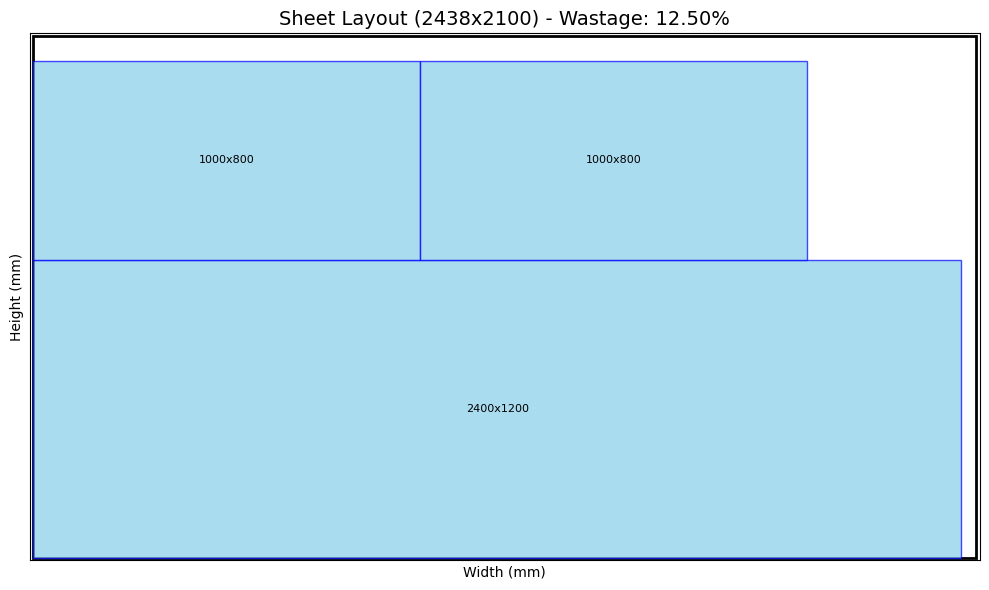

Bin 2: 2438x2100
  Glass Area: 4480000 sq mm
  Wastage: 12.50%


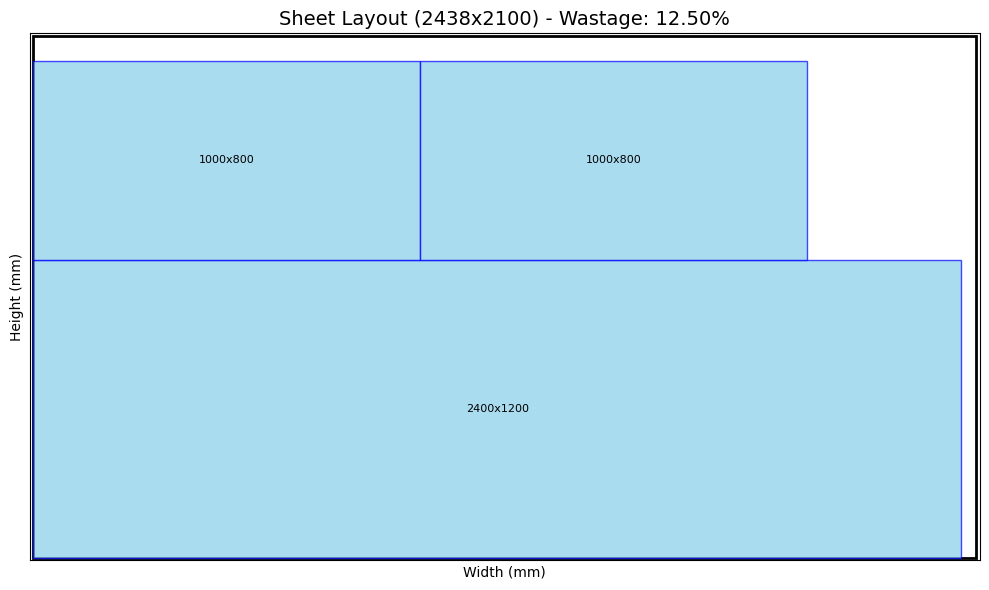

Bin 3: 2438x2100
  Glass Area: 4480000 sq mm
  Wastage: 12.50%


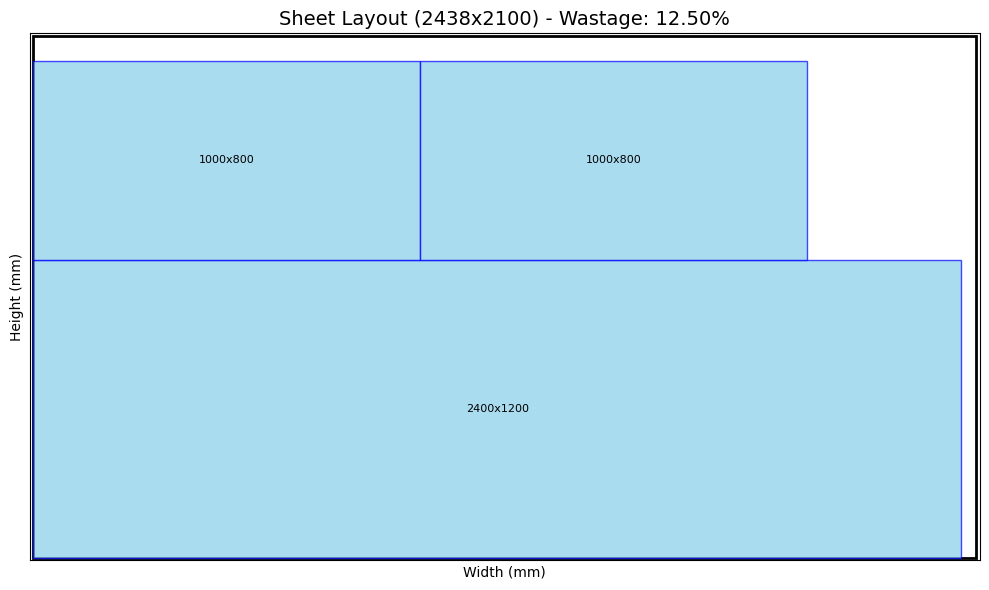

Bin 4: 2438x2100
  Glass Area: 4480000 sq mm
  Wastage: 12.50%


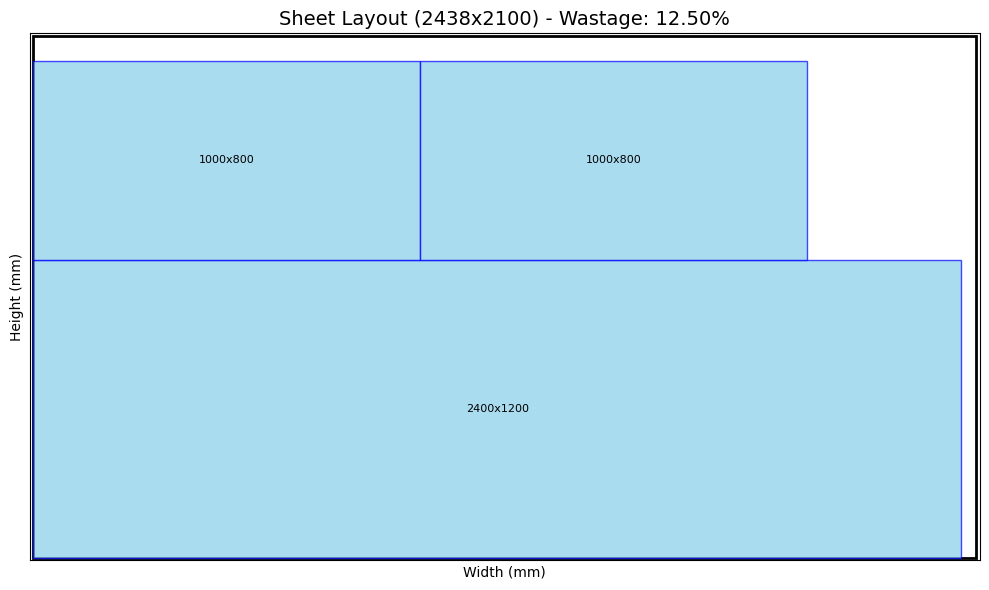

Bin 5: 2438x2100
  Glass Area: 4480000 sq mm
  Wastage: 12.50%


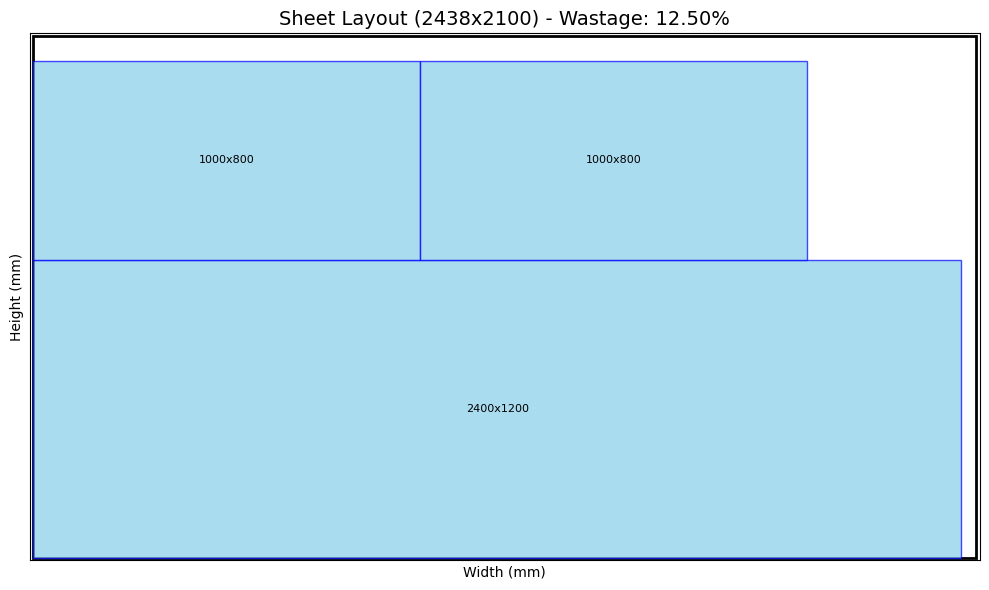

Bin 6: 2438x2100
  Glass Area: 4480000 sq mm
  Wastage: 12.50%


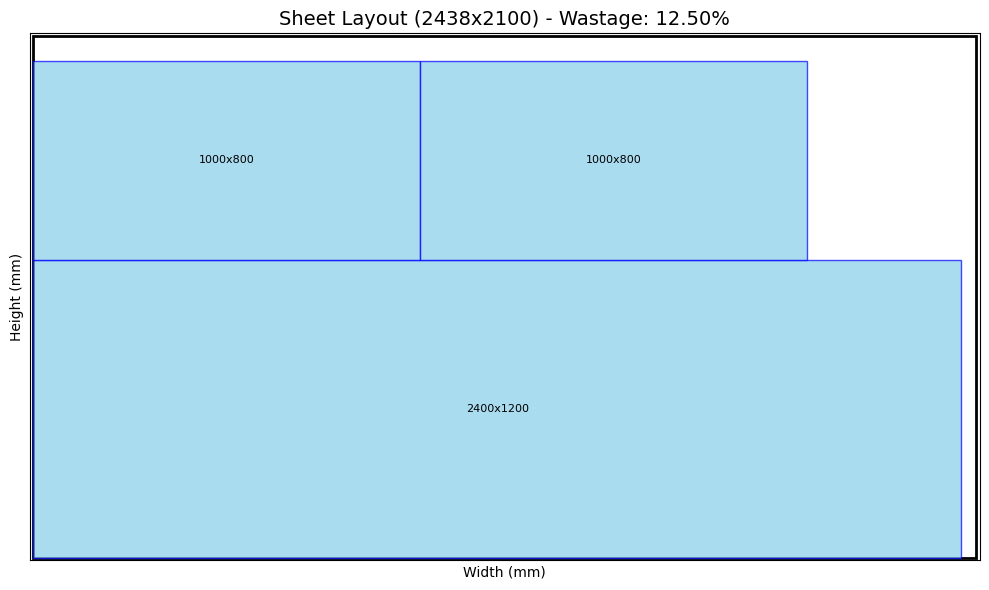

Bin 7: 2438x2100
  Glass Area: 2880000 sq mm
  Wastage: 43.75%


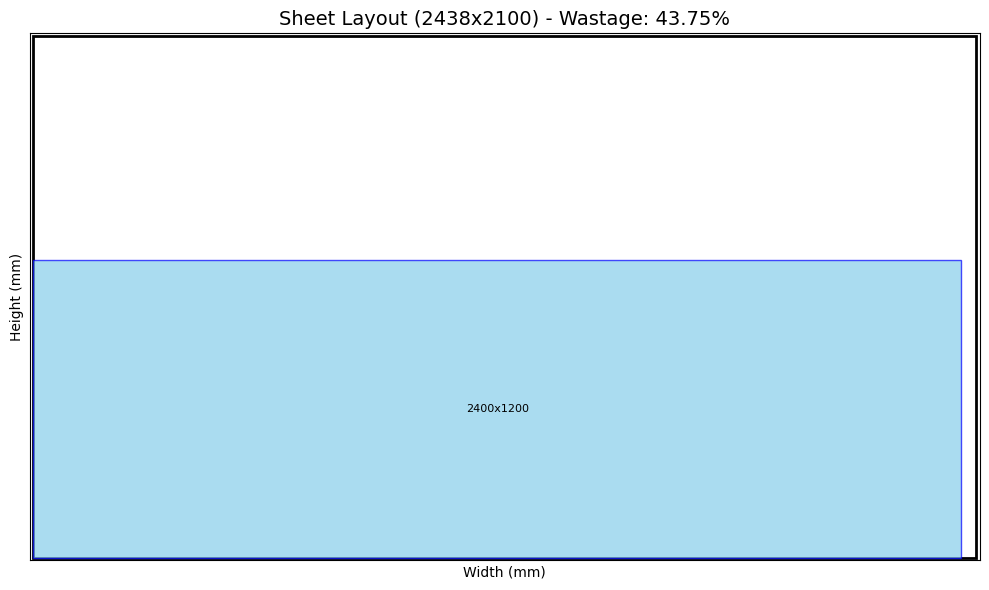

Bin 8: 2438x2100
  Glass Area: 2880000 sq mm
  Wastage: 43.75%


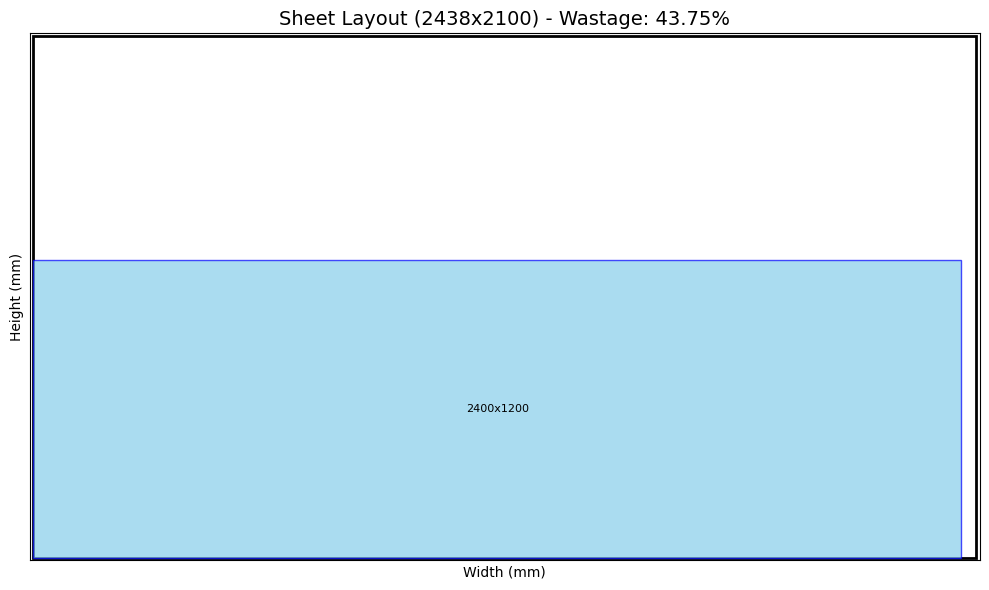

Bin 9: 2438x2100
  Glass Area: 2880000 sq mm
  Wastage: 43.75%


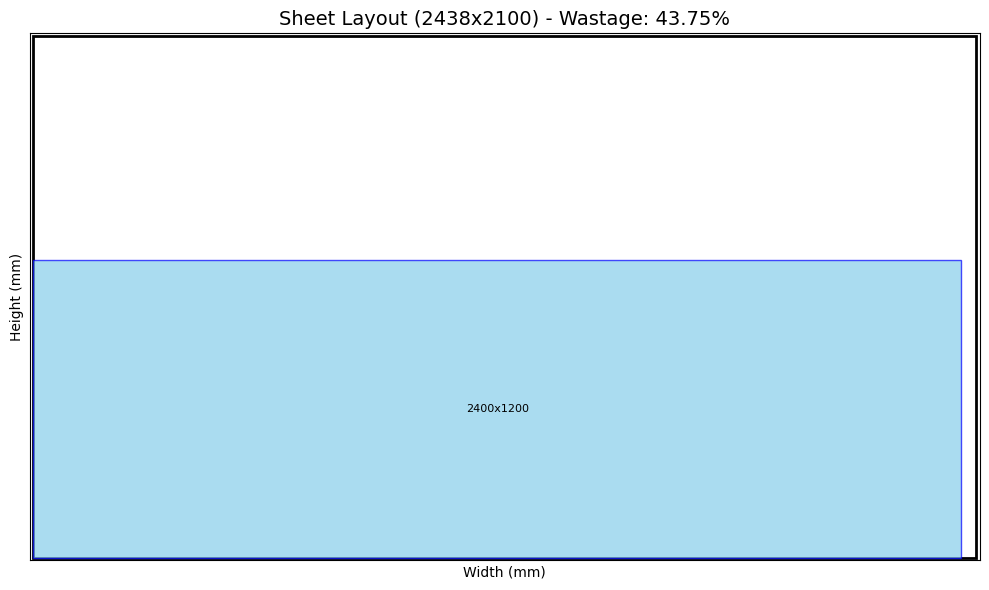

Bin 10: 2438x2100
  Glass Area: 2880000 sq mm
  Wastage: 43.75%


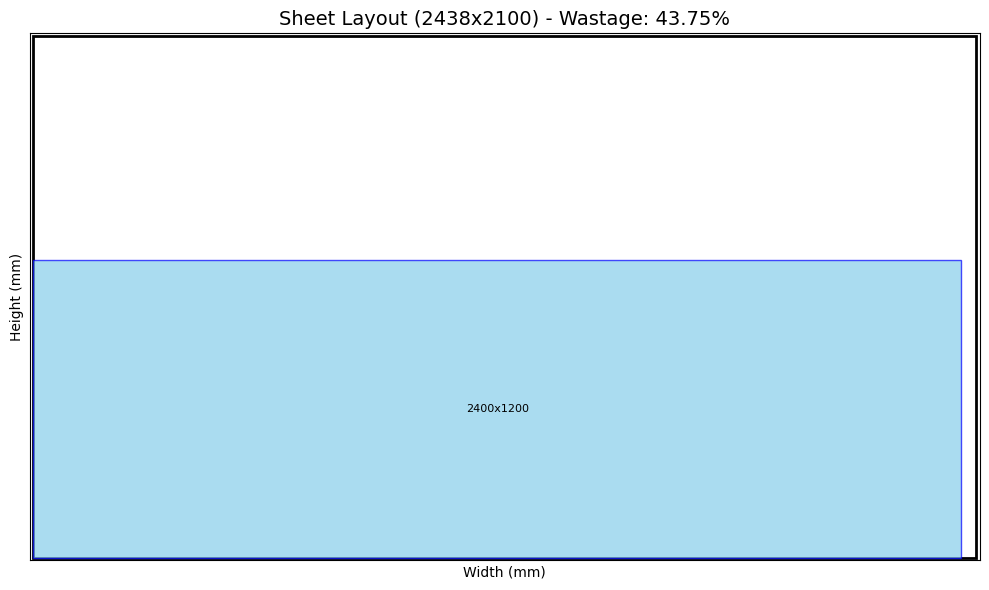

Bin 11: 2438x2100
  Glass Area: 4620000 sq mm
  Wastage: 9.76%


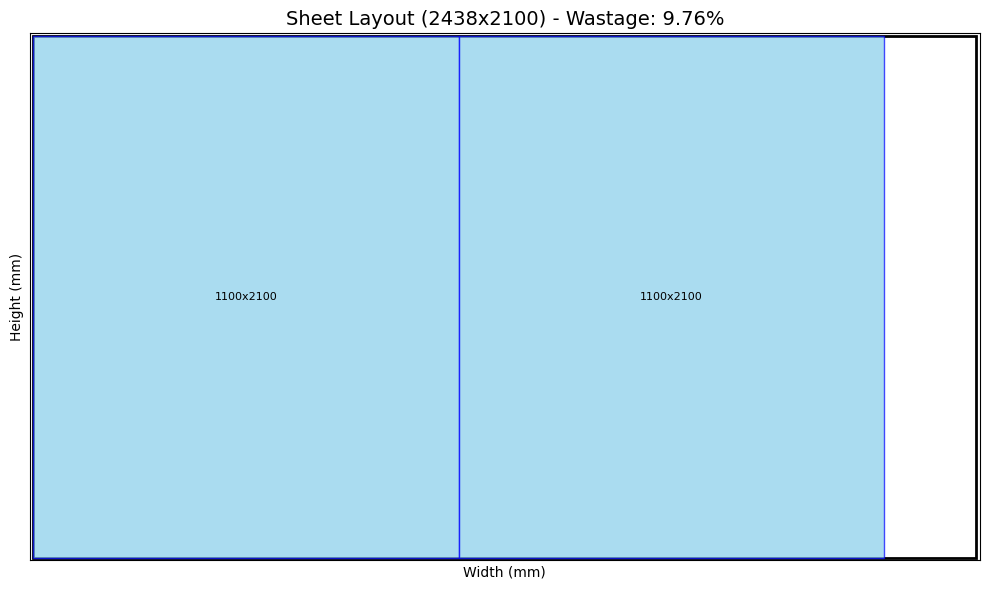

Bin 12: 2438x2100
  Glass Area: 4620000 sq mm
  Wastage: 9.76%


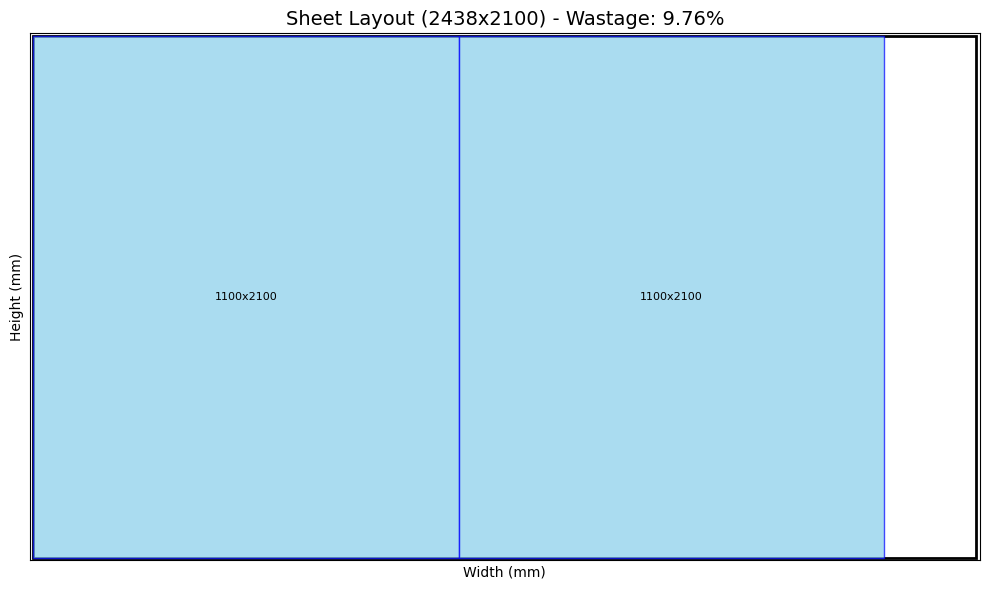

Bin 13: 2438x2100
  Glass Area: 4620000 sq mm
  Wastage: 9.76%


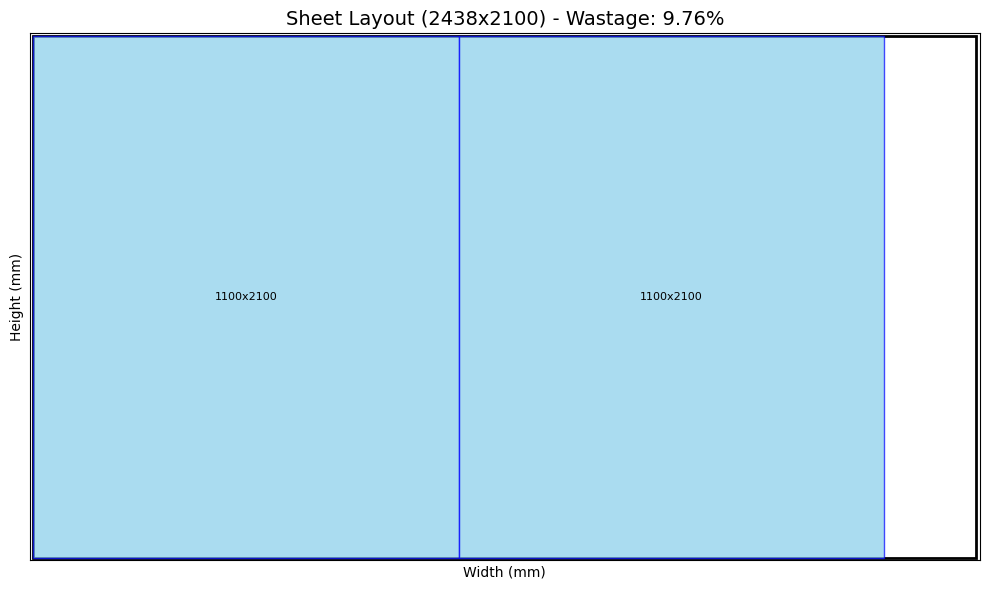

Bin 14: 2438x2100
  Glass Area: 4620000 sq mm
  Wastage: 9.76%


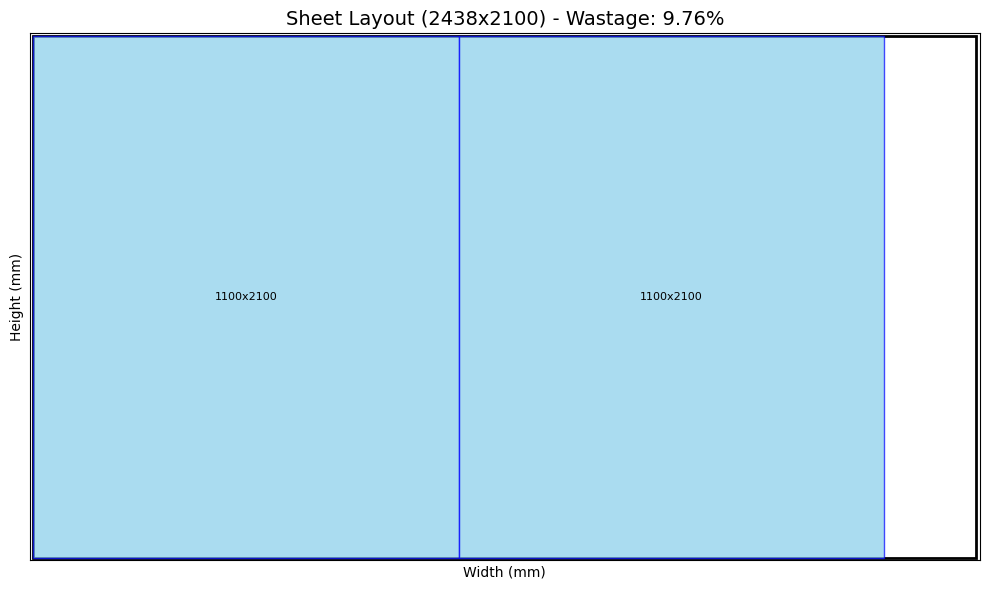

Bin 15: 2438x2100
  Glass Area: 4510000 sq mm
  Wastage: 11.91%


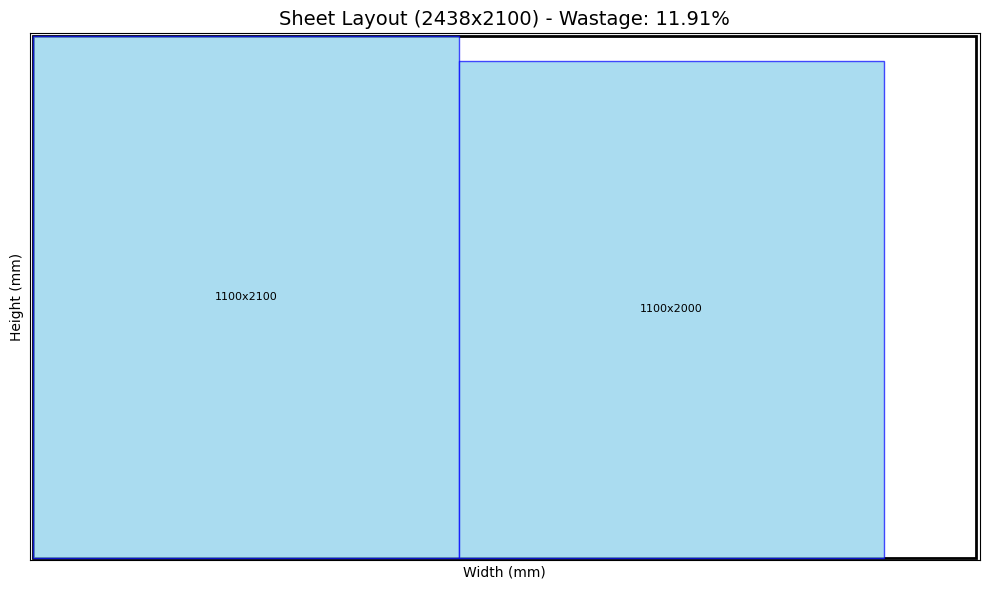

Bin 16: 2438x2100
  Glass Area: 4400000 sq mm
  Wastage: 14.06%


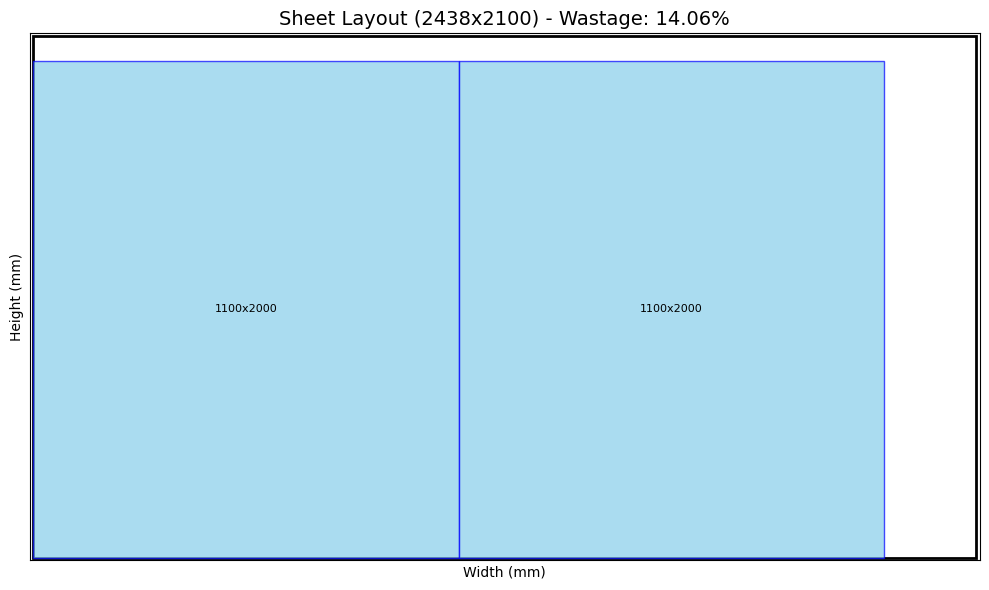

Bin 17: 2438x2100
  Glass Area: 4400000 sq mm
  Wastage: 14.06%


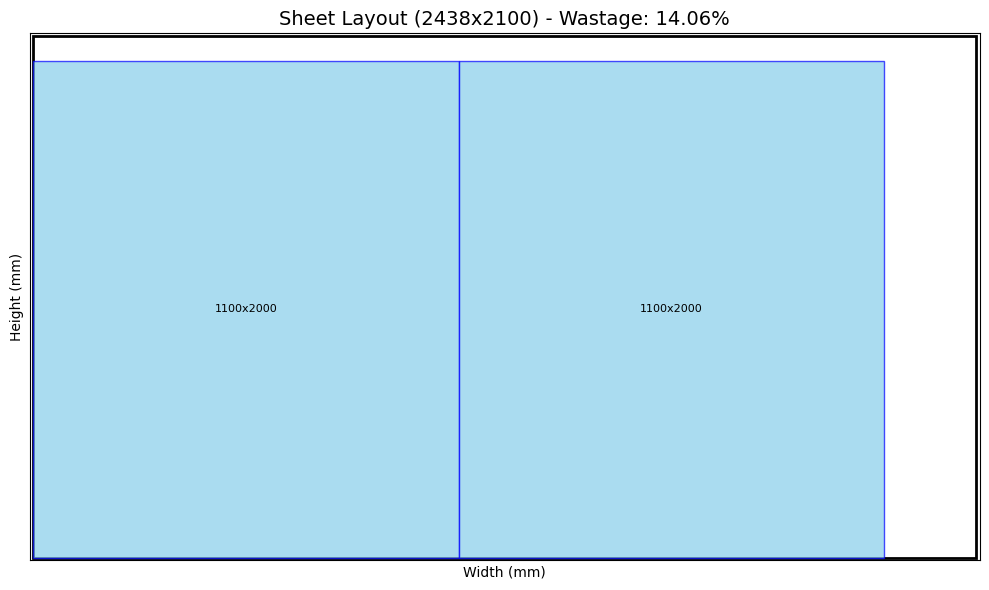

Bin 18: 2438x2100
  Glass Area: 4400000 sq mm
  Wastage: 14.06%


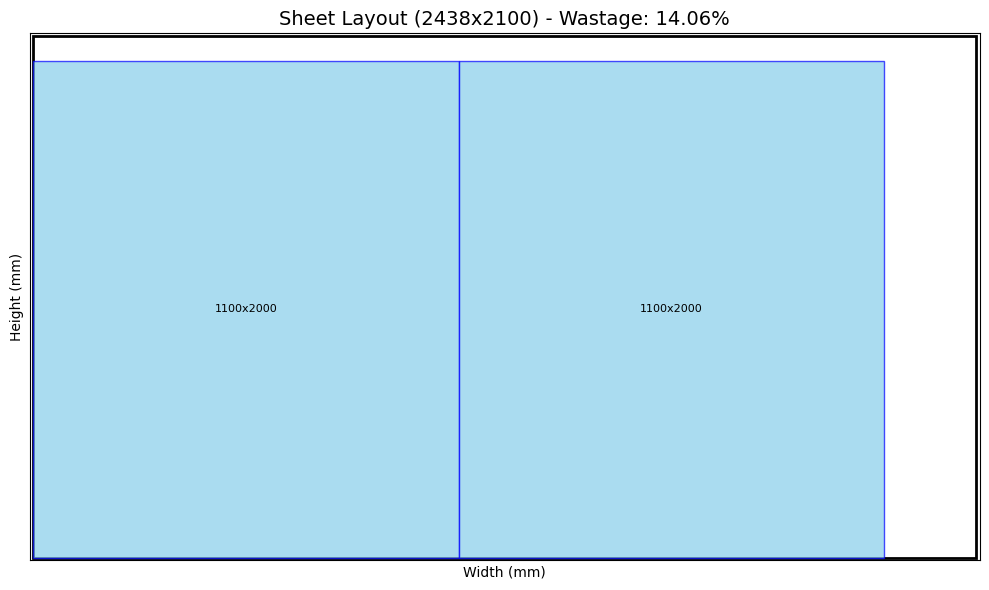

Bin 19: 2438x2100
  Glass Area: 4400000 sq mm
  Wastage: 14.06%


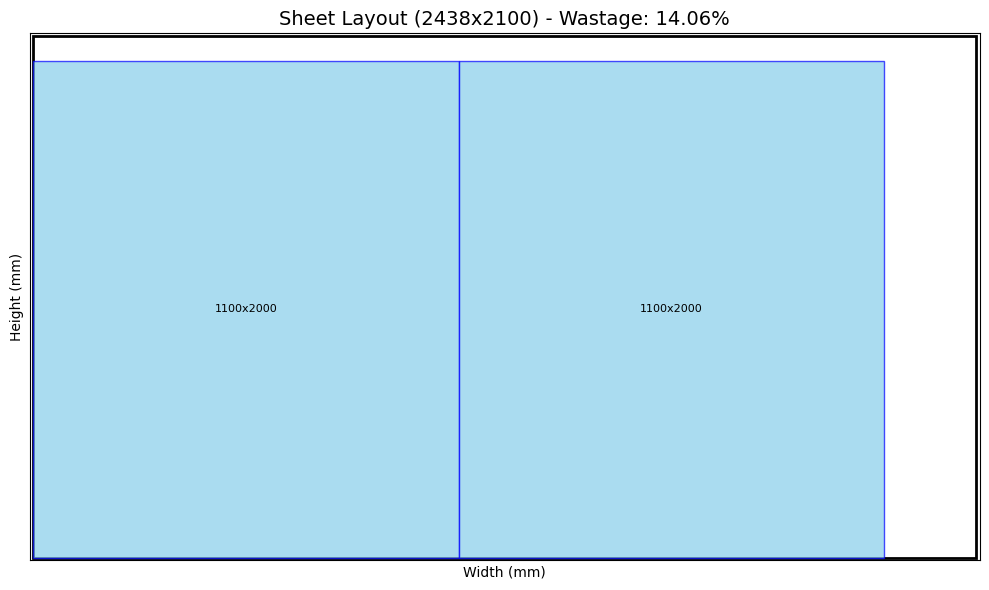

Bin 20: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


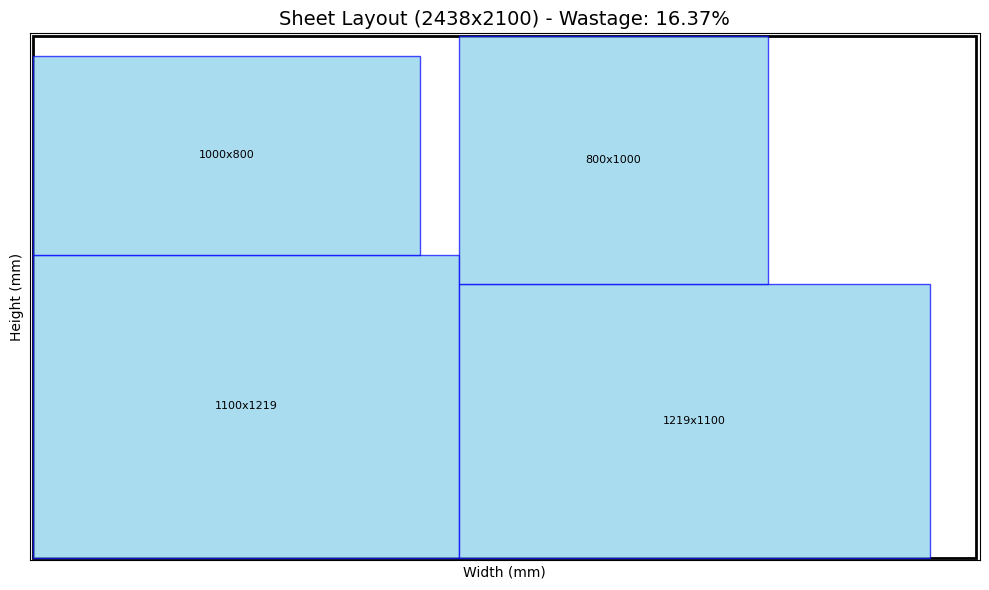

Bin 21: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


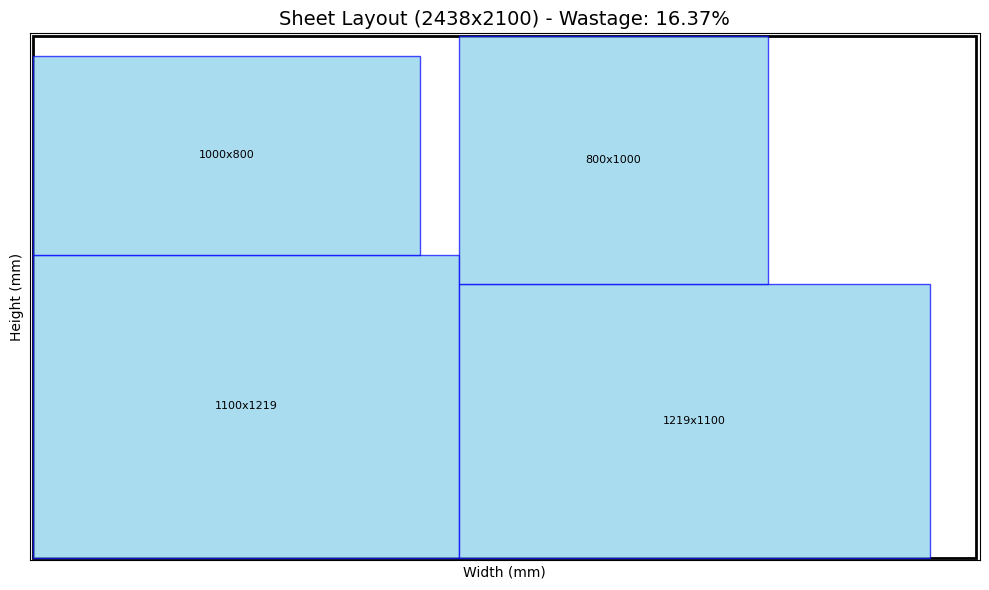

Bin 22: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


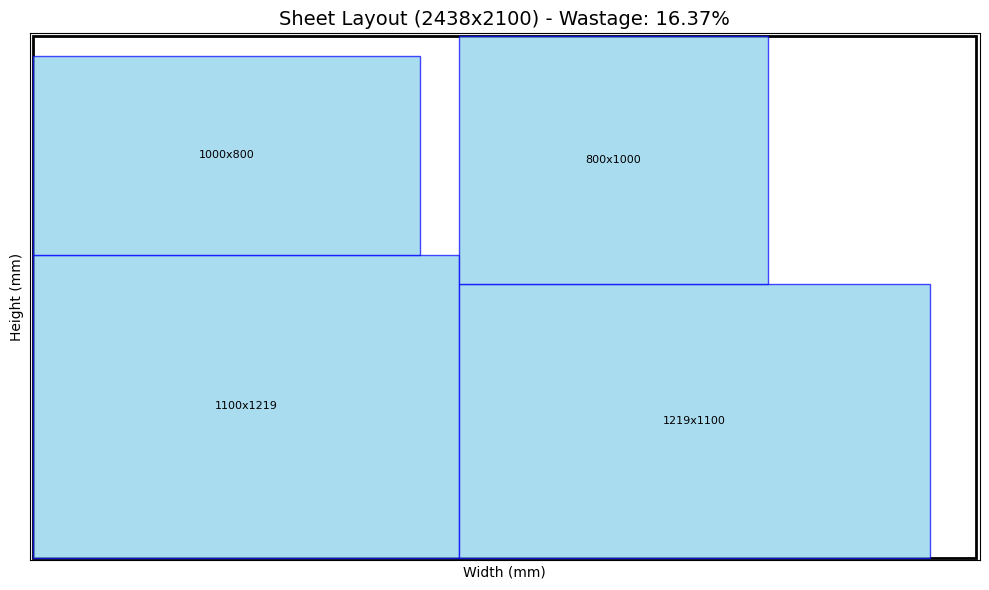

Bin 23: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


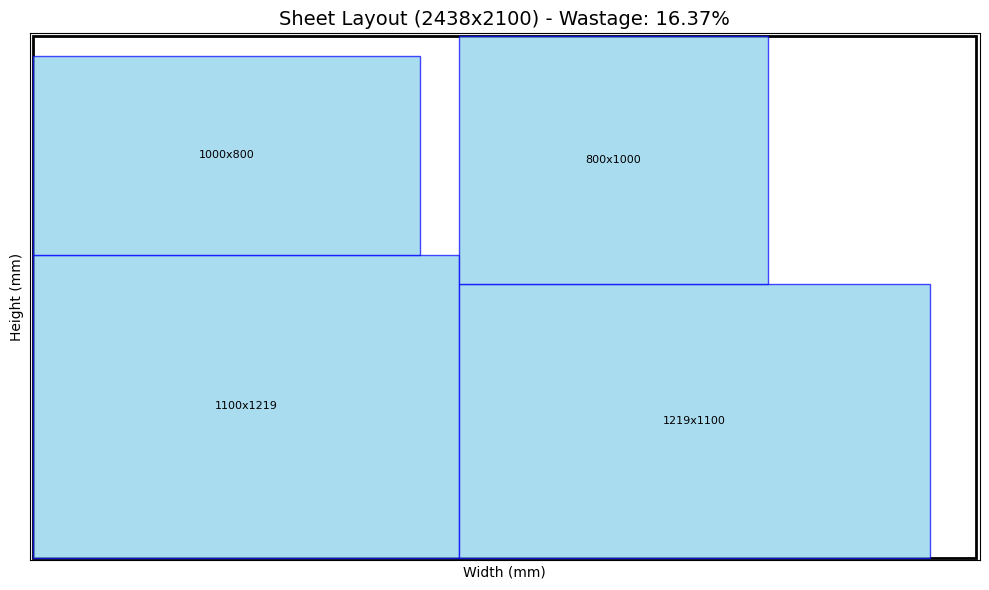

Bin 24: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


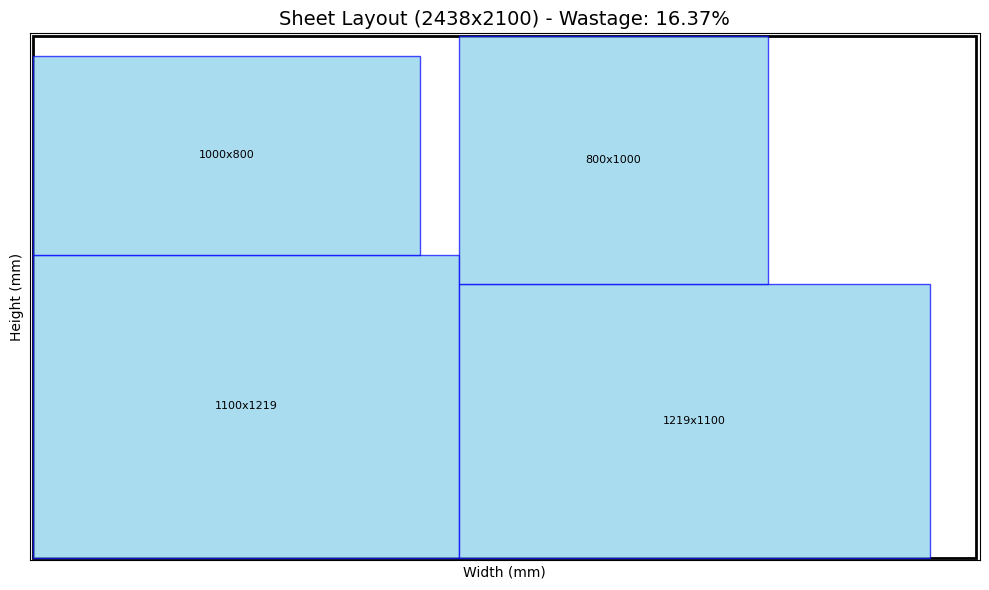

Bin 25: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


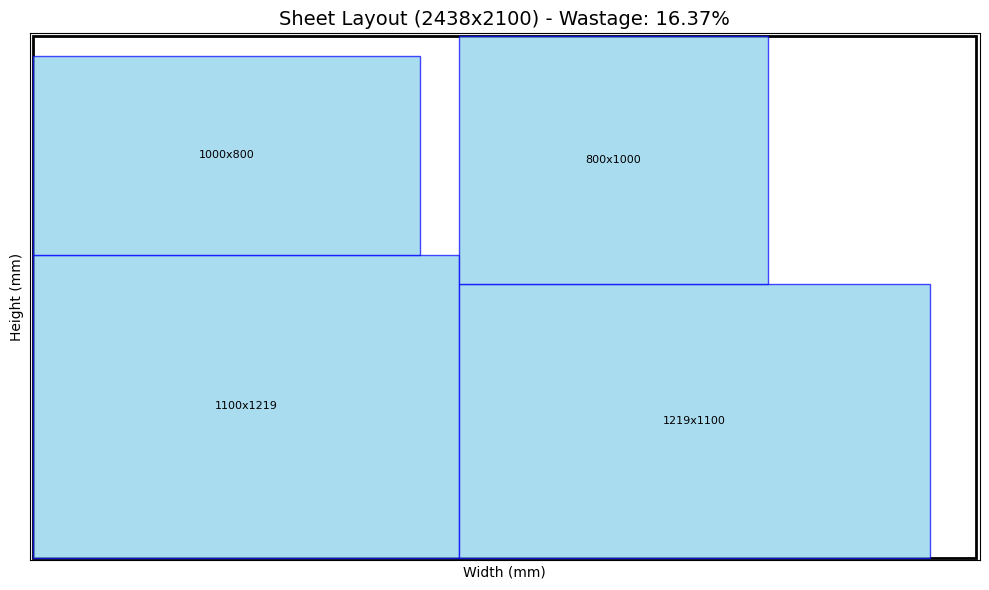

Bin 26: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


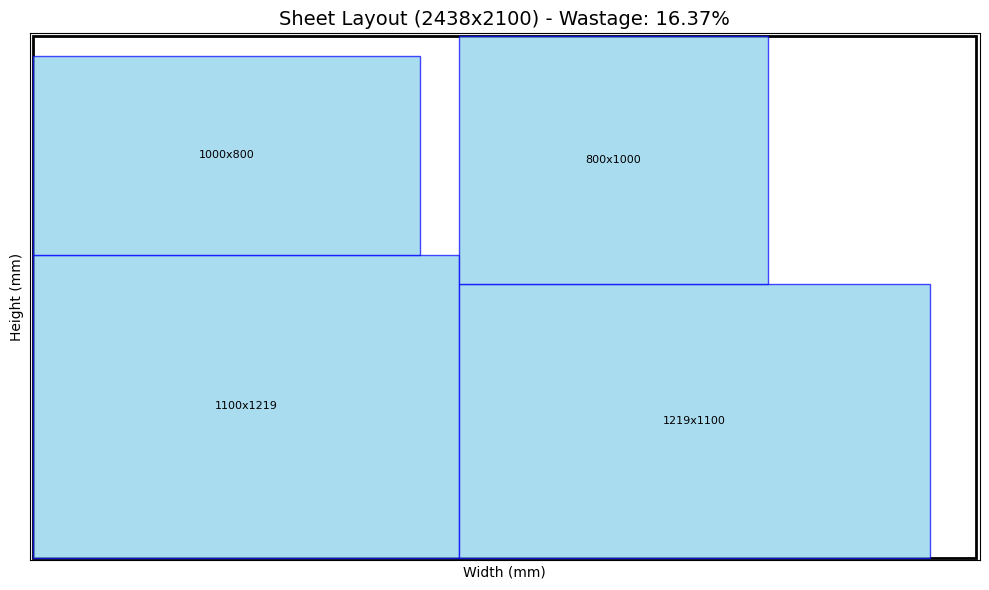

Bin 27: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


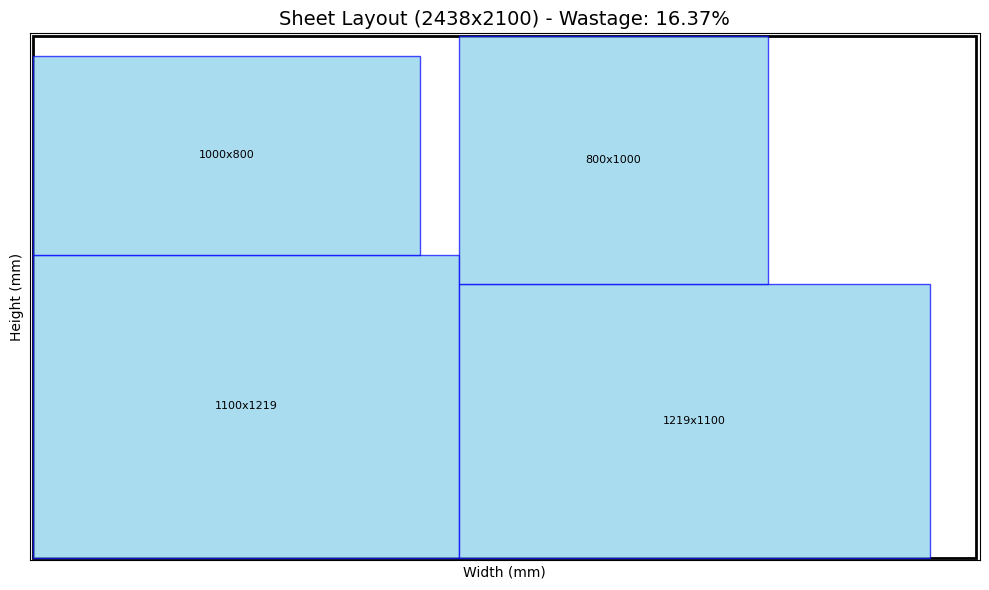

Bin 28: 2438x2100
  Glass Area: 4281800 sq mm
  Wastage: 16.37%


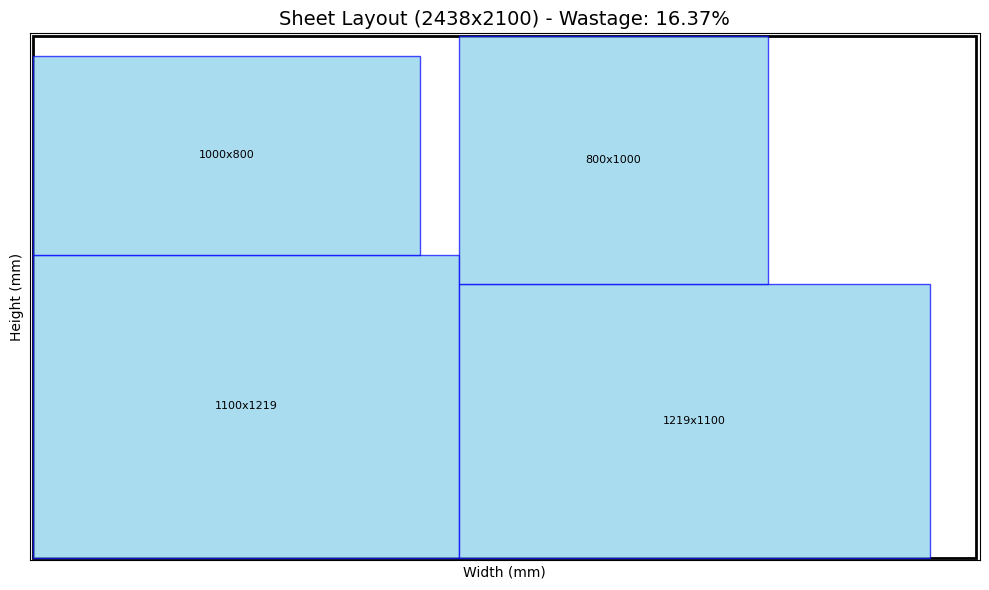

In [15]:
import csv
from rectpack import newPacker
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# File paths
glass_data_file = 'data/glass_data2.csv'
stock_sizes_file = 'data/glass_sheet_size1.csv'

# Load glass data from CSV
def load_glass_data(filepath):
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['glass_length']),
                 'height': int(row['glass_height']),
                 'qty': int(row['glass_qty'])} for row in reader]

# Load stock sizes from CSV
def load_stock_sizes(filepath):
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']),
                 'width': int(row['width']),
                 'qty': int(row['qty'])} for row in reader]

# Expand parts based on quantity
def expand_parts(glass_parts):
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([(part['length'], part['height']) for _ in range(part['qty'])])
    return expanded_parts

# Visualization function
def plot_layout(bin_size, placements, wastage):
    sheet_width, sheet_height = bin_size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw sheet
    ax.add_patch(patches.Rectangle((0, 0), sheet_width, sheet_height, edgecolor='black', fill=False, linewidth=2))

    # Draw rectangles
    for placement in placements:
        x, y, width, height = placement
        ax.add_patch(patches.Rectangle((x, y), width, height, edgecolor='blue', facecolor='skyblue', alpha=0.7))
        ax.text(x + width / 2, y + height / 2, f"{width}x{height}", ha='center', va='center', fontsize=8)

    # Display dimensions and wastage
    ax.set_title(f"Sheet Layout ({sheet_width}x{sheet_height}) - Wastage: {wastage:.2f}%", fontsize=14)
    ax.set_xlim(-10, sheet_width + 10)
    ax.set_ylim(-10, sheet_height + 10)
    ax.set_xlabel("Width (mm)")
    ax.set_ylabel("Height (mm)")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Optimization function
def optimize_glass_cutting(glass_data_file, stock_sizes_file):
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)

    # Expand glass parts based on quantity
    rectangles = expand_parts(glass_parts)

    # Prepare bins
    bins = [(size['length'], size['width']) for size in stock_sizes for _ in range(size['qty'])]

    # Create packer
    packer = newPacker(rotation=True)

    # Add rectangles and bins
    for r in rectangles:
        packer.add_rect(*r)
    for b in bins:
        packer.add_bin(*b)

    # Pack rectangles
    packer.pack()

    # Analyze results
    for i, abin in enumerate(packer):
        bin_width, bin_height = abin.width, abin.height
        placements = [(rect.x, rect.y, rect.width, rect.height) for rect in abin]
        total_glass_area = sum(rect.width * rect.height for rect in abin)
        total_bin_area = bin_width * bin_height
        wastage = 100 - (total_glass_area / total_bin_area * 100)

        print(f"Bin {i+1}: {bin_width}x{bin_height}")
        print(f"  Glass Area: {total_glass_area} sq mm")
        print(f"  Wastage: {wastage:.2f}%")
        plot_layout((bin_width, bin_height), placements, wastage)

# Run the optimization
optimize_glass_cutting(glass_data_file, stock_sizes_file)


Total stock area: 143.354 sq m
Total glass area: 117.526 sq m
Total sheets used: 28
Used area percentage: 81.98%
Wastage percentage: 18.02%

Summary of sheet sizes used:
  2438mm x 2100mm: 28 pcs


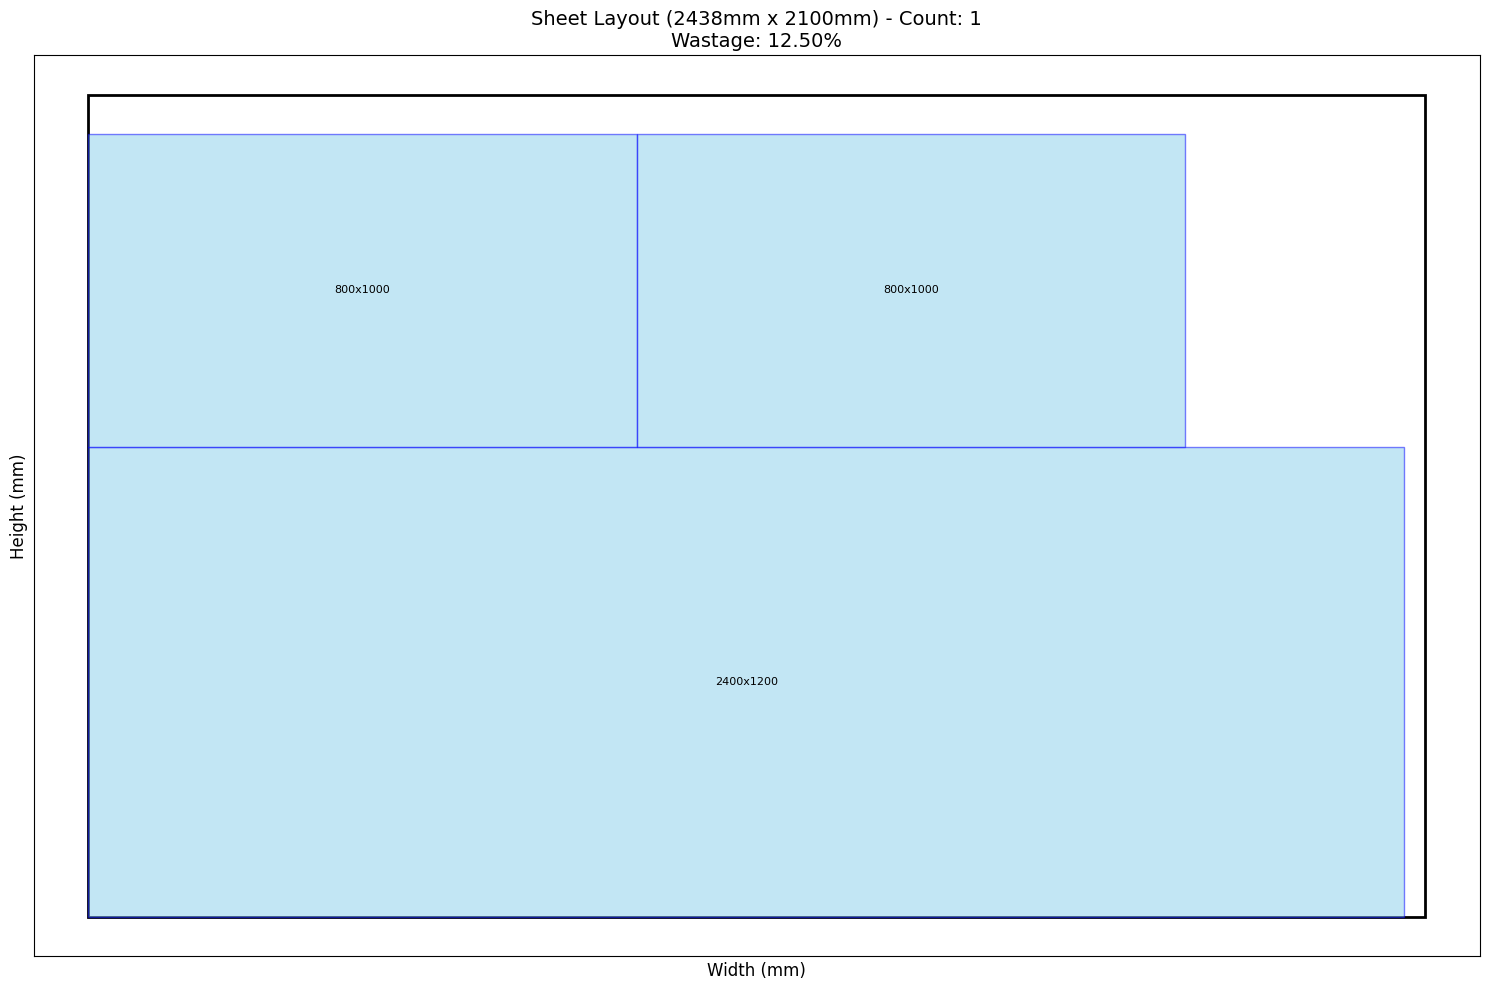

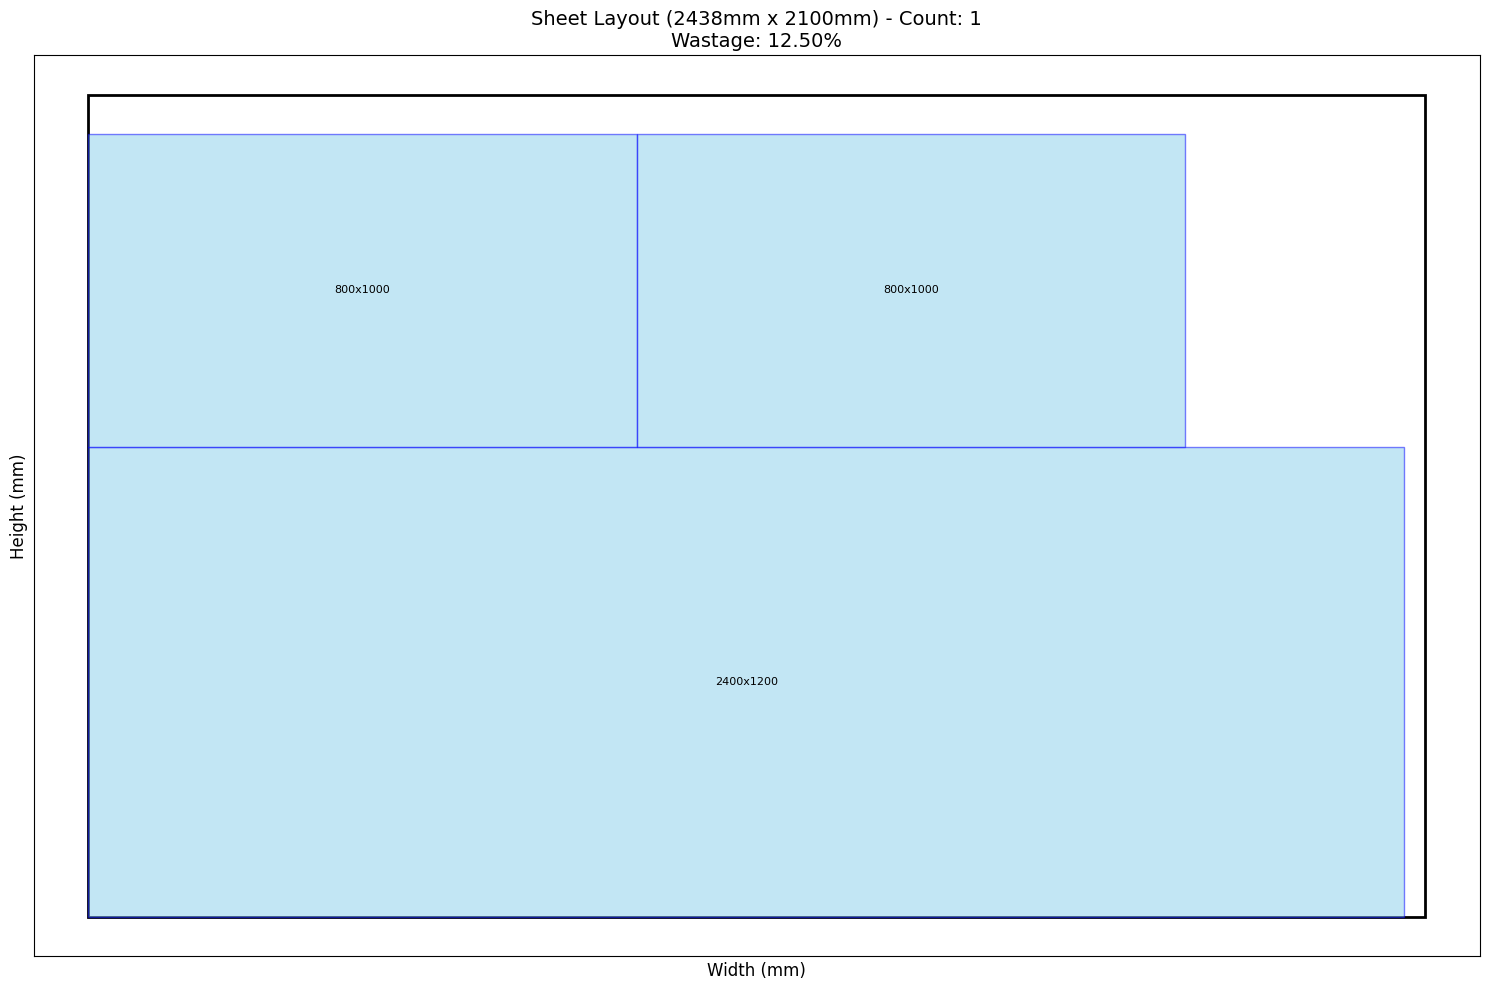

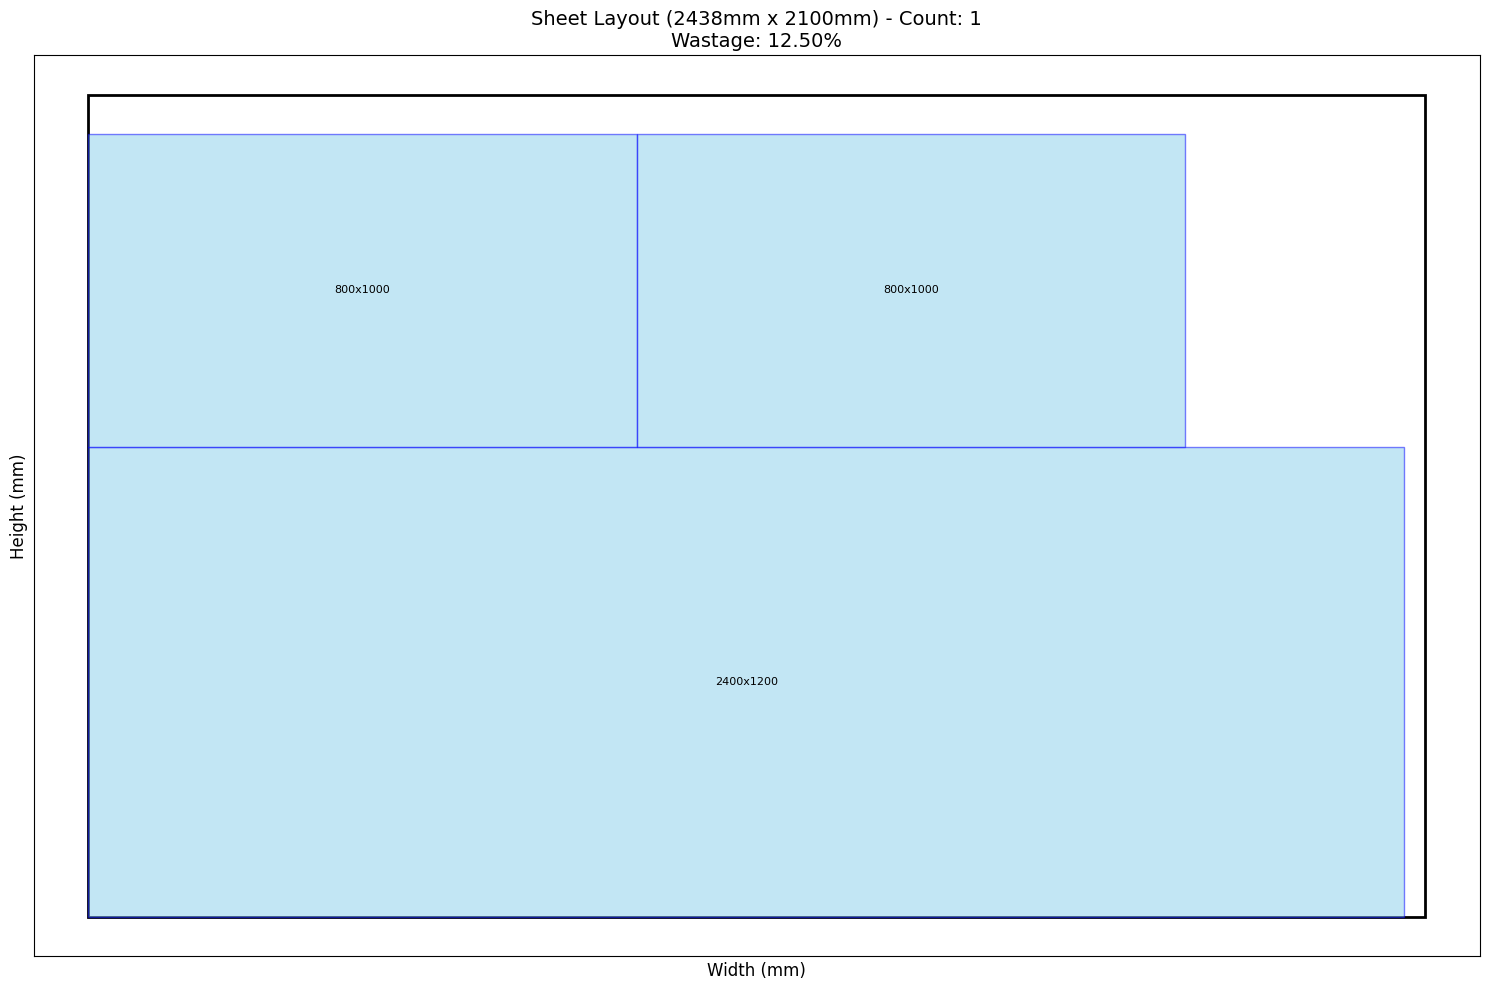

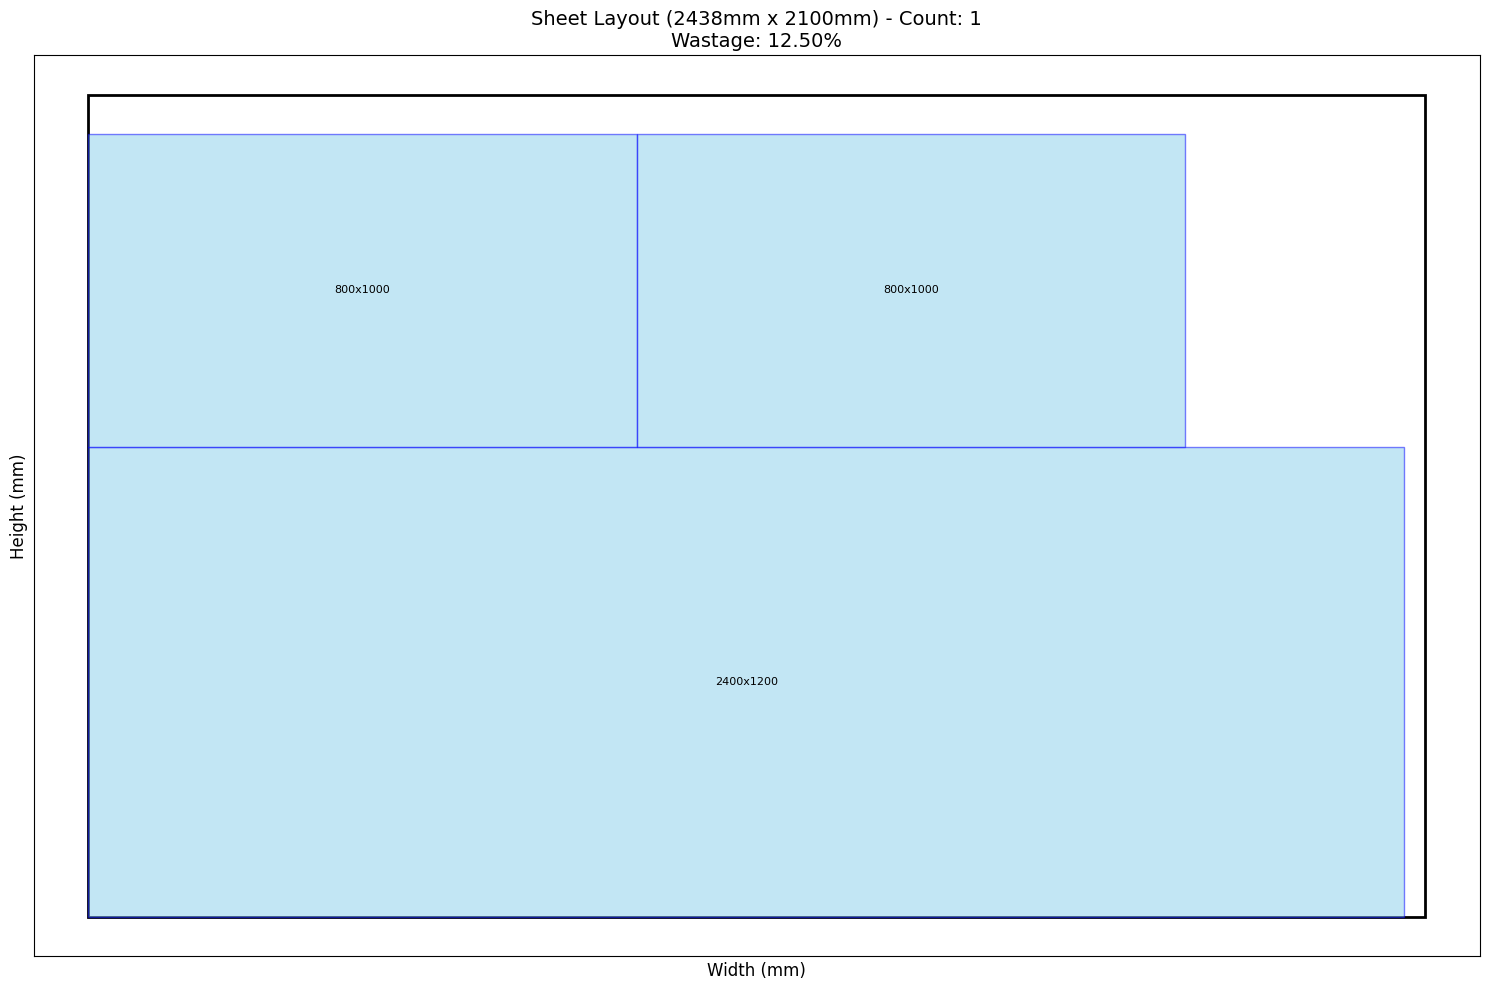

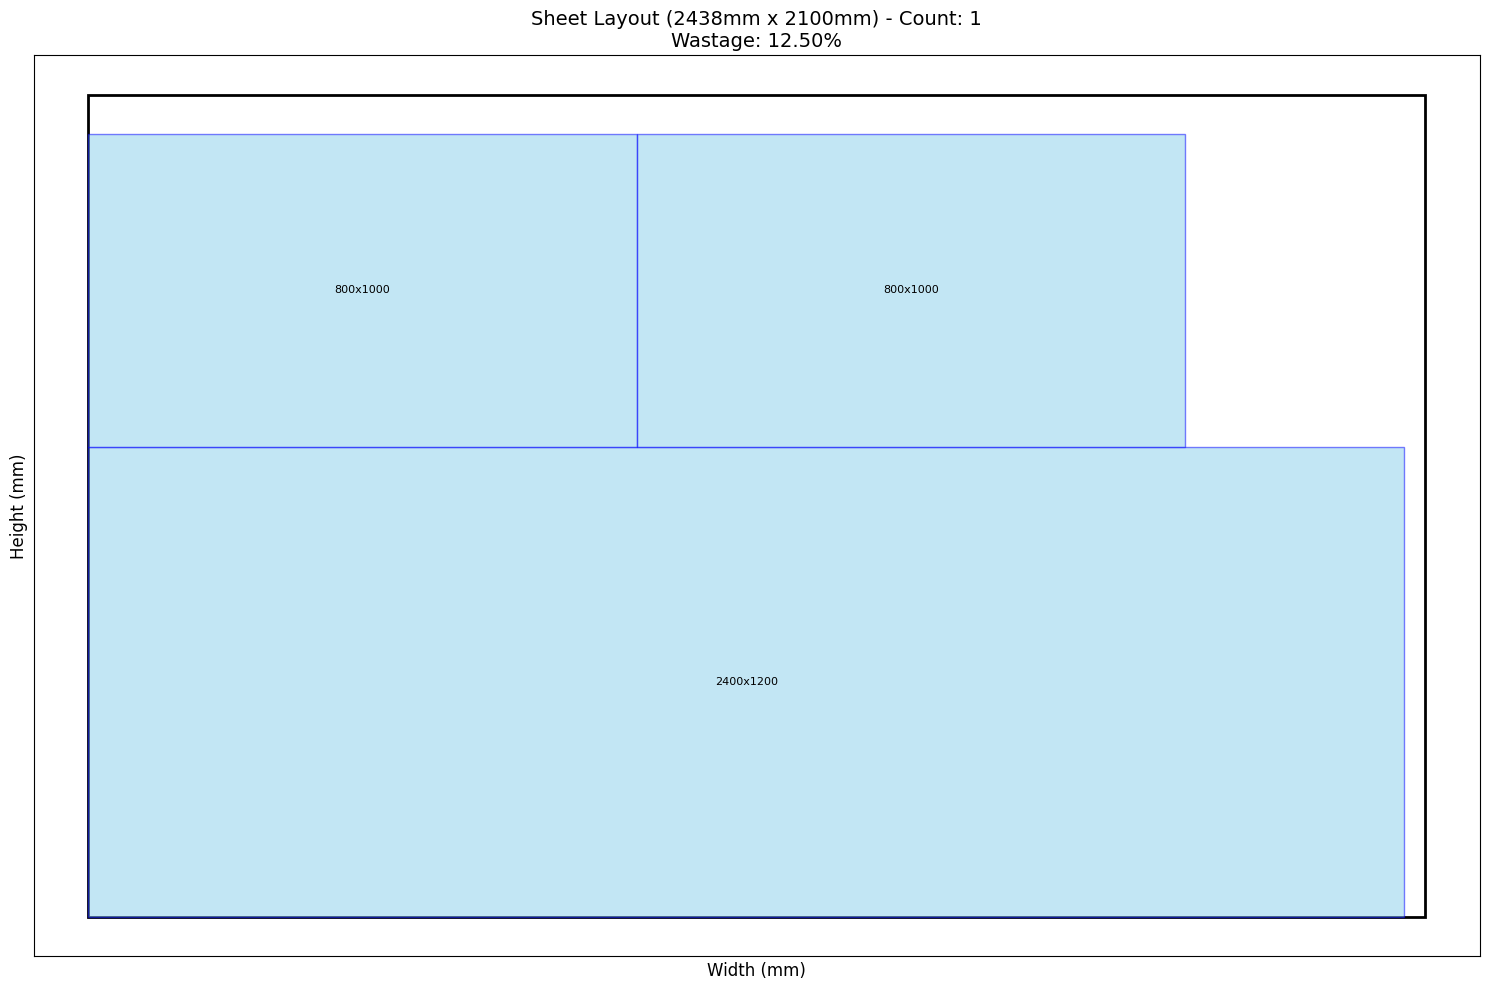

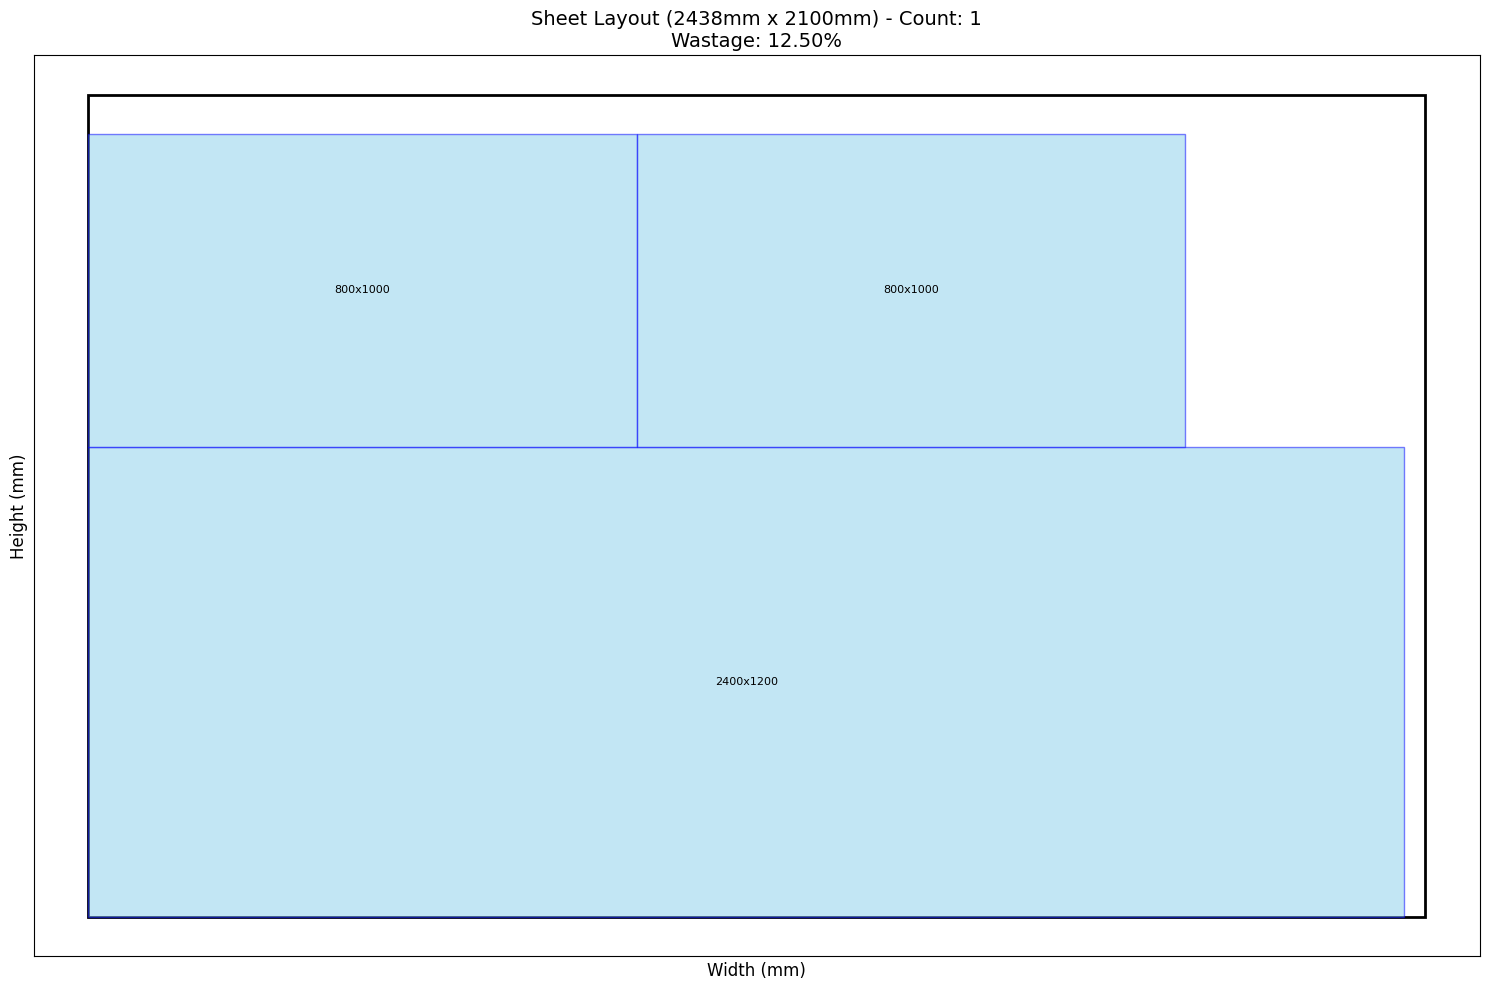

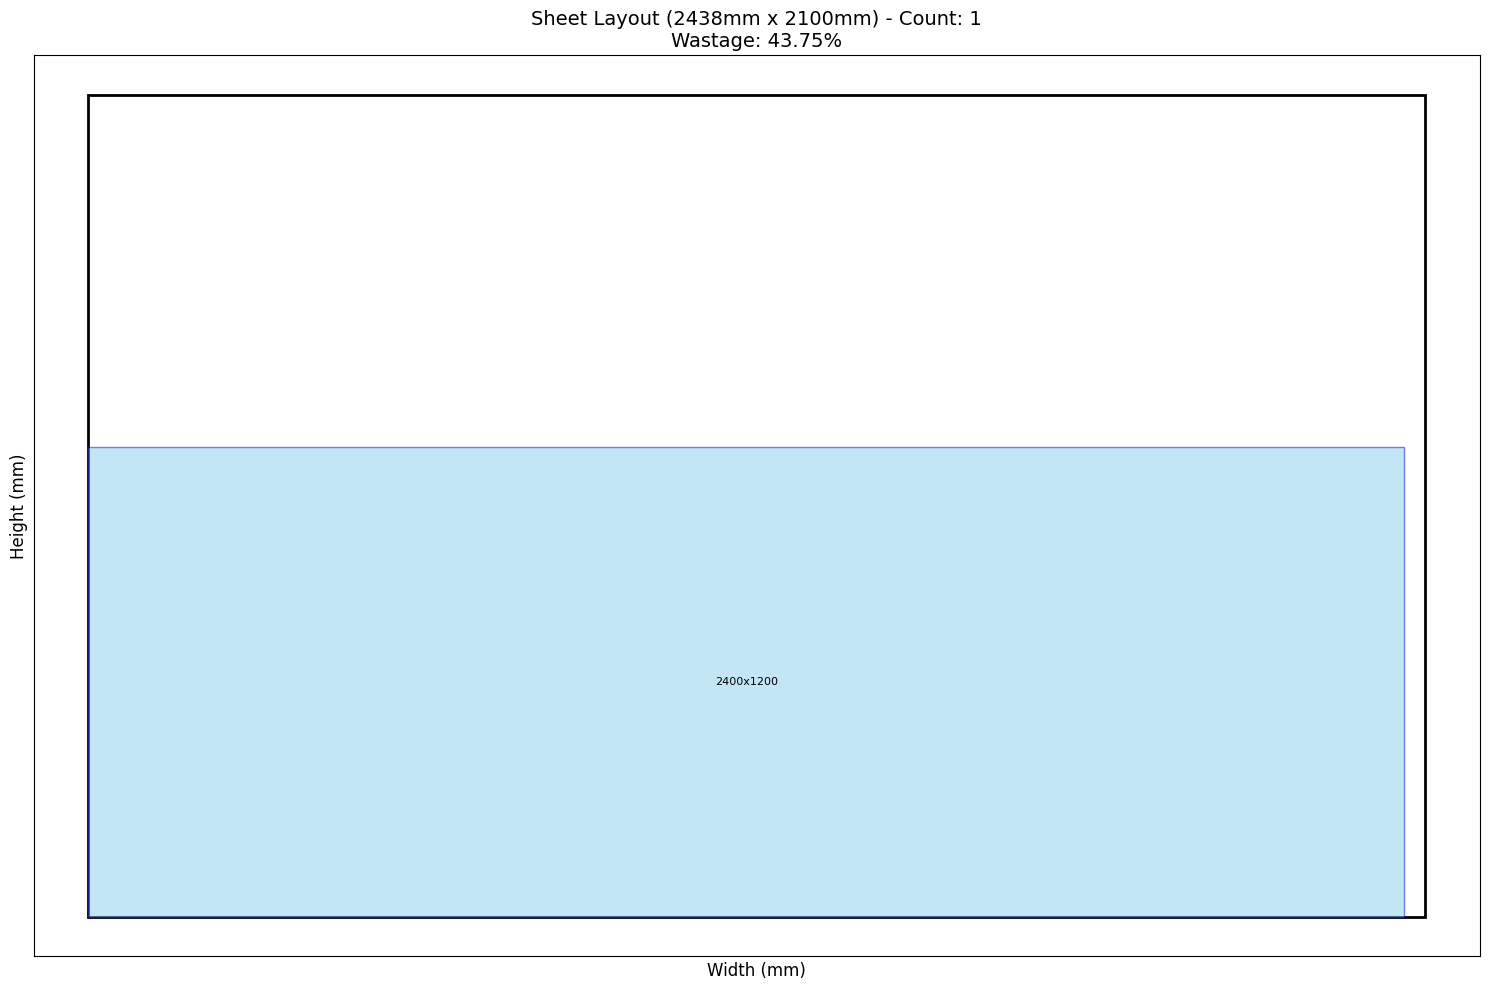

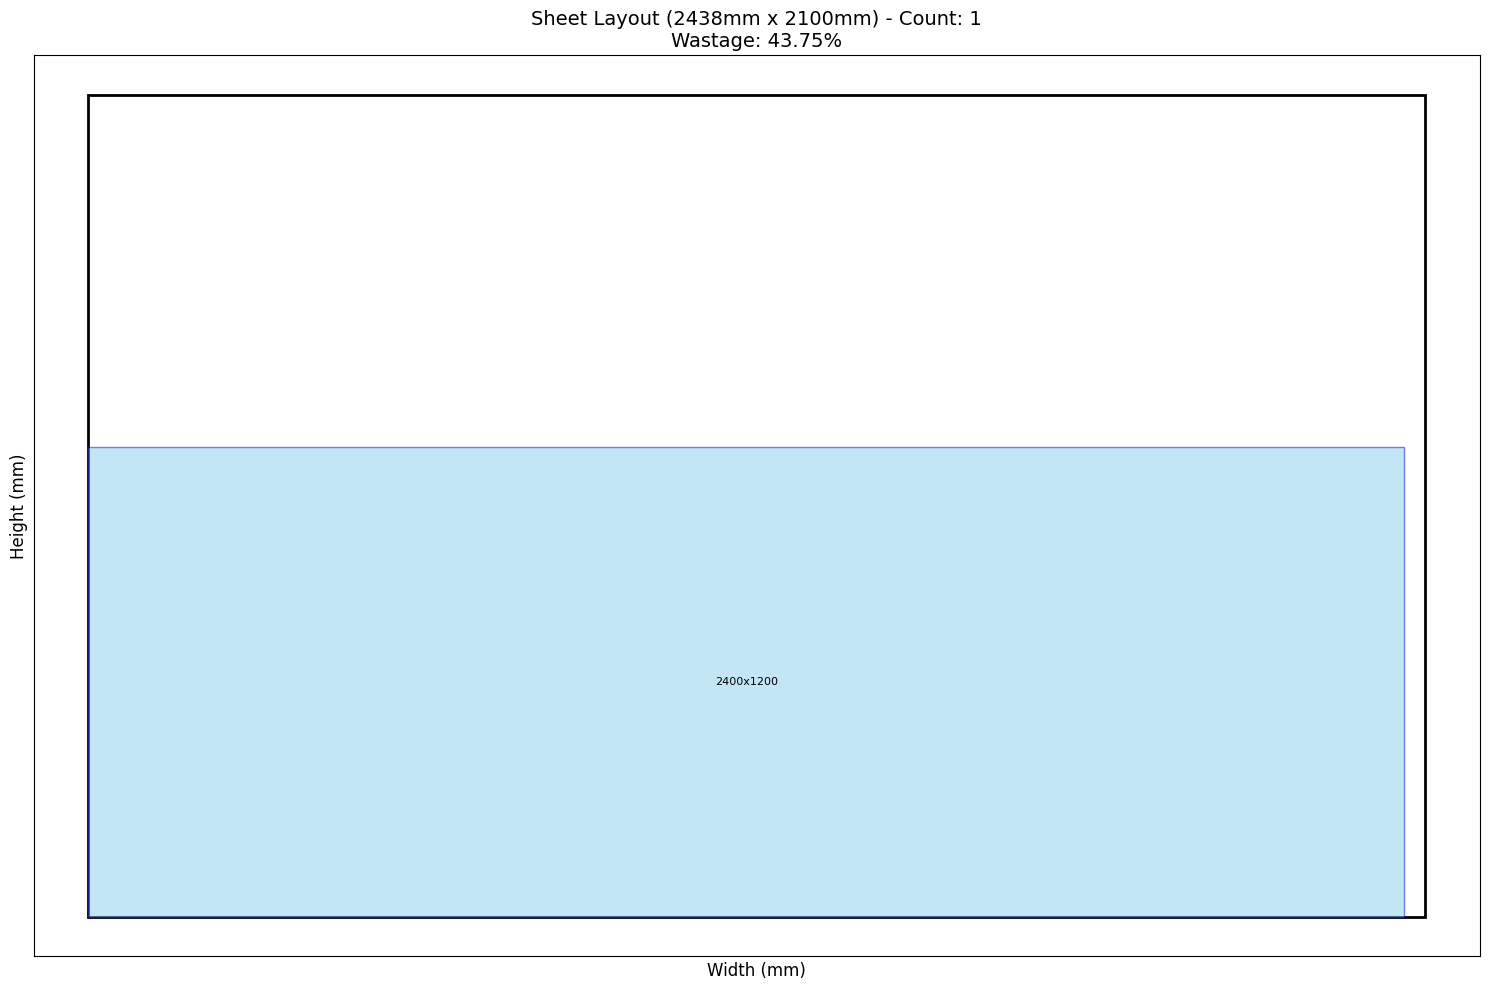

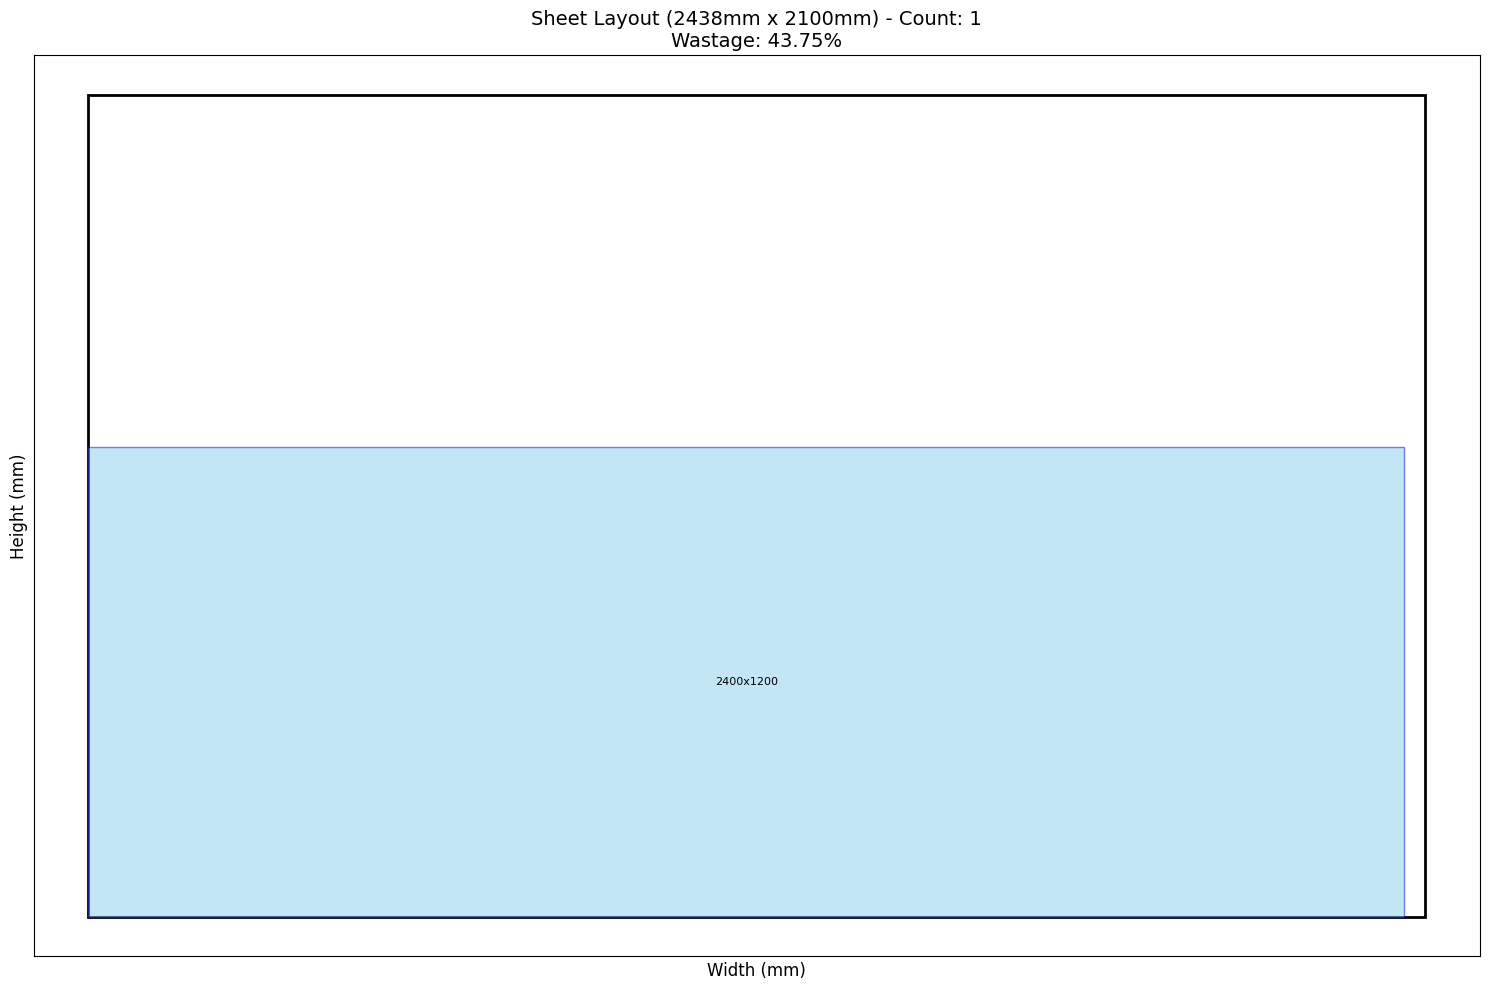

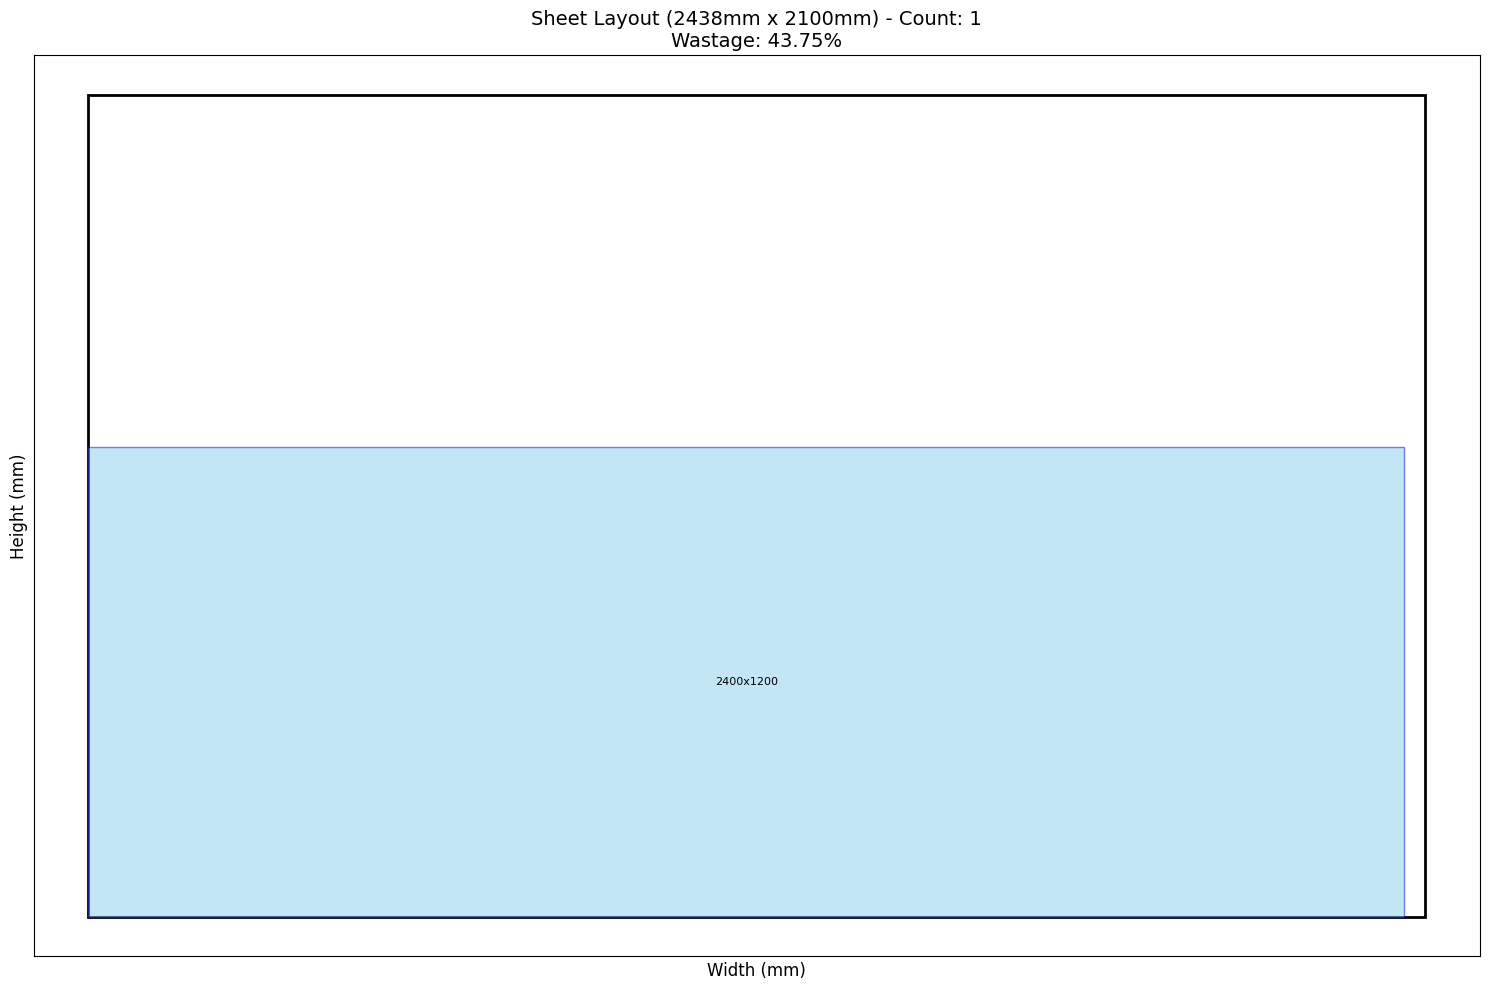

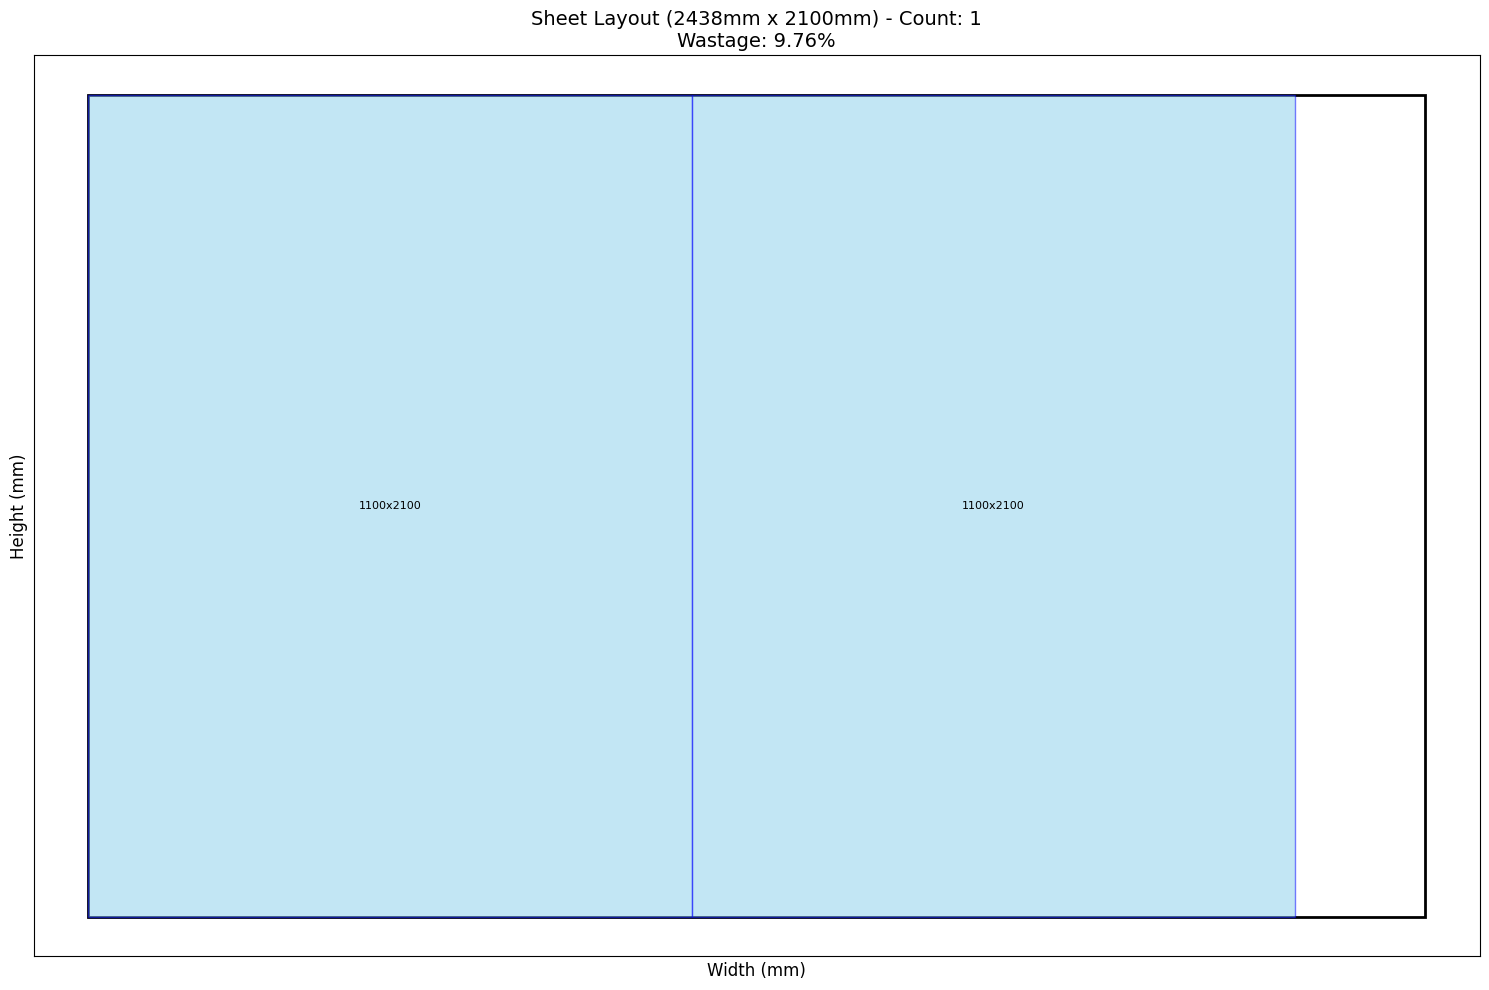

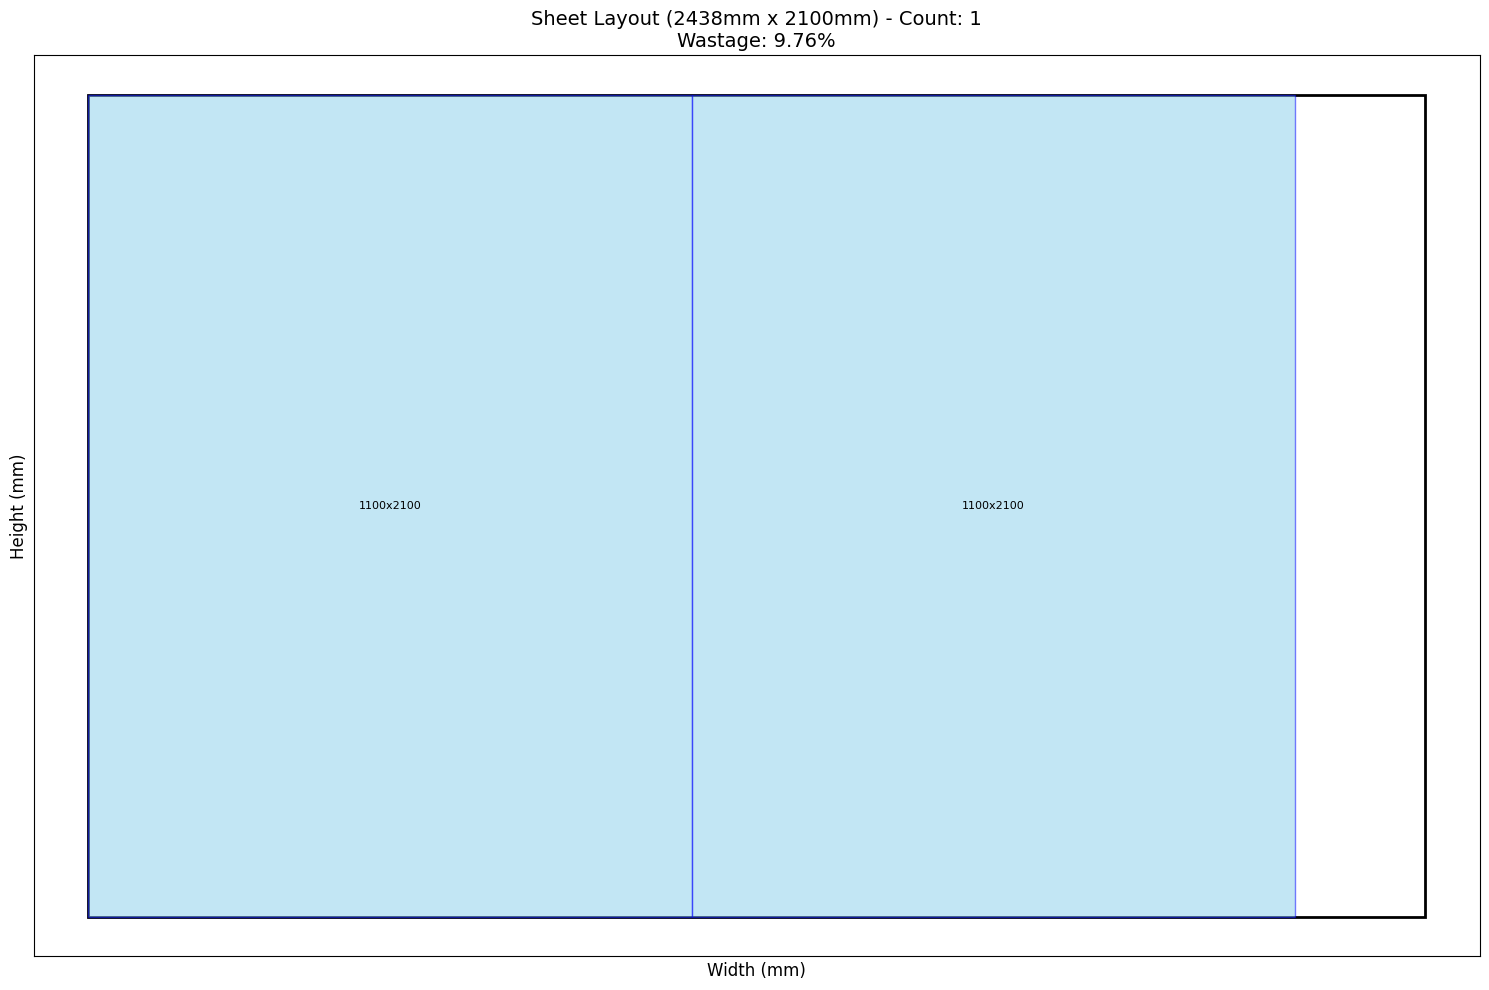

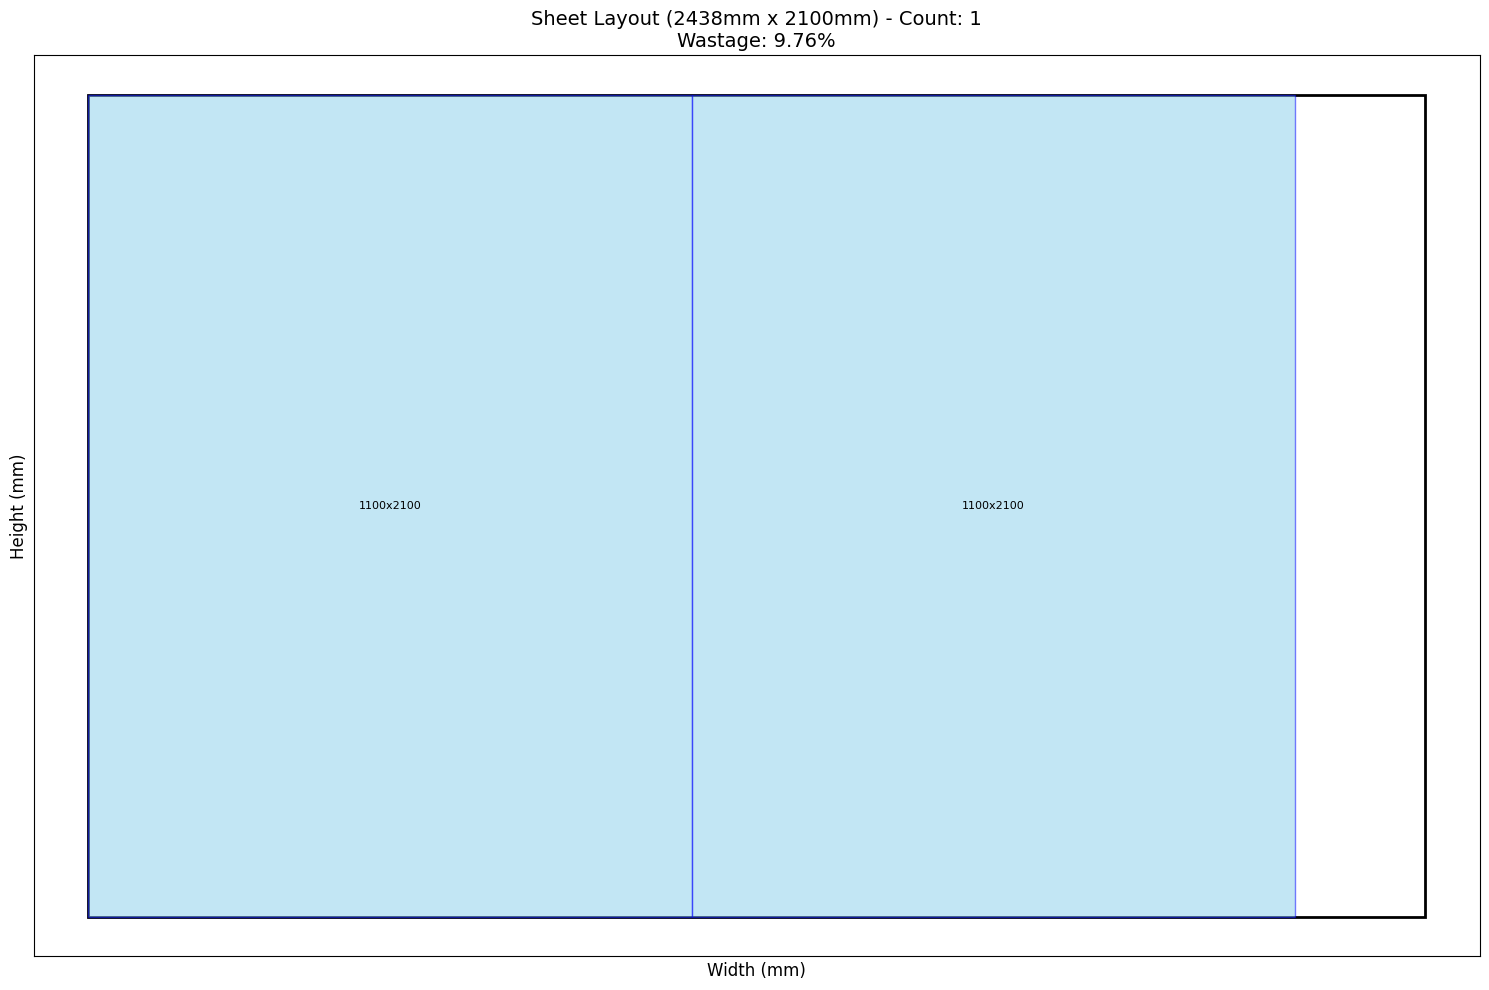

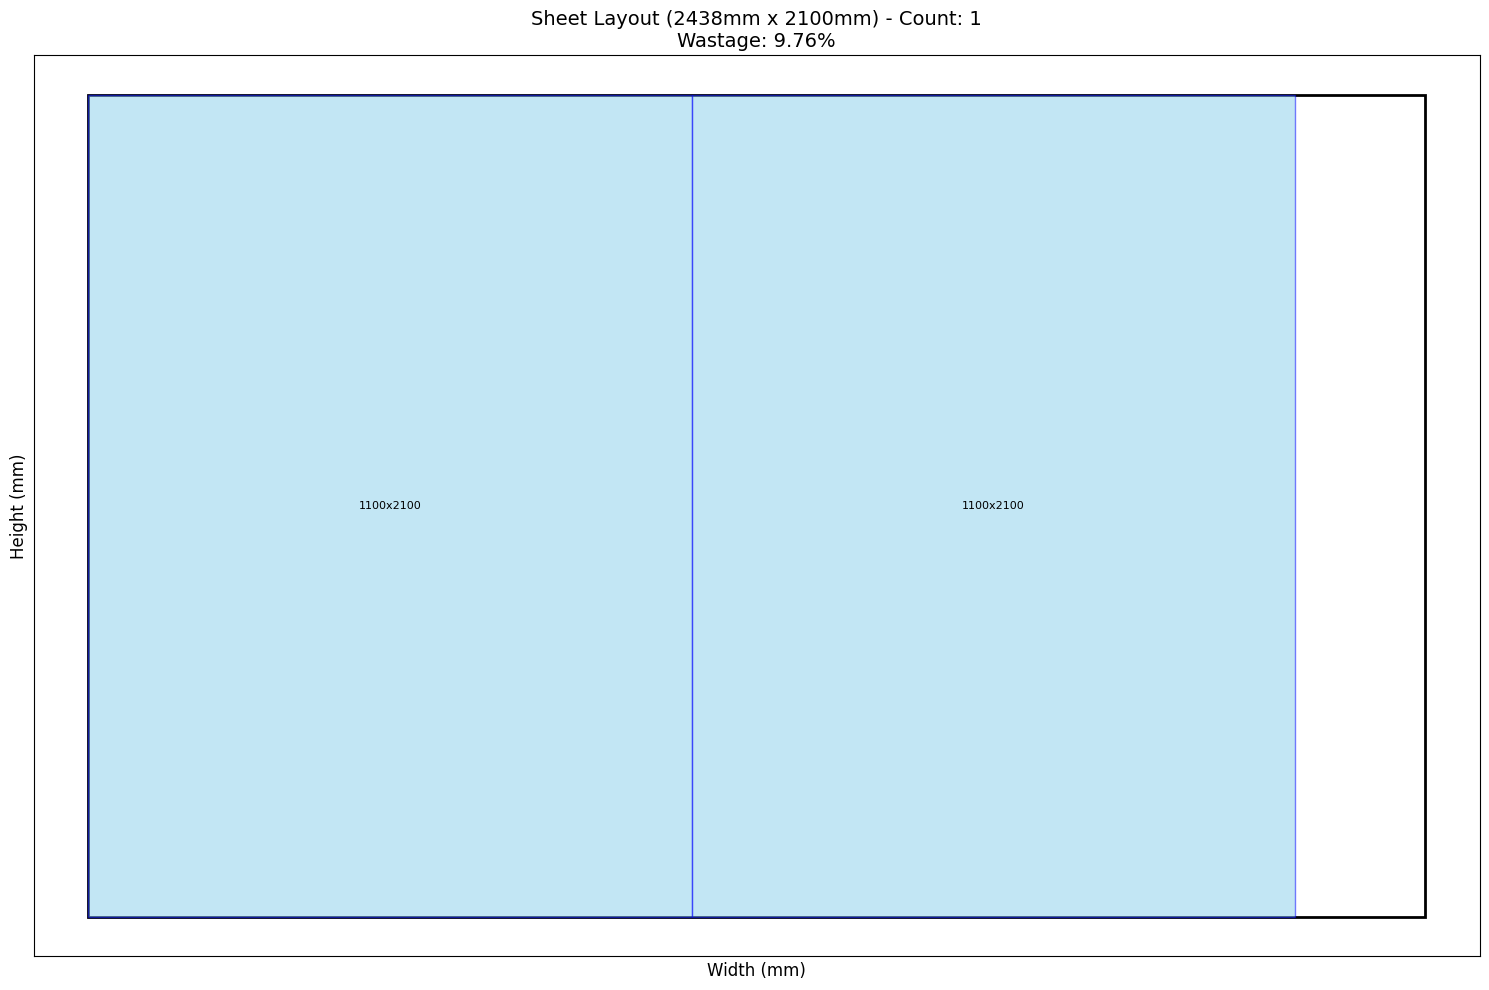

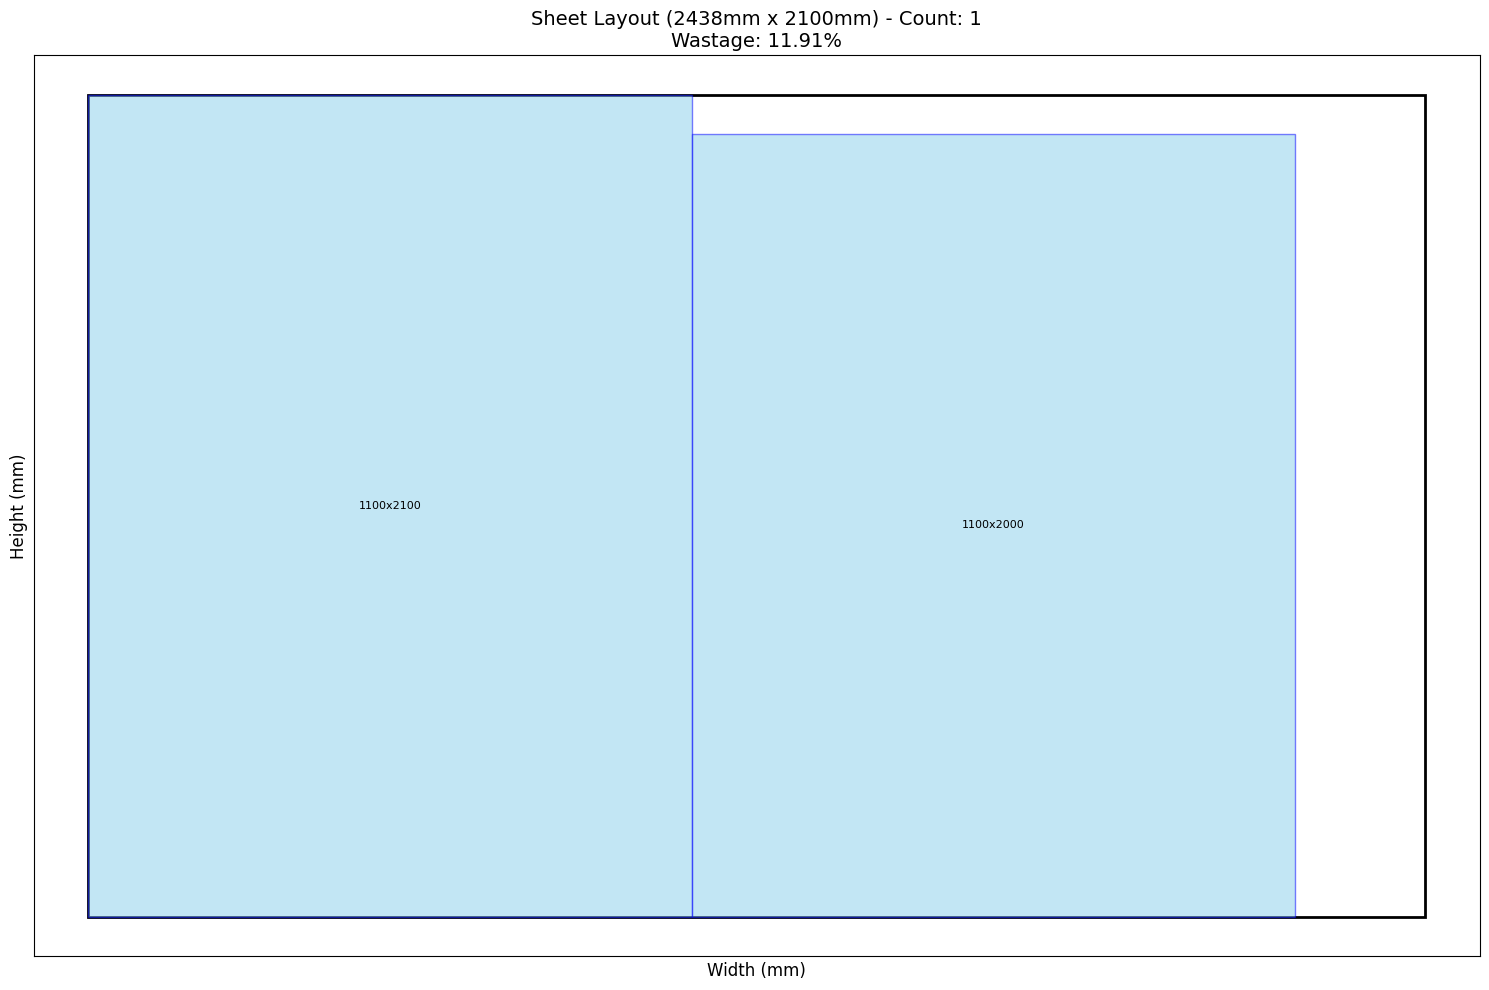

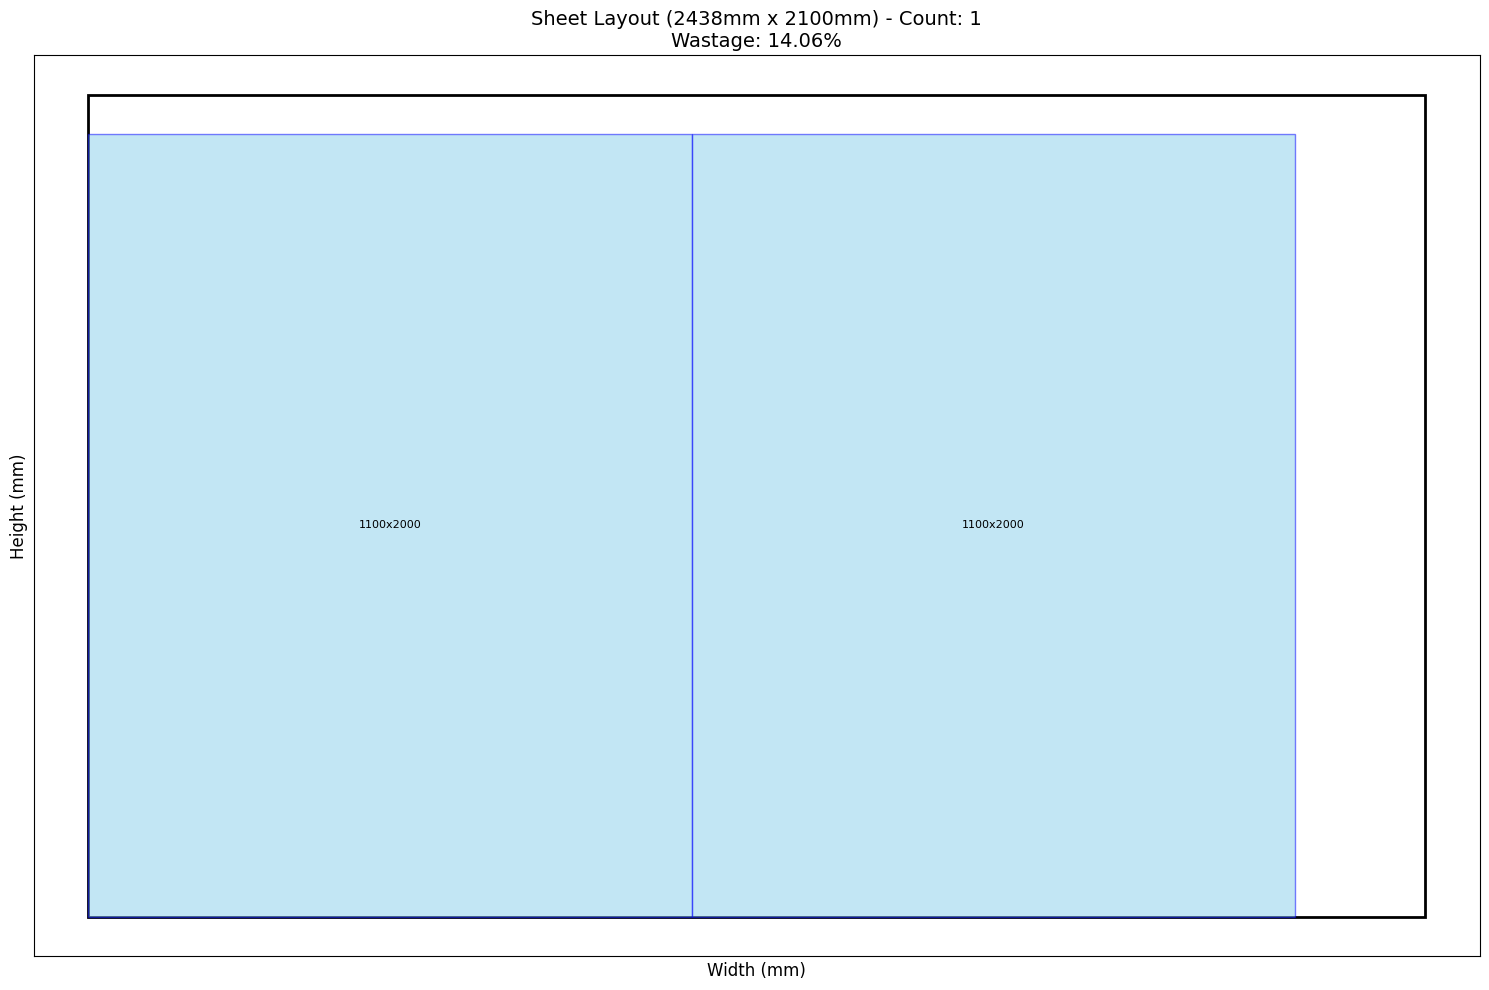

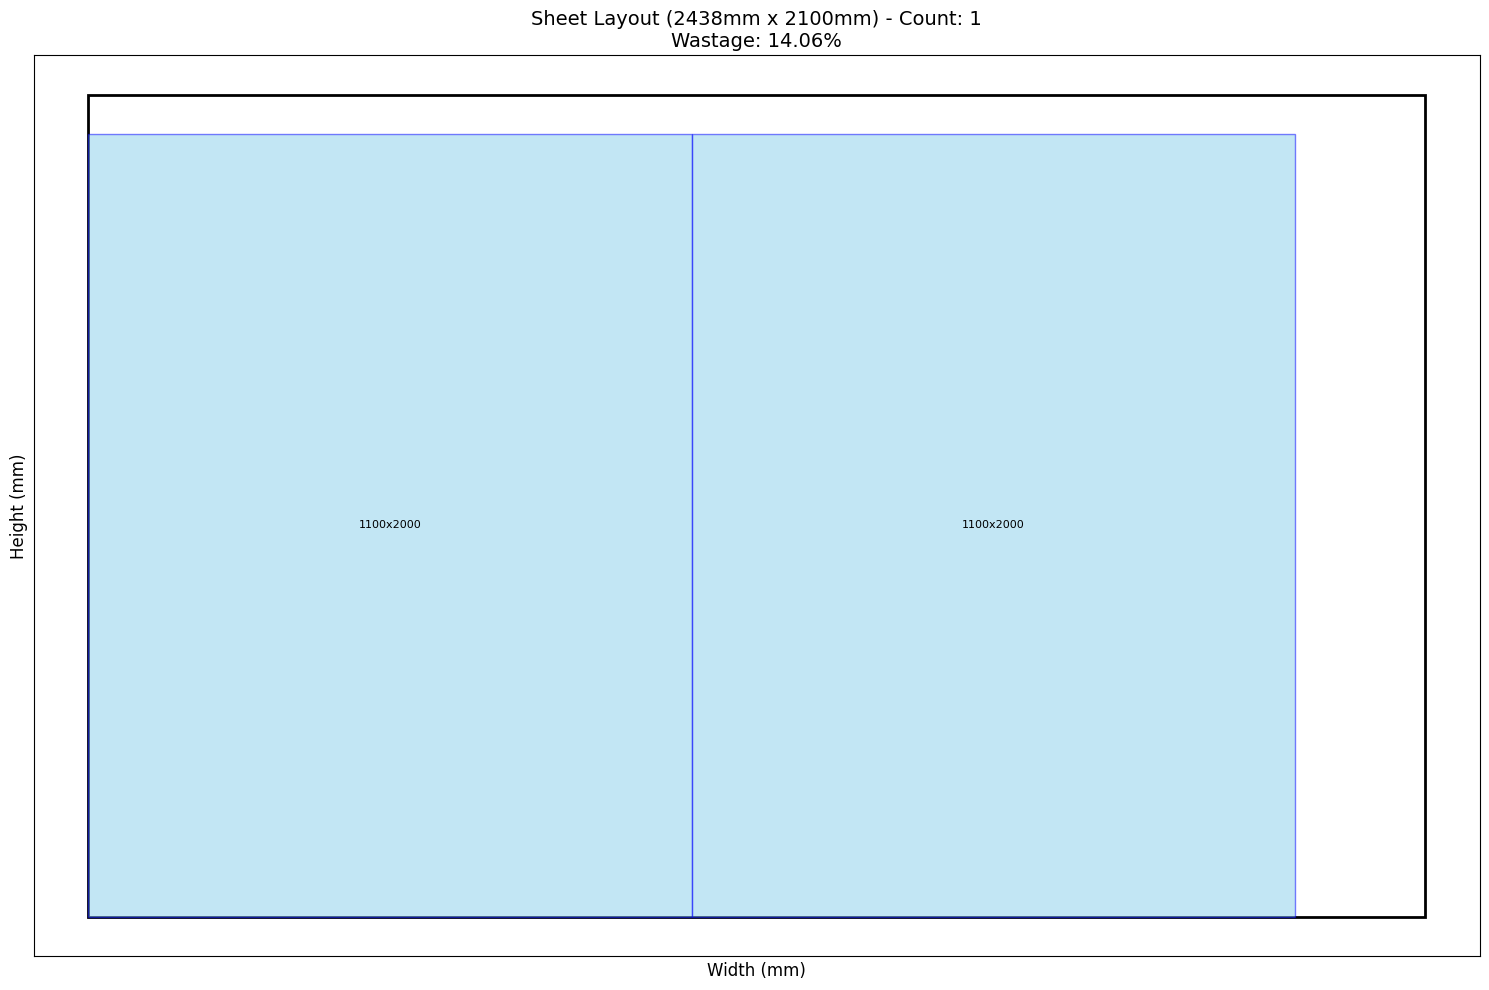

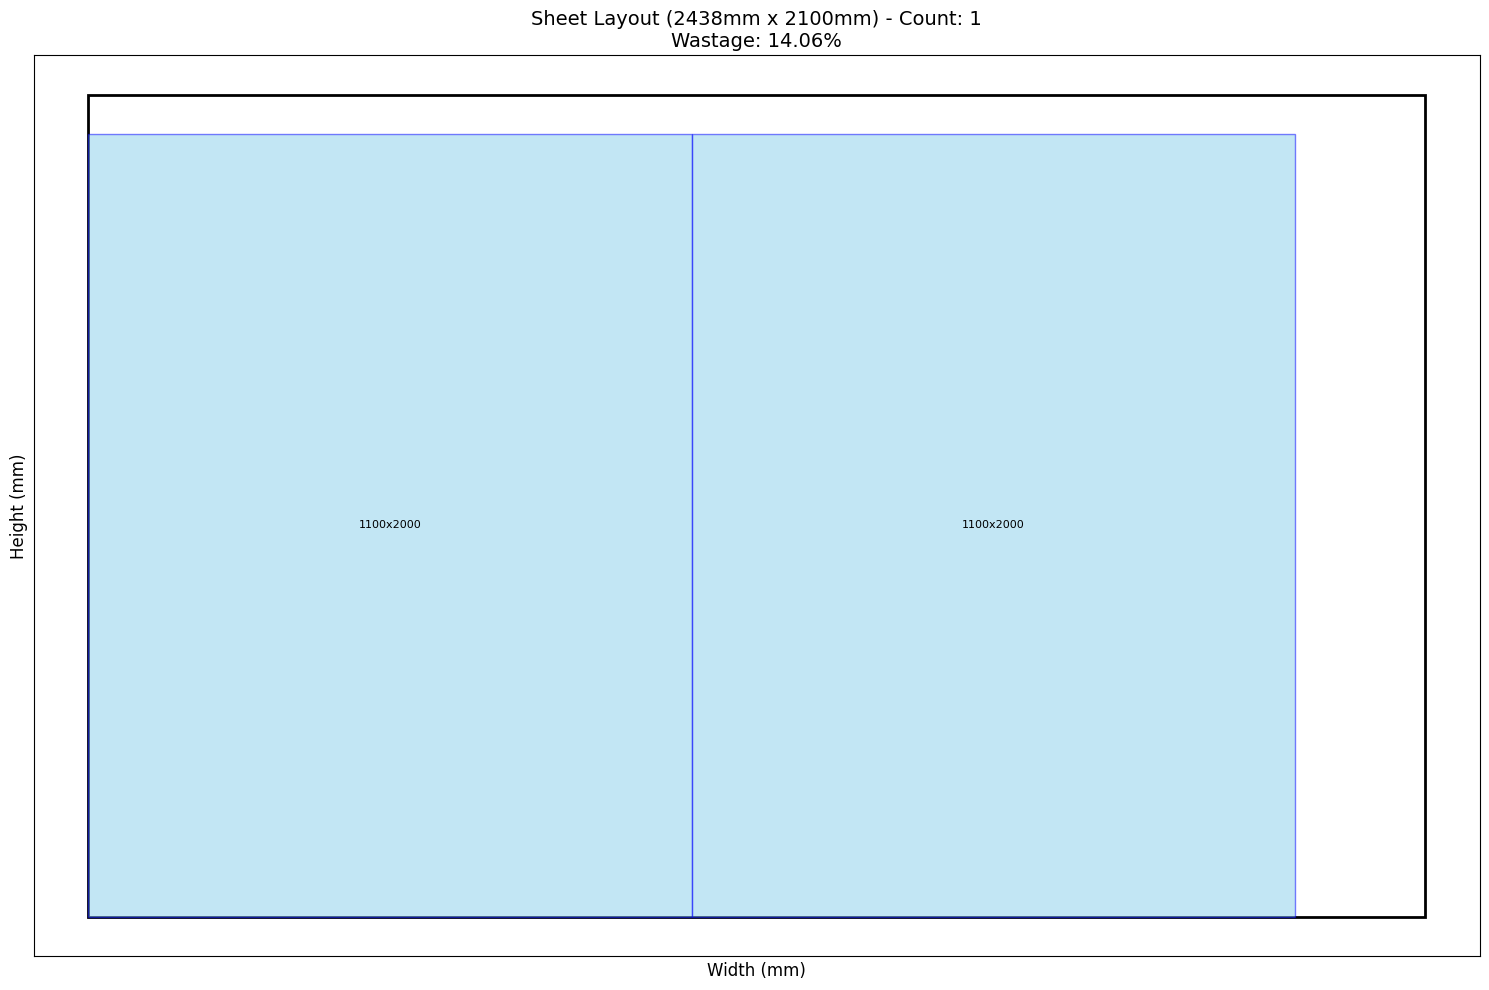

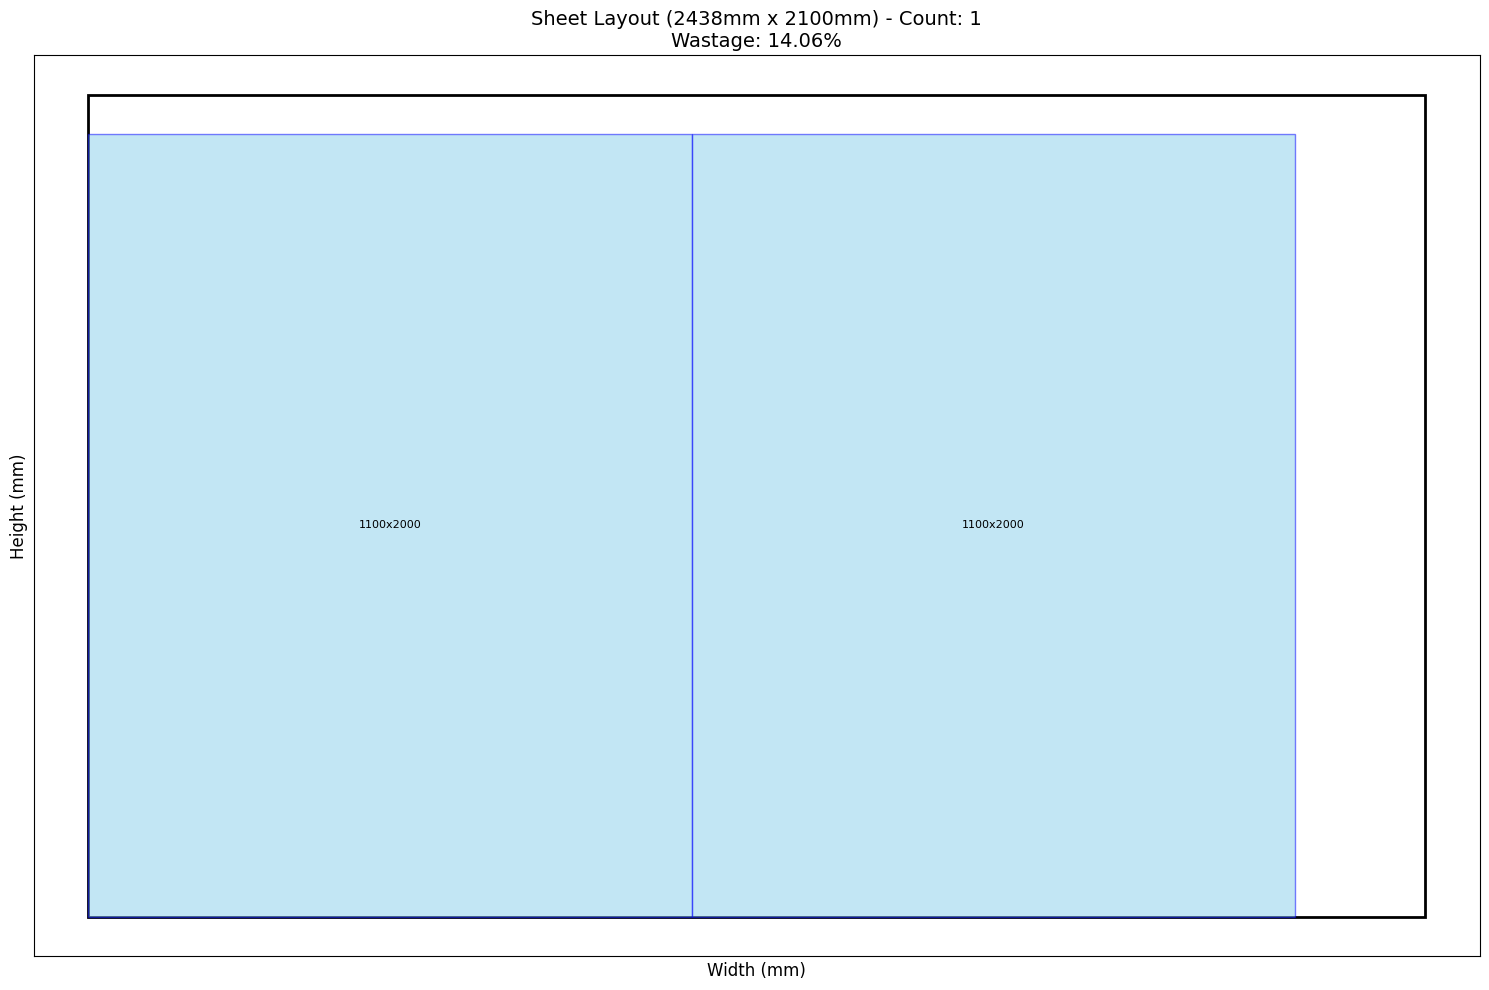

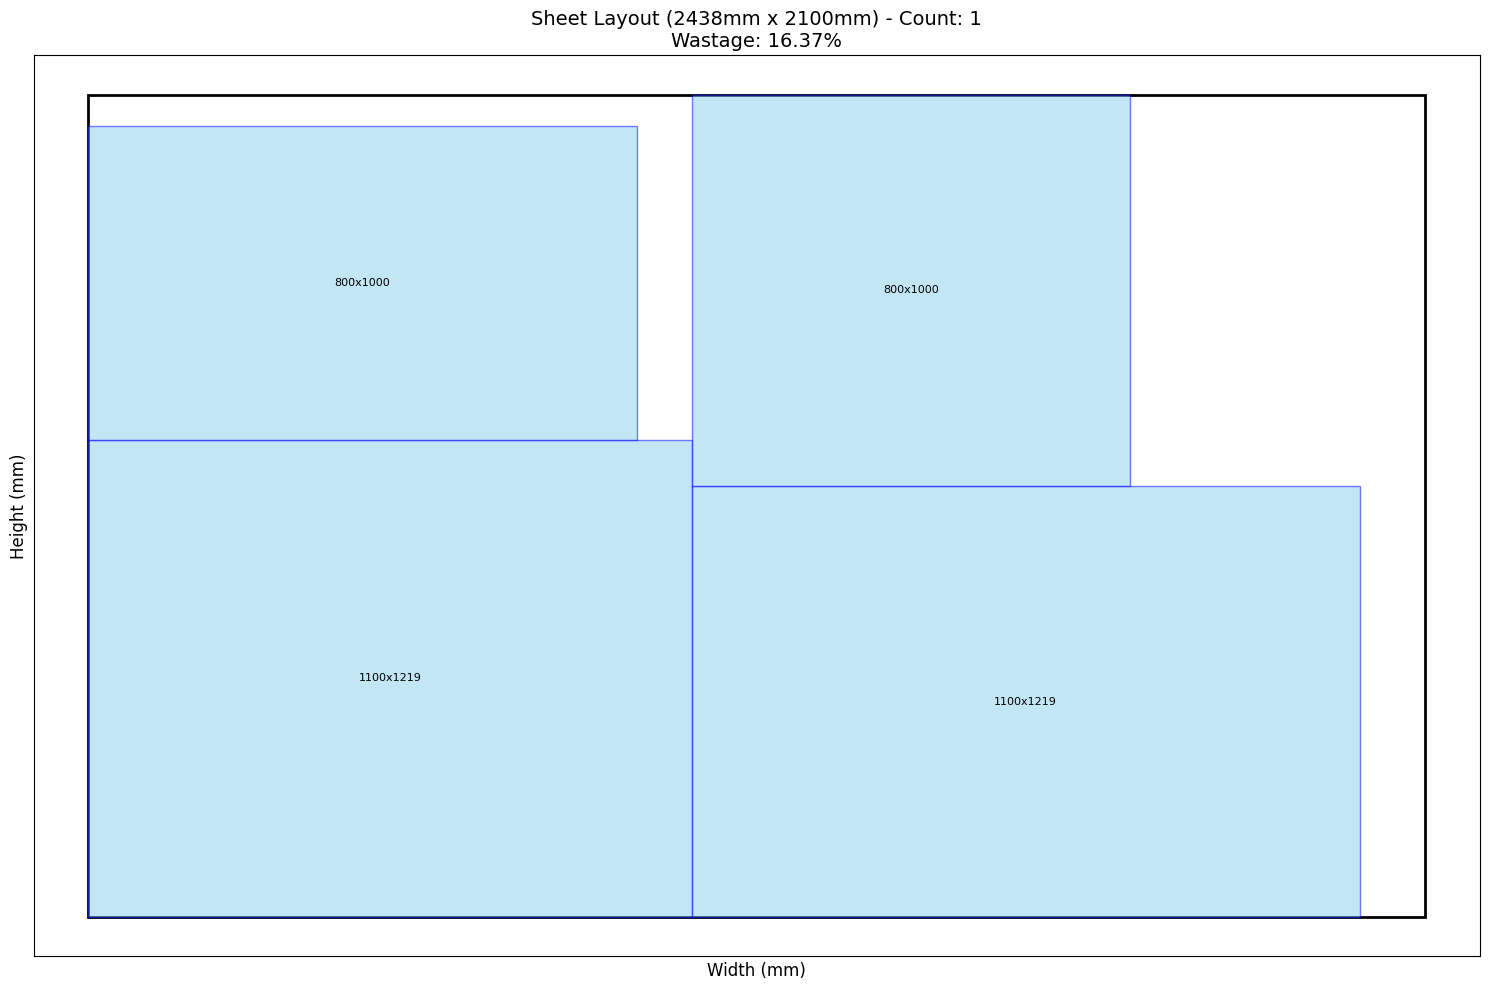

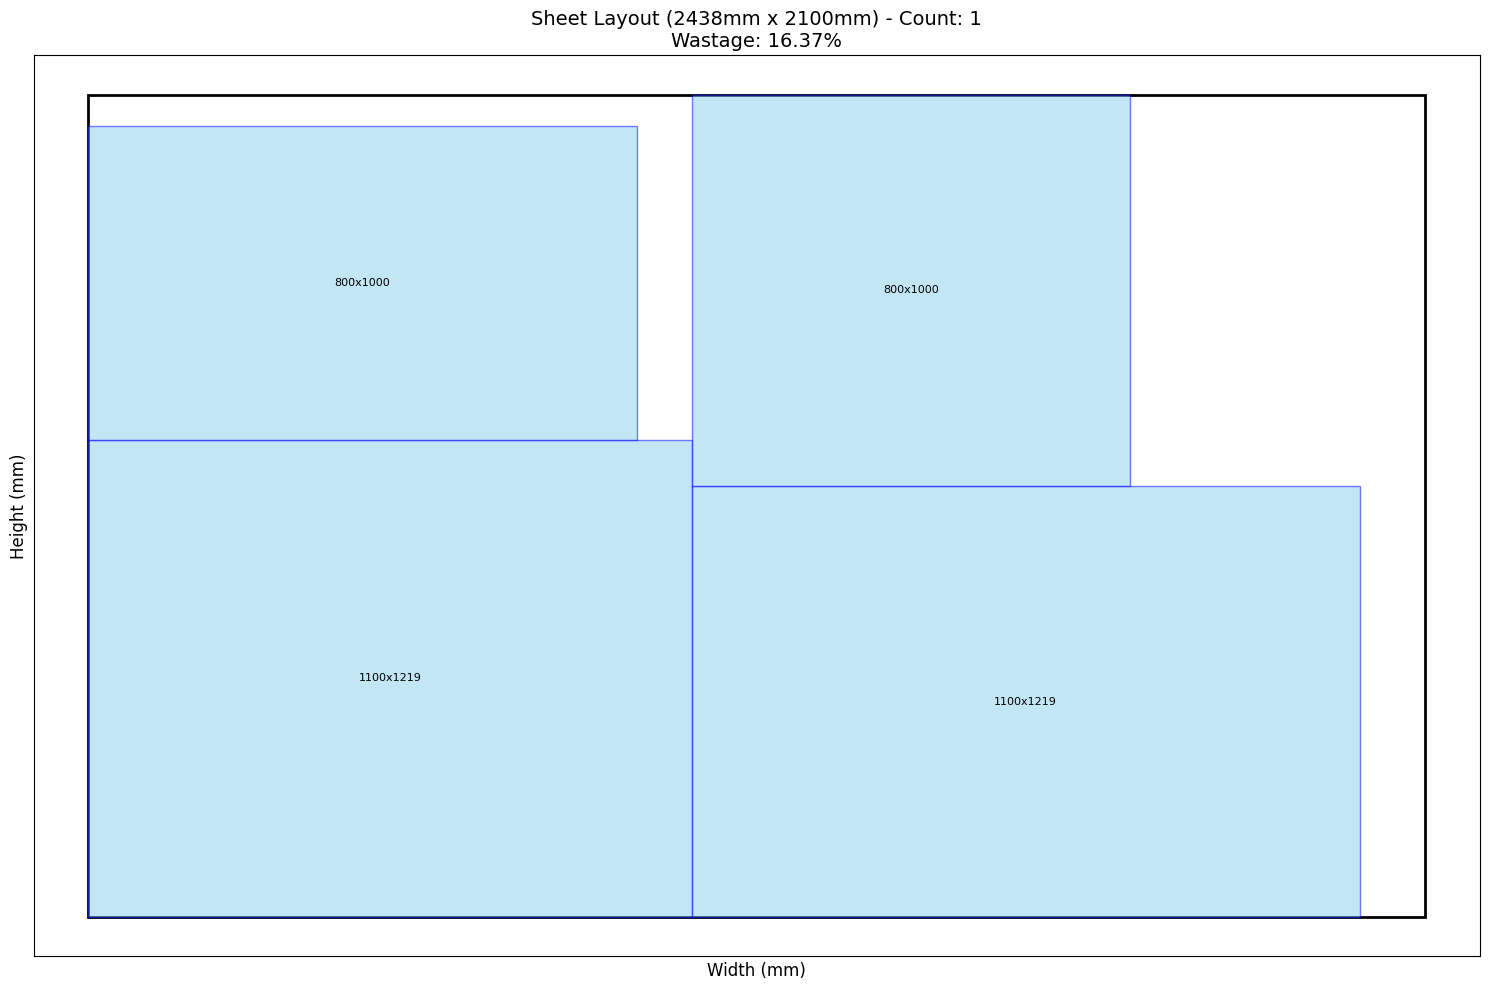

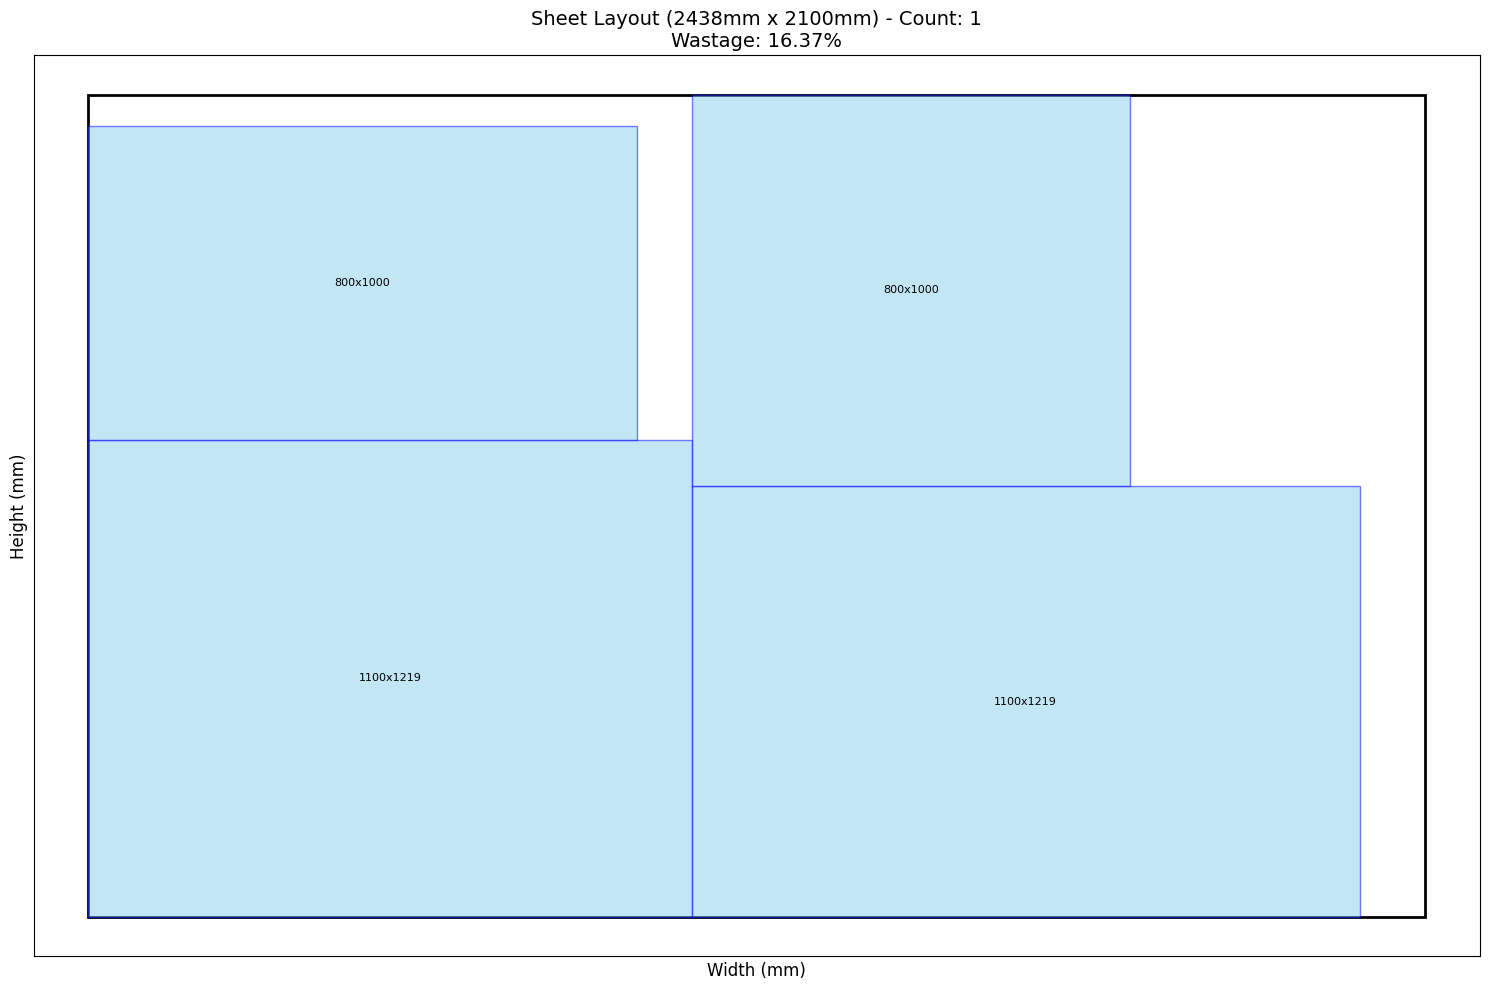

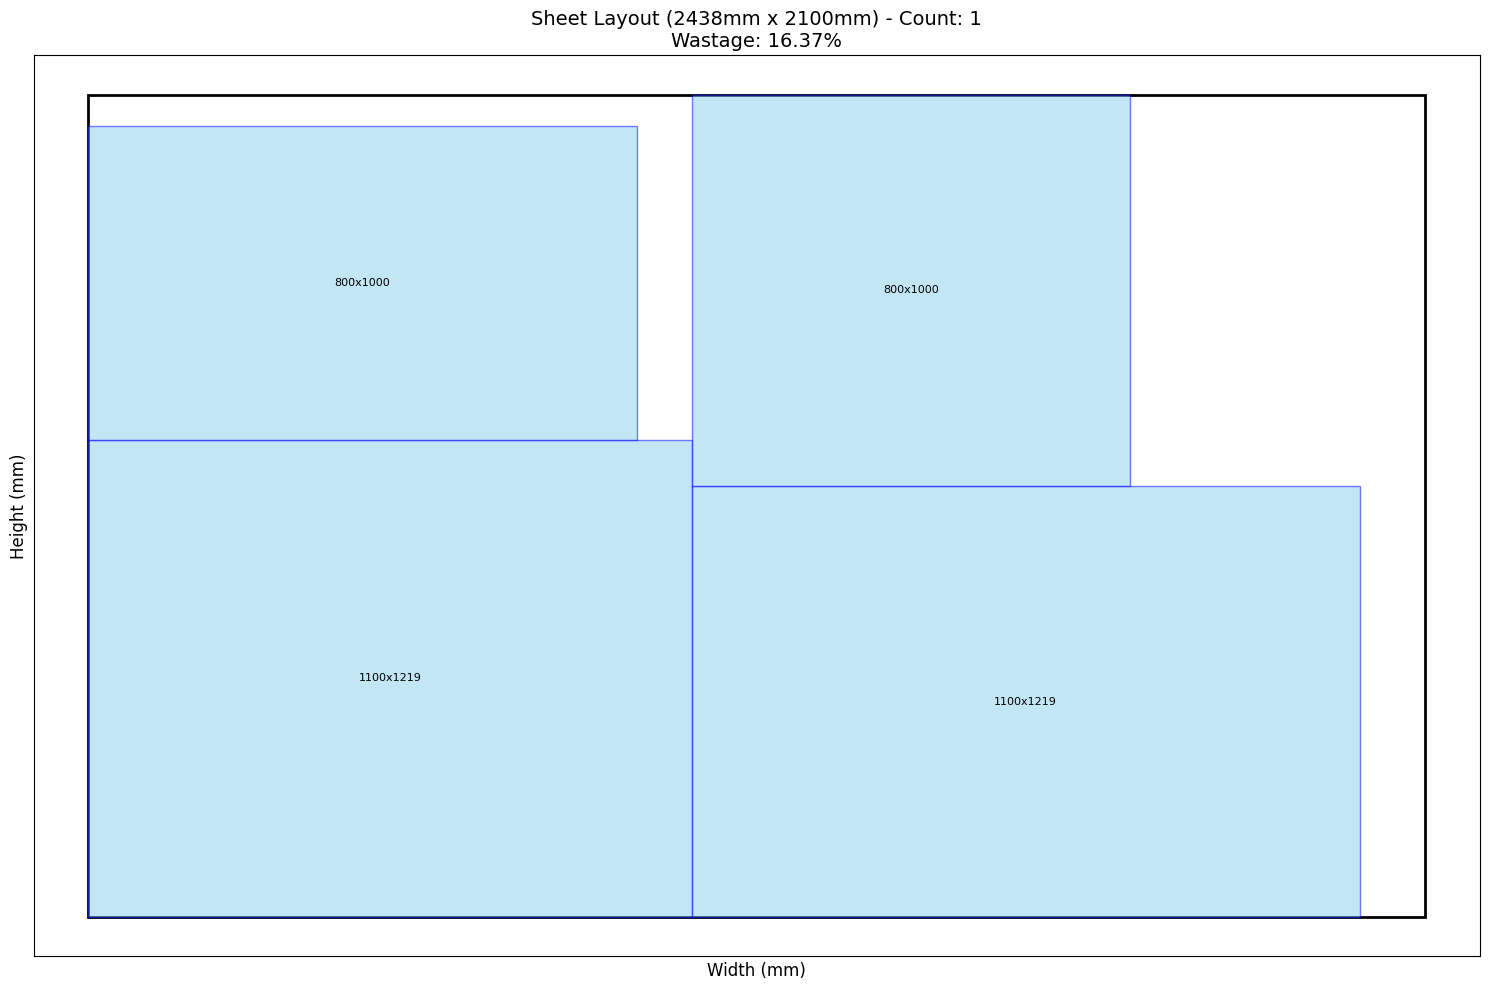

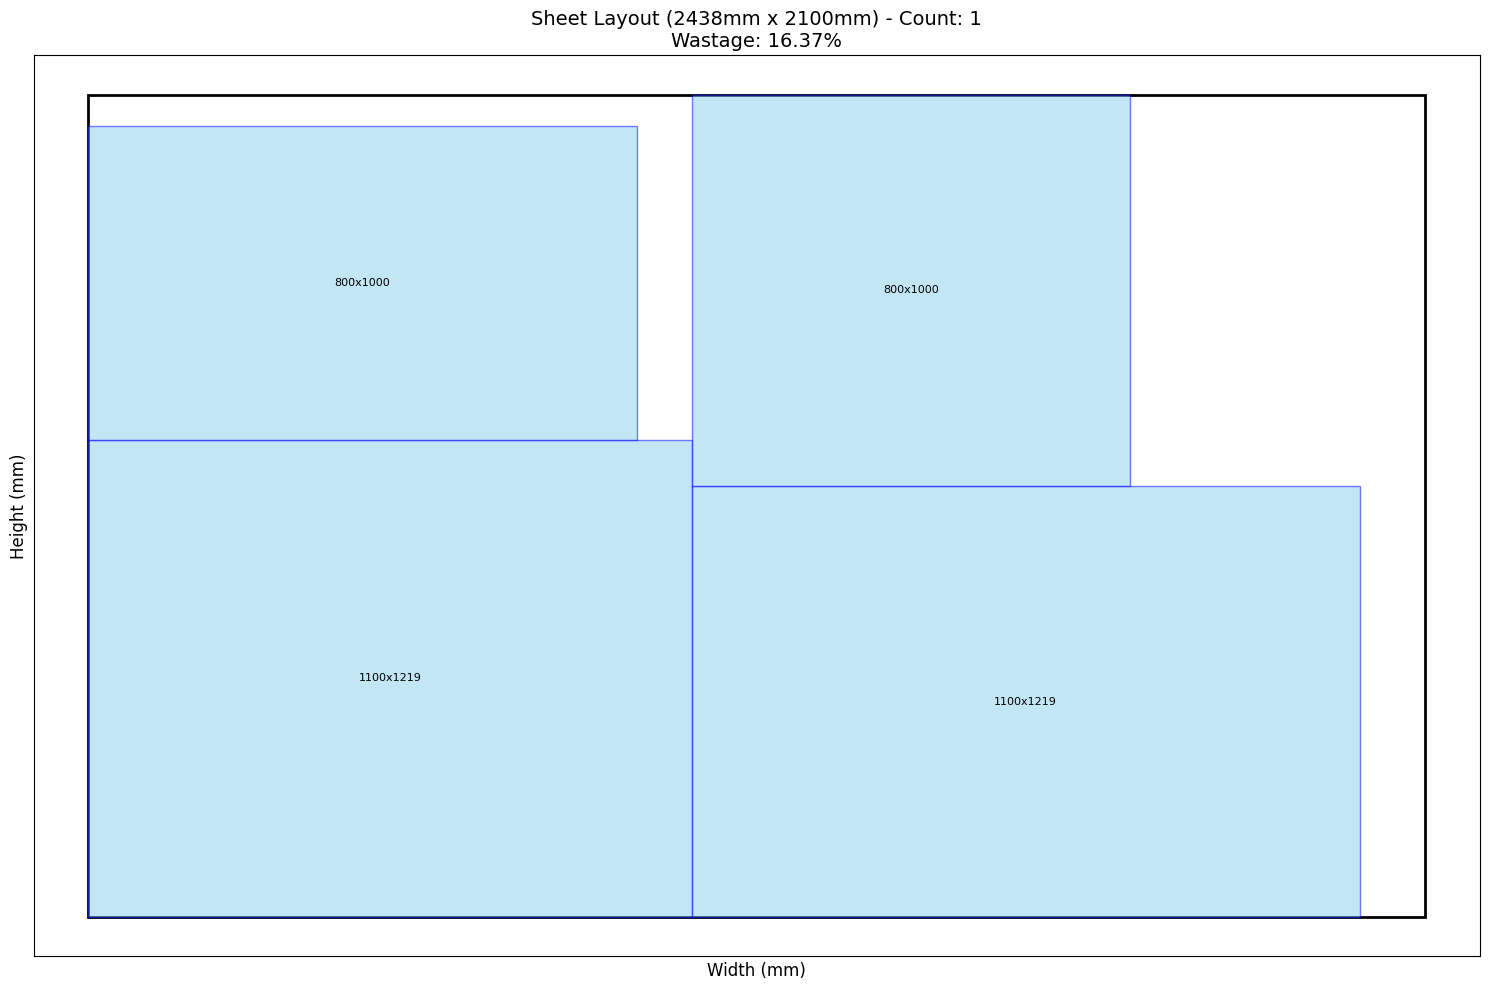

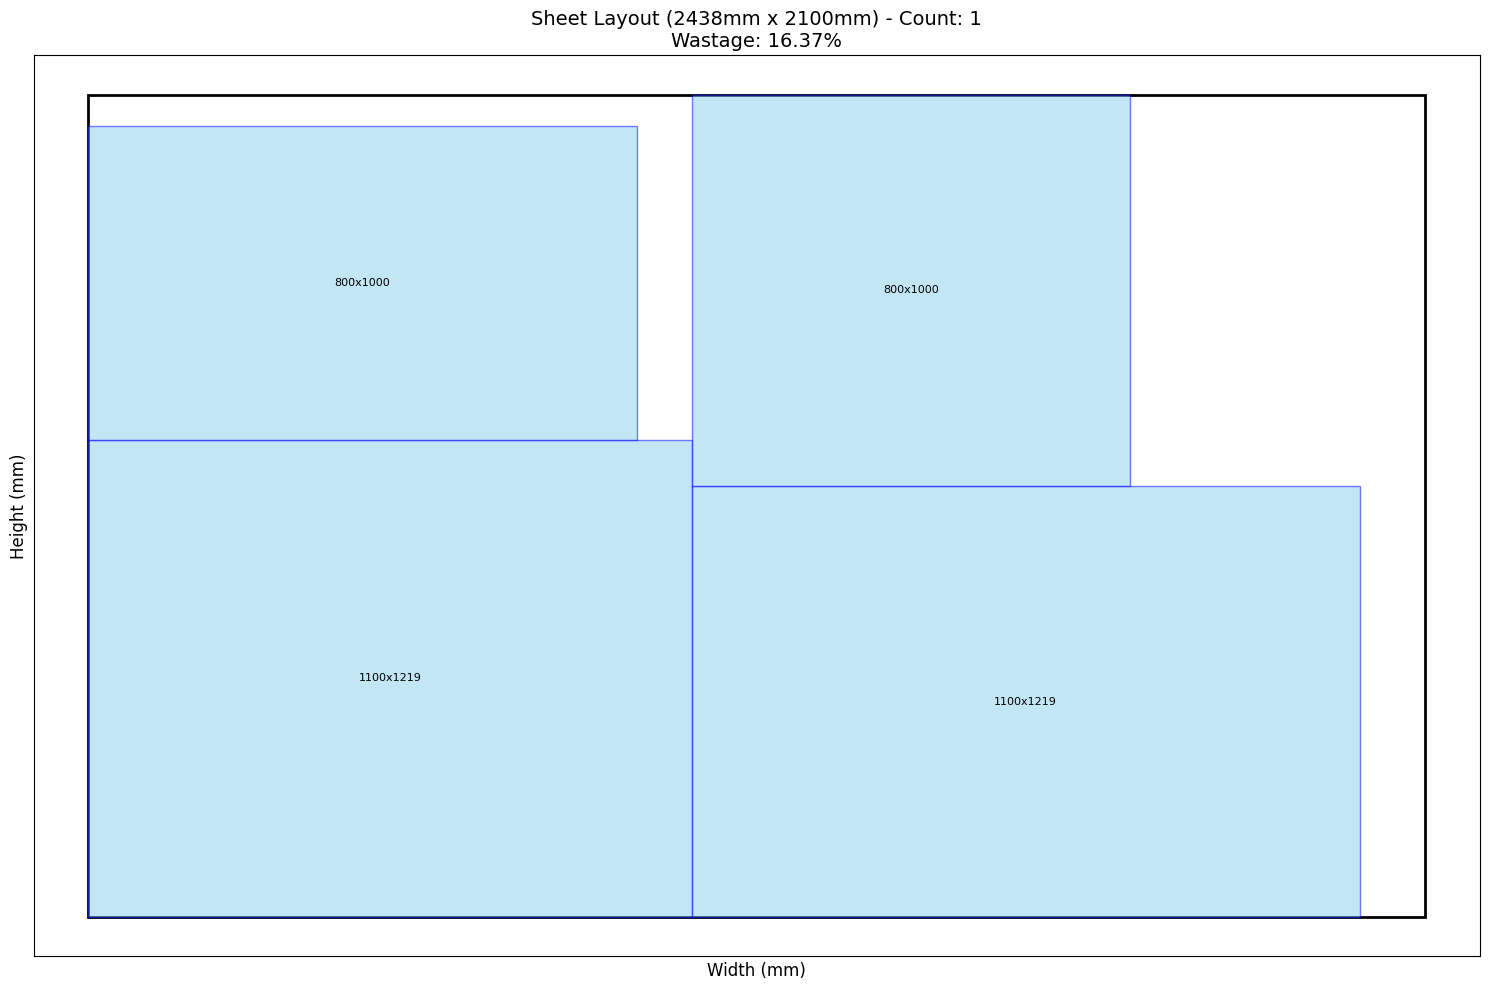

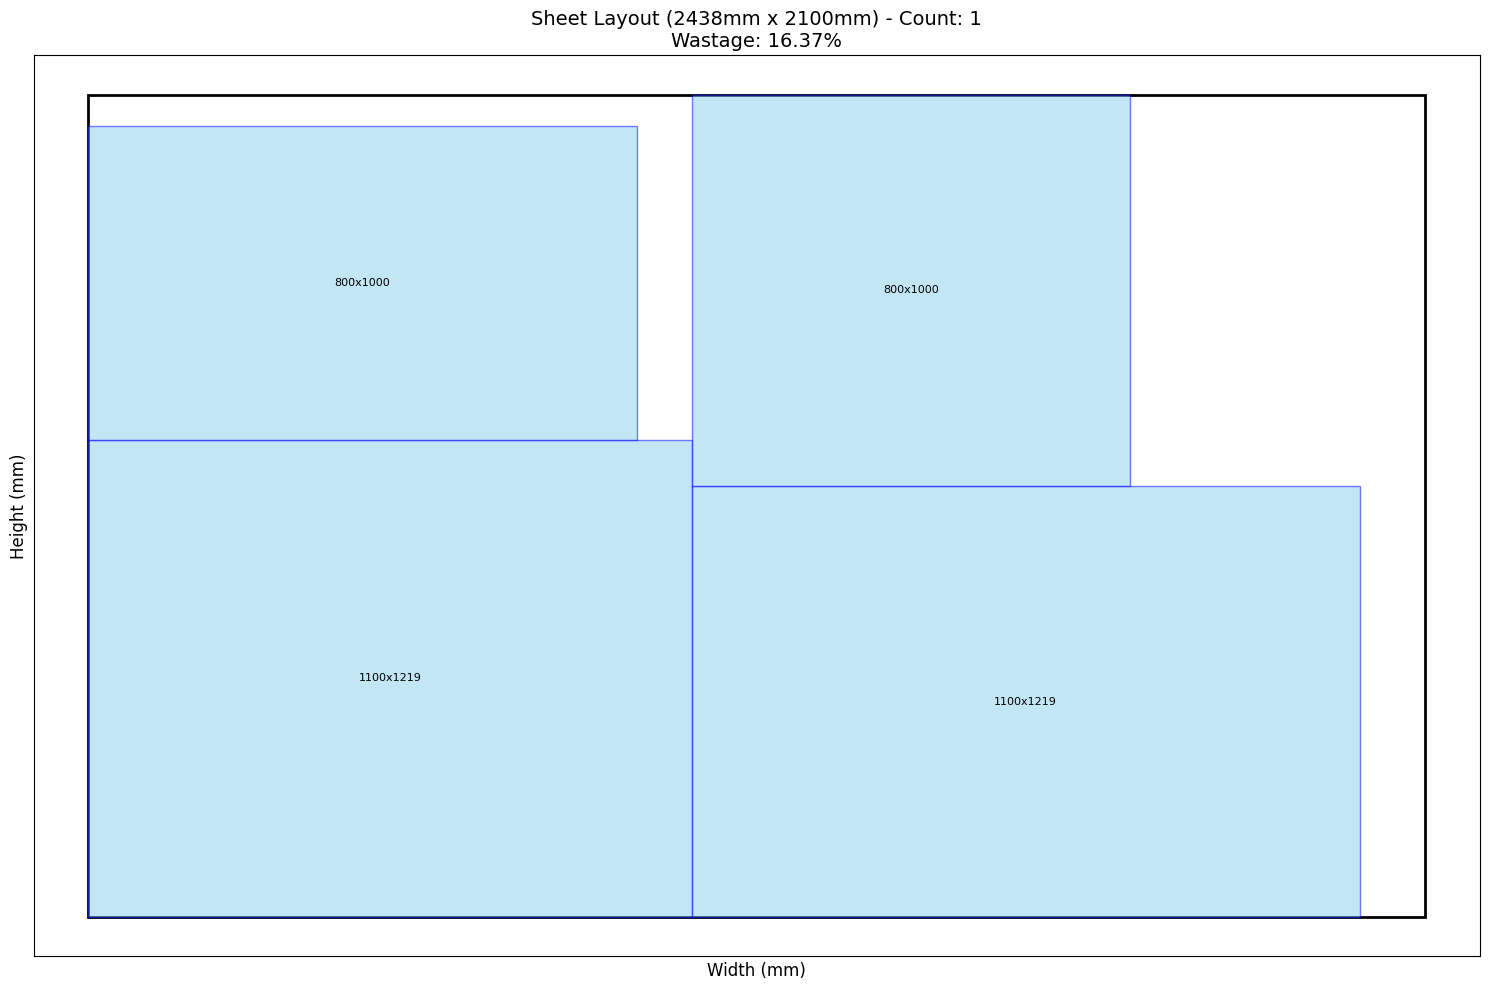

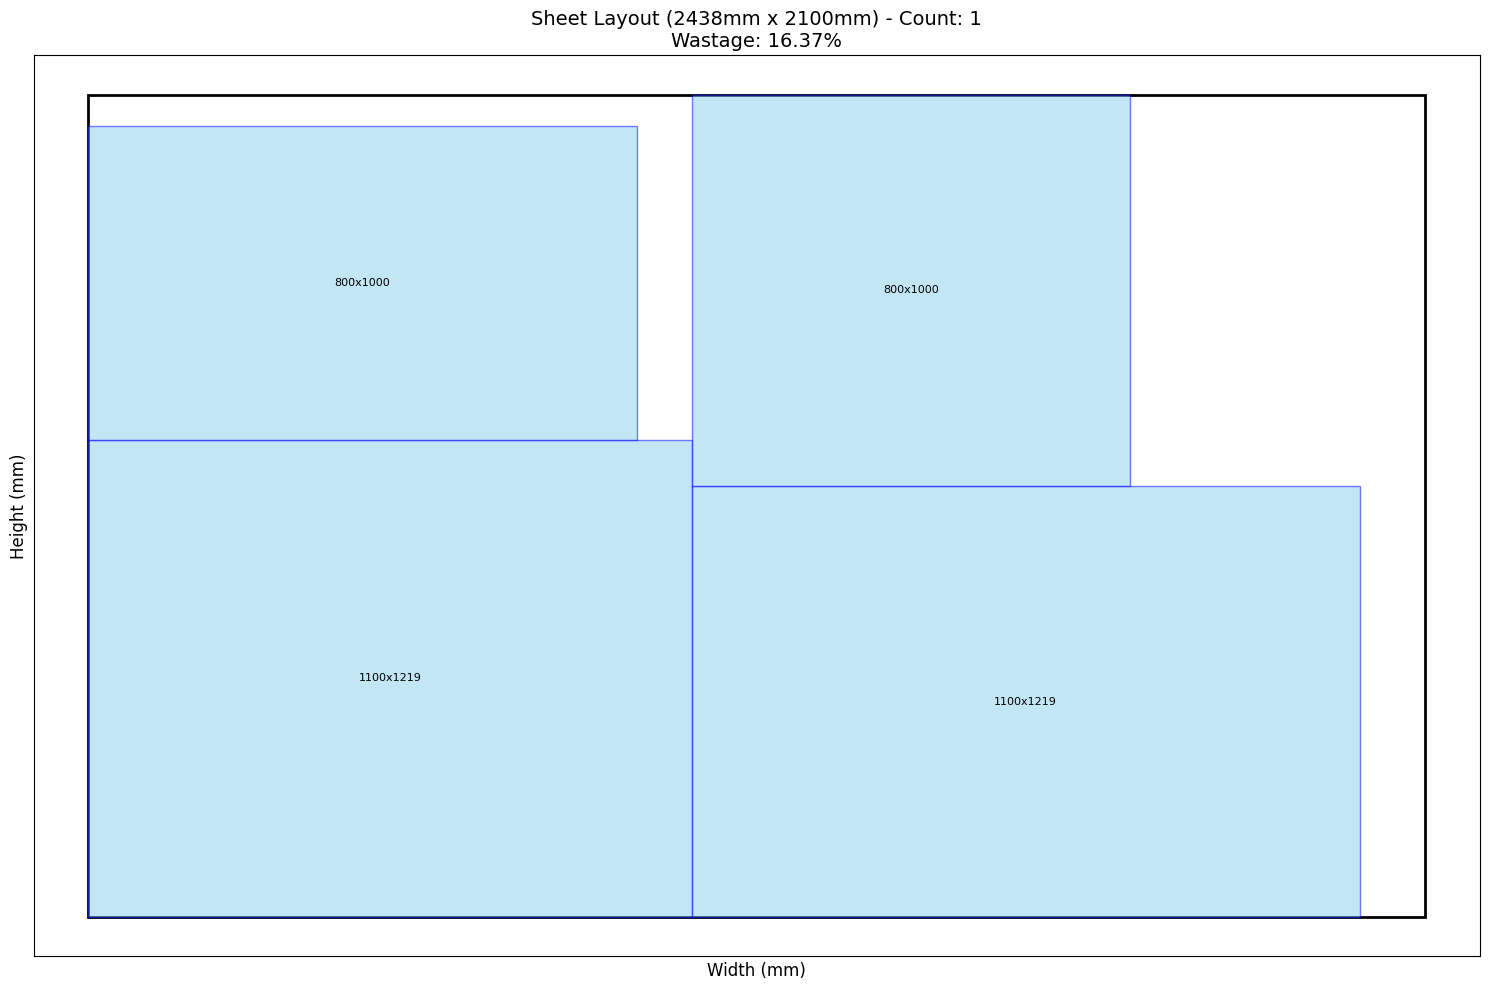

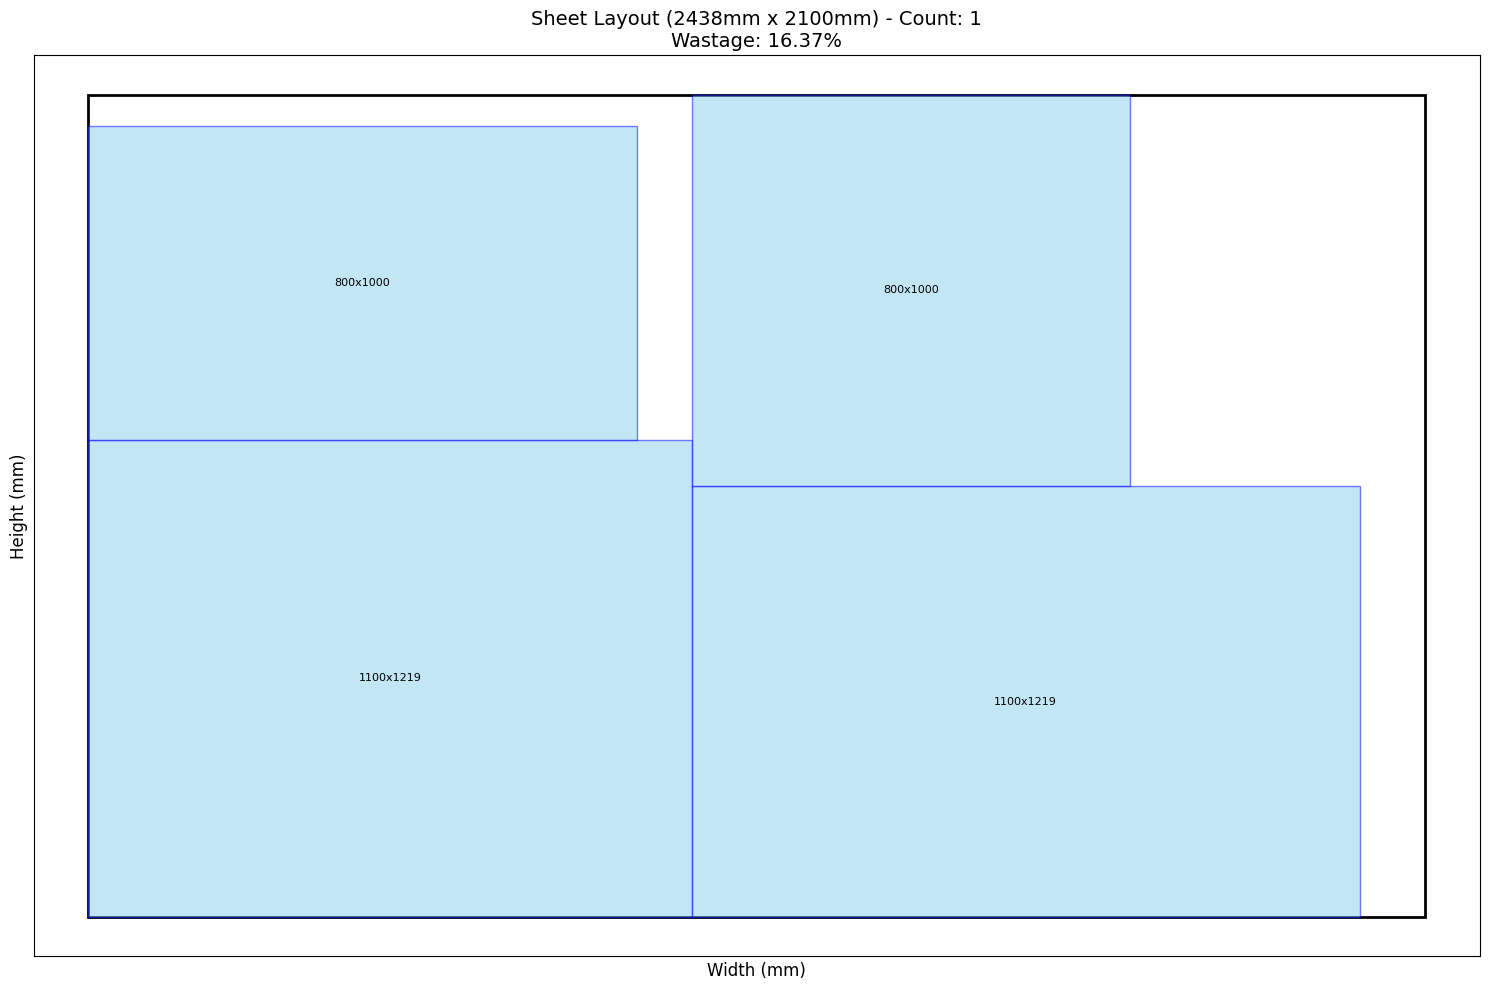

In [16]:
import csv
from typing import List, Dict
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from rectpack import newPacker

# Define file paths
glass_data_file = 'data/glass_data2.csv'
stock_sizes_file = 'data/glass_sheet_size1.csv'

gap = 0  # Gap between parts in mm

# Load Data Functions
def load_glass_data(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'location': row['location'], 
                 'length': int(row['glass_length']), 
                 'height': int(row['glass_height']), 
                 'qty': int(row['glass_qty'])} for row in reader]

def load_stock_sizes(filepath: str) -> List[Dict]:
    with open(filepath, 'r') as file:
        reader = csv.DictReader(file)
        return [{'length': int(row['length']), 
                 'width': int(row['width']), 
                 'qty': int(row['qty'])} for row in reader]

# Expand Parts
def expand_parts(glass_parts: List[Dict]) -> List[Dict]:
    expanded_parts = []
    for part in glass_parts:
        expanded_parts.extend([{'location': part['location'], 'length': part['length'], 'height': part['height']} for _ in range(part['qty'])])
    return expanded_parts

# Layout Optimization using rectpack
def calculate_layout_with_rectpack(parts: List[Dict], stock_sizes: List[Dict], gap: int):
    packer = newPacker(rotation=True)

    # Add parts to the packer
    for part in parts:
        packer.add_rect(part['length'] + gap, part['height'] + gap, part)

    # Add stock sizes to the packer
    for stock in stock_sizes:
        for _ in range(stock['qty']):
            packer.add_bin(stock['length'], stock['width'])

    # Perform packing
    packer.pack()

    # Collect results
    sheets = []
    for i, bin in enumerate(packer):
        sheet = {'size': (bin.width, bin.height), 'placements': []}
        for rect in bin:
            part = rect.rid
            x, y, w, h = rect.x, rect.y, rect.width - gap, rect.height - gap
            rotated = (part['length'], part['height']) != (w, h)
            sheet['placements'].append({'part': part, 'position': (x, y), 'rotated': rotated})
        sheets.append(sheet)

    return sheets

# Visualization Functions
def group_sheets_by_layout(optimized_layout):
    """Group identical sheets and count occurrences."""
    sheet_groups = Counter(
        frozenset((placement['part']['length'], placement['part']['height'], placement['rotated']) 
                  for placement in sheet['placements'])
        for sheet in optimized_layout
    )
    grouped_sheets = []
    for unique_layout, count in sheet_groups.items():
        matching_sheets = next(sheet for sheet in optimized_layout 
                               if frozenset((p['part']['length'], p['part']['height'], p['rotated']) 
                                            for p in sheet['placements']) == unique_layout)
        grouped_sheets.append((matching_sheets, count))
    return grouped_sheets

def plot_sheet_layout(sheet_size, placements, sheet_count, wastage_percentage):
    """Plot a single sheet layout with a count annotation."""
    sheet_width, sheet_height = sheet_size
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw the sheet boundary
    rect = patches.Rectangle((0, 0), sheet_width, sheet_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    # Draw each placement on the sheet
    for placement in placements:
        part = placement['part']
        position = placement['position']
        rotated = placement['rotated']
        length = part['height'] if rotated else part['length']
        height = part['length'] if rotated else part['height']

        # Draw the glass piece
        rect = patches.Rectangle(position, length, height, edgecolor='blue', facecolor='skyblue', alpha=0.5)
        ax.add_patch(rect)
        ax.text(position[0] + length / 2, position[1] + height / 2, 
                f"{part['length']}x{part['height']}", 
                ha='center', va='center', fontsize=8, color='black')

    # Add title with sheet count and wastage percentage
    ax.set_title(f"Sheet Layout ({sheet_width}mm x {sheet_height}mm) - Count: {sheet_count}\nWastage: {wastage_percentage:.2f}%", fontsize=14)
    ax.set_xlim(-100, sheet_width + 100)
    ax.set_ylim(-100, sheet_height + 100)
    ax.set_xlabel('Width (mm)', fontsize=12)
    ax.set_ylabel('Height (mm)', fontsize=12)

    # Remove grid and ticks
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Adjust margins to show outside measurements
    plt.margins(x=0.1, y=0.1)
    plt.tight_layout()

    plt.show()

def visualize_optimized_layout(optimized_layout):
    total_glass_area = sum(
        placement['part']['length'] * placement['part']['height']
        for sheet in optimized_layout for placement in sheet['placements']
    )

    for sheet in optimized_layout:
        sheet_area = sheet['size'][0] * sheet['size'][1]
        used_area = sum(p['part']['length'] * p['part']['height'] for p in sheet['placements'])
        wastage_percentage = 100 * (1 - used_area / sheet_area)
        plot_sheet_layout(sheet['size'], sheet['placements'], 1, wastage_percentage)

# Main Optimization with Print and Visualization
def optimize_glass_cutting_with_visuals(glass_data_file: str, stock_sizes_file: str, gap: int):
    glass_parts = load_glass_data(glass_data_file)
    stock_sizes = load_stock_sizes(stock_sizes_file)

    # Expand parts based on quantity
    expanded_parts = expand_parts(glass_parts)

    # Sort parts by area in descending order
    expanded_parts.sort(key=lambda x: x['length'] * x['height'], reverse=True)

    optimized_layout = calculate_layout_with_rectpack(expanded_parts, stock_sizes, gap)

    # Calculate statistics
    total_glass_area_m2 = sum(part['length'] * part['height'] for part in expanded_parts) / 1_000_000
    total_sheet_area_m2 = sum(sheet['size'][0] * sheet['size'][1] for sheet in optimized_layout) / 1_000_000
    used_area_percentage = (total_glass_area_m2 / total_sheet_area_m2) * 100
    wastage_percentage = 100 - used_area_percentage
    sheet_counter = Counter((sheet['size'][0], sheet['size'][1]) for sheet in optimized_layout)

    # Display results
    print(f"Total stock area: {total_sheet_area_m2:.3f} sq m")
    print(f"Total glass area: {total_glass_area_m2:.3f} sq m")
    print(f"Total sheets used: {len(optimized_layout)}")
    print(f"Used area percentage: {used_area_percentage:.2f}%")
    print(f"Wastage percentage: {wastage_percentage:.2f}%")
    print("\nSummary of sheet sizes used:")
    for (length, width), qty in sheet_counter.items():
        print(f"  {length}mm x {width}mm: {qty} pcs")

    # Visualize the layout
    visualize_optimized_layout(optimized_layout)

# Run the function
optimize_glass_cutting_with_visuals(glass_data_file, stock_sizes_file, gap)
